# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="./DataECG.png" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [1]:
# Librairies utiles
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données d'apprentissage et de test

In [2]:
# Chargement des données brutes
DataECGFull=np.load('./DataECG.npy')
print('Taille du dataset ECG:', DataECGFull.shape)

# Après extraction des features
# Chargement des données d'apprentissage
DataFeature=np.load('./DataFeature.npy')
Label=np.load('./Label.npy')
print('Taille du dataset après extraction de features :', DataFeature.shape, Label.shape)


# Séparation en ensemble d'apprentissage et de test
from sklearn.model_selection import train_test_split

DataECGApp, DataECGTest, Label_train, Label_test = train_test_split(DataECGFull, Label, test_size=0.2, random_state=42)
DataFeatureApp, DataFeatureTest, LabelF_train, LabelF_test = train_test_split(DataFeature, Label, test_size=0.2, random_state=42)

print('Taille de la base d apprentissage ECG :', DataECGApp.shape, 'Taille du dataset de test ECG :', DataECGTest.shape)
print('Taille de la base d apprentissage Features :', DataFeatureApp.shape, 'Taille du dataset de test Features :', DataFeatureTest.shape)


Taille du dataset ECG: (5000, 188)
Taille du dataset après extraction de features : (5000, 156) (5000,)
Taille de la base d apprentissage ECG : (4000, 188) Taille du dataset de test ECG : (1000, 188)
Taille de la base d apprentissage Features : (4000, 156) Taille du dataset de test Features : (1000, 156)


In [3]:
label_name = ["battement normaux", "battement inconnus"," bat ect. ventriculaire", "bat. ect. supra", "battement de fusion"]

### Isolation des caractéristiques

In [4]:
# Isolation des caractéristiques

# Temporel
DataFeatureAppTemp = DataFeatureApp[:, :31]
DataFeatureTestTemp = DataFeatureTest[:, :31]

# Statistique
DataFeatureAppStat = DataFeatureApp[:, 31:45]
DataFeatureTestStat = DataFeatureTest[:, 31:45]

# Spectrale
DataFeatureAppSpec = DataFeatureApp[:, 45:156]
DataFeatureTestSpec = DataFeatureTest[:, 45:156]

print(DataFeatureAppTemp.shape)
print(DataFeatureTestTemp.shape)
print(DataFeatureAppStat.shape)
print(DataFeatureTestStat.shape)
print(DataFeatureAppSpec.shape)
print(DataFeatureTestSpec.shape)

(4000, 31)
(1000, 31)
(4000, 14)
(1000, 14)
(4000, 111)
(1000, 111)


## Vecteur médian des caractéristiques pour chaque classe

In [5]:
# Calculer le vecteur médian des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques avec numpy
unique_labels = np.unique(LabelF_train)
print("Classes uniques :", unique_labels)

for label in unique_labels:
  Data_App_Temp= DataFeatureApp[:,:32]
  # Filtrer les données pour la classe actuelle
  class_features = Data_App_Temp[np.array(LabelF_train) == label]
    # Calculer la médiane des caractéristiques pour cette classe
  class_median = np.median(class_features, axis=0)  # Utilisation de np.median()
  class_feature_medians[label] = class_median

# Afficher les résultats
#for label, median_vector in class_feature_medians.items():
   # print(f"Vecteur médian pour la classe {label} : {median_vector}")

Classes uniques : [0. 1. 2. 3. 4.]


# Chargement des variables issues *TSFEL*

In [6]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [7]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels

In [8]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def retrieve_info(cluster_labels, y_train):
    # Initialisation de la matrice de correspondance (confusion temporaire)
    n_clusters = len(np.unique(cluster_labels))
    n_classes = len(np.unique(y_train))
    contingency_matrix = np.zeros((n_clusters, n_classes), dtype=int)

    # Remplissage de la matrice de contingence
    for i in range(n_clusters):
        indices = np.where(cluster_labels == i)[0]
        true_labels = y_train[indices]
        counts = np.bincount(true_labels, minlength=n_classes)
        contingency_matrix[i, :] = counts

    # Application de l'algorithme de Hongrie pour maximiser les correspondances
    # On transforme le problème en un problème de coût minimal
    cost_matrix = -contingency_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Création de la table de correspondance
    reference_labels = np.zeros(n_clusters, dtype=int)
    for cluster, label in zip(row_ind, col_ind):
        reference_labels[cluster] = label

    return reference_labels

def true_labels(y_pred_kmeans, y_train):
    reference_labels = retrieve_info(y_pred_kmeans, y_train)
    number_labels = np.zeros(len(y_pred_kmeans), dtype=int)

    for i in range(len(y_pred_kmeans)):
        number_labels[i] = reference_labels[y_pred_kmeans[i]]

    return number_labels


# Partie I : Implémentation de l'algorithme de programmation dynamique (DTW)

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD.



information (alban) : On veut comparer les caracteristiques du jeu de test aux valeurs médianes (par exemple)   du jeu de test pour chaque classe ( car on sait a quel classe chaque battement appartient)

On a un ensemble de caracteristique par battement et on veut les comparér via l'algo DTW, celui dont on est le plus proche alors on peut le classer comme étant un battement de ce type la ( il faut comparer a chaque classe ).

In [9]:
from math import *
import numpy as np
import sys

In [10]:
from sklearn.preprocessing import StandardScaler

# Normalisation des données d'apprentissage et de test
scaler = StandardScaler()
DataFeatureApp_normalized = scaler.fit_transform(DataFeatureApp)
DataFeatureTest_normalized = scaler.transform(DataFeatureTest)

In [11]:
# Calculer les vecteurs médians des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques
unique_labels = np.unique(LabelF_train)

for label in unique_labels:
    # Filtrer les données pour la classe actuelle
    class_features = DataFeatureApp_normalized[np.array(LabelF_train) == label]
    
    # Calculer la médiane des caractéristiques pour cette classe
    class_median = np.median(class_features, axis=0)
    class_feature_medians[label] = class_median

# Afficher les vecteurs médians pour chaque classe
for label, median in class_feature_medians.items():
    print(f"Classe {label} : Médiane calculée avec {len(median)} caractéristiques")

Classe 0.0 : Médiane calculée avec 156 caractéristiques
Classe 1.0 : Médiane calculée avec 156 caractéristiques
Classe 2.0 : Médiane calculée avec 156 caractéristiques
Classe 3.0 : Médiane calculée avec 156 caractéristiques
Classe 4.0 : Médiane calculée avec 156 caractéristiques


In [13]:
def DTW(A, B, d, w0=1, w1=1, w2=1):
    """
    Algorithme DTW avec poids ajustables pour aligner deux séries temporelles.

    Args:
        A (list or np.ndarray): Première série temporelle.
        B (list or np.ndarray): Deuxième série temporelle.
        d (function): Fonction de distance locale entre deux points.
        w0 (int): Poids pour l'insertion.
        w1 (int): Poids pour la correspondance.
        w2 (int): Poids pour la suppression.

    Returns:
        float: Score d'alignement.
        list: Chemin optimal d'alignement.
    """
    N, M = len(A), len(B)
    g = np.full((N + 1, M + 1), float('inf'))
    g[0, 0] = 0

    for i in range(1, N + 1):
        for j in range(1, M + 1):
            cost = d(A[i - 1], B[j - 1])
            g[i, j] = min(
                g[i - 1, j] + w0 * cost,
                g[i - 1, j - 1] + w1 * cost,
                g[i, j - 1] + w2 * cost
            )

    S = g[N, M] / (N + M)
    path = []
    i, j = N, M
    while i > 0 or j > 0:
        path.append((i - 1, j - 1))
        if i > 0 and j > 0 and g[i, j] == g[i - 1, j - 1] + w1 * d(A[i - 1], B[j - 1]):
            i -= 1
            j -= 1
        elif i > 0 and g[i, j] == g[i - 1, j] + w0 * d(A[i - 1], B[j - 1]):
            i -= 1
        else:
            j -= 1

    path.reverse()
    return S, path

## Système de reconnaissance de battements cardiaques par DTW



**Système de reconnaissance :**
Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes


In [14]:
TAILLE_TEST = DataECGTest.shape[0]  # Nombre d'exemples de test
N_CLASSES = 5  

In [15]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

In [16]:
# Initialiser la partition avec deux colonnes : classe réelle et classe prédite
PartitionDTW = np.zeros((TAILLE_TEST, 2))

# Appliquer DTW pour chaque vecteur de test
for i, test_vector in enumerate(DataFeatureTest_normalized):
    best_score = float('inf')  # Initialiser le meilleur score à l'infini
    best_label = None  # Label correspondant au meilleur score

    for label, class_median in class_feature_medians.items():
        # Calcul du score DTW entre le vecteur de test et le vecteur médian de la classe
        score, _ = DTW(test_vector, class_median, euclidean_distance)

        # Vérifier si c'est le meilleur score
        if score < best_score:
            best_score = score
            best_label = label

    # Enregistrer la classe réelle et prédite dans PartitionDTW
    PartitionDTW[i, 0] = LabelF_test[i]  # Classe réelle
    PartitionDTW[i, 1] = best_label  # Classe prédite

    # Afficher le score et la classe prédite pour l'instance actuelle
    print(f"Vecteur de test {i + 1} : Meilleur score = {best_score:.4f}, Classe prédite = {best_label}")

Vecteur de test 1 : Meilleur score = 0.2435, Classe prédite = 1.0
Vecteur de test 2 : Meilleur score = 0.4216, Classe prédite = 4.0
Vecteur de test 3 : Meilleur score = 0.3558, Classe prédite = 2.0
Vecteur de test 4 : Meilleur score = 0.2207, Classe prédite = 4.0
Vecteur de test 5 : Meilleur score = 0.2645, Classe prédite = 1.0
Vecteur de test 6 : Meilleur score = 0.1937, Classe prédite = 2.0
Vecteur de test 7 : Meilleur score = 0.1872, Classe prédite = 0.0
Vecteur de test 8 : Meilleur score = 0.3351, Classe prédite = 4.0
Vecteur de test 9 : Meilleur score = 0.1039, Classe prédite = 2.0
Vecteur de test 10 : Meilleur score = 0.2587, Classe prédite = 1.0
Vecteur de test 11 : Meilleur score = 0.1907, Classe prédite = 2.0
Vecteur de test 12 : Meilleur score = 0.1738, Classe prédite = 1.0
Vecteur de test 13 : Meilleur score = 0.2069, Classe prédite = 3.0
Vecteur de test 14 : Meilleur score = 0.1970, Classe prédite = 4.0
Vecteur de test 15 : Meilleur score = 0.0652, Classe prédite = 3.0
Vect

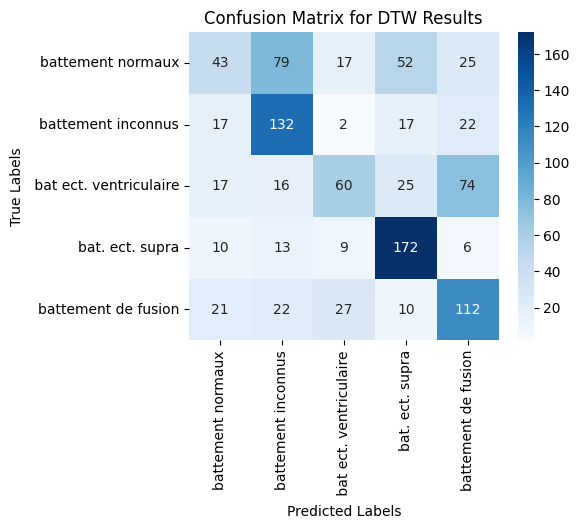

Accuracy du modèle DTW: 0.52
                         precision    recall  f1-score   support

      battement normaux       0.40      0.20      0.27       216
     battement inconnus       0.50      0.69      0.58       190
 bat ect. ventriculaire       0.52      0.31      0.39       192
        bat. ect. supra       0.62      0.82      0.71       210
    battement de fusion       0.47      0.58      0.52       192

               accuracy                           0.52      1000
              macro avg       0.50      0.52      0.49      1000
           weighted avg       0.50      0.52      0.49      1000



In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Calcul de la matrice de confusion
cm = confusion_matrix(PartitionDTW[:, 0], PartitionDTW[:, 1])

# Affichage de la matrice de confusion
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for DTW Results')
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(PartitionDTW[:, 0], PartitionDTW[:, 1])
print(f"Accuracy du modèle DTW: {accuracy:.2f}")

# Rapport de classification
print(classification_report(PartitionDTW[:, 0], PartitionDTW[:, 1], target_names=label_name))

**Evaluation :** A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

# Partie II : Classification des battements cardiaques sur les features sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

### Grid search - Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import RobustScaler

def grid_search_rf(data_features, labels, scaling=True):
    
    if scaling:
        scaler = RobustScaler()
        data_features = scaler.fit_transform(data_features)
       
    # Définition des hyperparamètres à tester
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    # Initialisation du modèle
    rf_clf = RandomForestClassifier(random_state=42)

    # GridSearchCV avec validation croisée
    grid_search = GridSearchCV(
        rf_clf,
        param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    # Exécution de la recherche
    grid_search.fit(data_features, labels)
    
    # Récupération des résultats sous forme de DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)

    print(f"✅ Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f"🎯 Meilleur score : {grid_search.best_score_}")

    return grid_search.best_estimator_, grid_search.best_score_, results_df


In [19]:
# %pip install scikit-learn

from sklearn.preprocessing import RobustScaler

data_dict = {
    "all": DataFeatureApp,
    "Temp": DataFeatureAppTemp,
    "Stat": DataFeatureAppStat,
    "Spec": DataFeatureAppSpec,
    "ECG": DataECGApp
}

best_models = {}
results_df = {}

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models[name+"_T"], acc, results_df[name+"_T"]  = grid_search_rf(data, LabelF_train)

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models[name+"_F"], acc, results_df[name+"_F"]  = grid_search_rf(data, LabelF_train, False)



🔍 Entraînement sur all features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🎯 Meilleur score : 0.9240018025495879

🔍 Entraînement sur Temp features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.891501548550556

🔍 Entraînement sur Stat features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.8757506093164972

🔍 Entraînement sur Spec features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_sam

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_accuracy_evolution(results_df, dataset_name, scaler_status):

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(results_df)), y=results_df['mean_test_score'], marker='o')

    plt.title(f"Évolution de l'Accuracy - {dataset_name} ({scaler_status})")
    plt.xlabel("Configurations Testées")
    plt.ylabel("Accuracy Moyenne")
    plt.grid(True)
    plt.show()


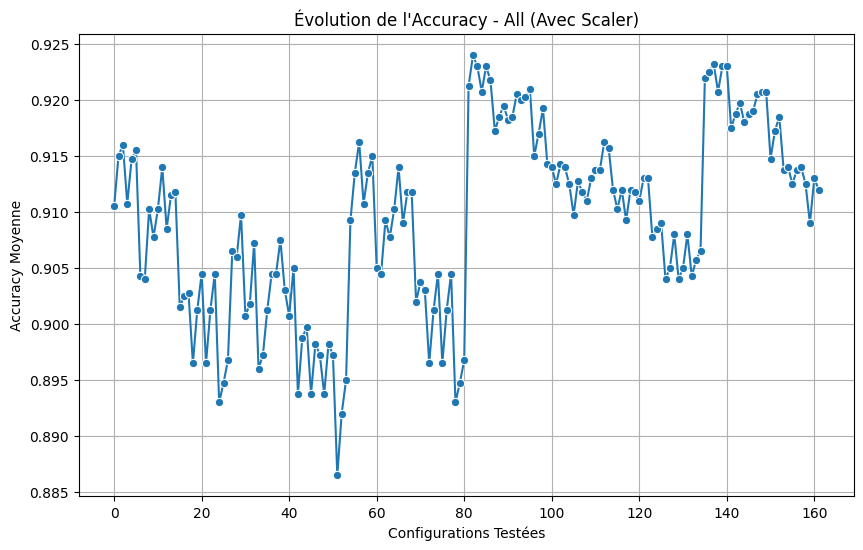

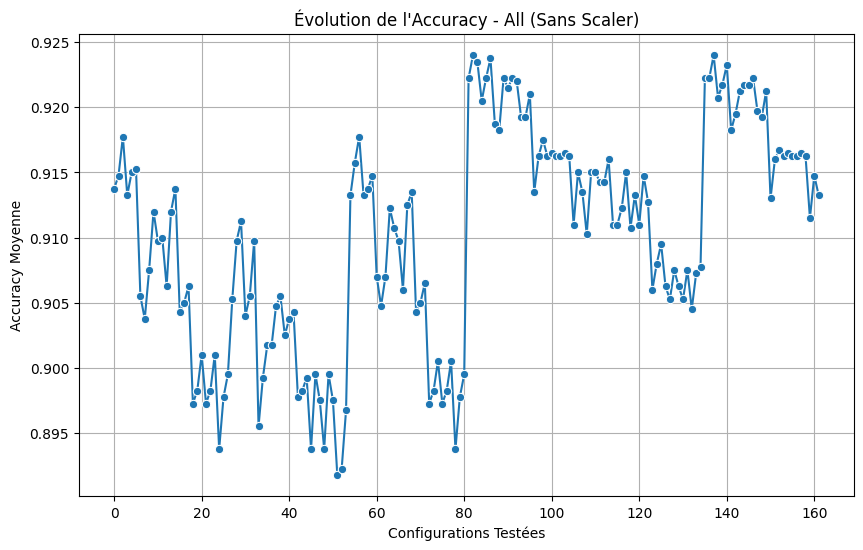

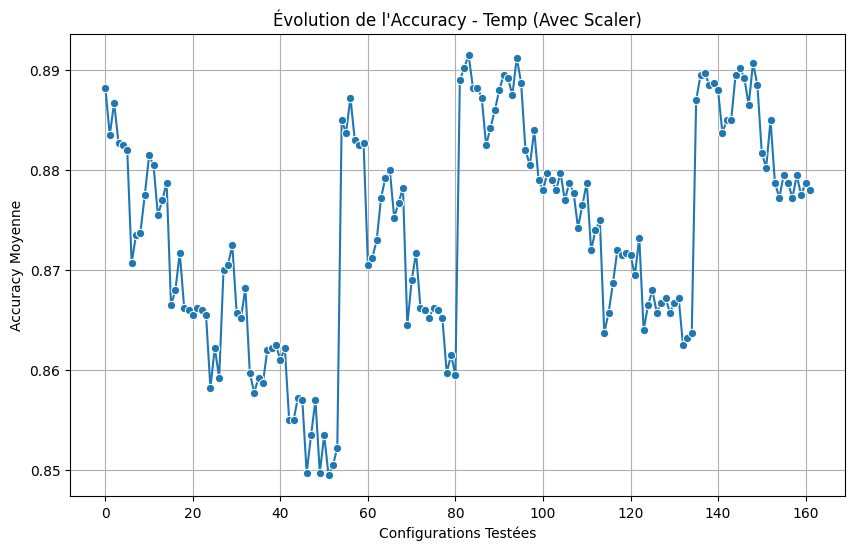

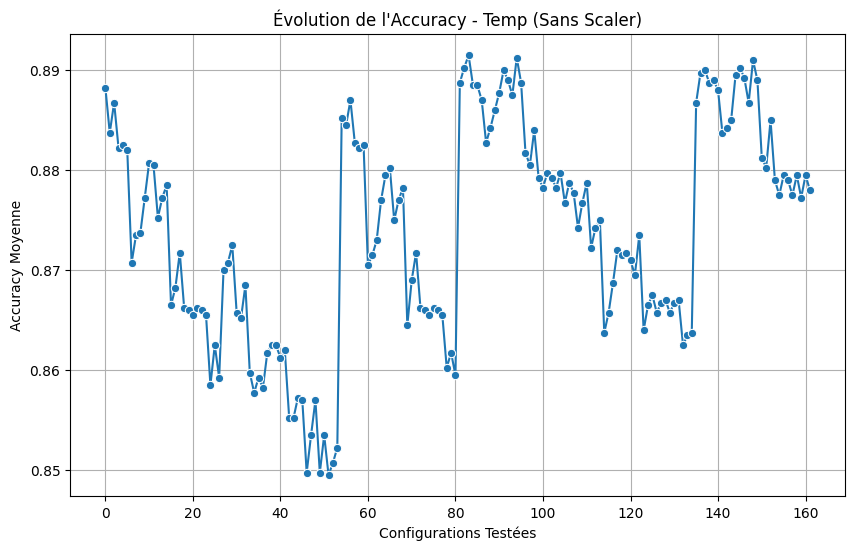

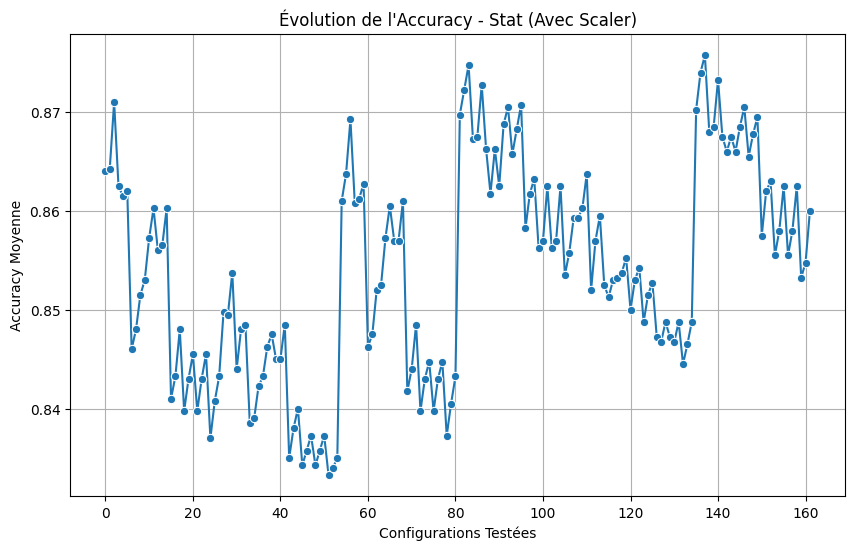

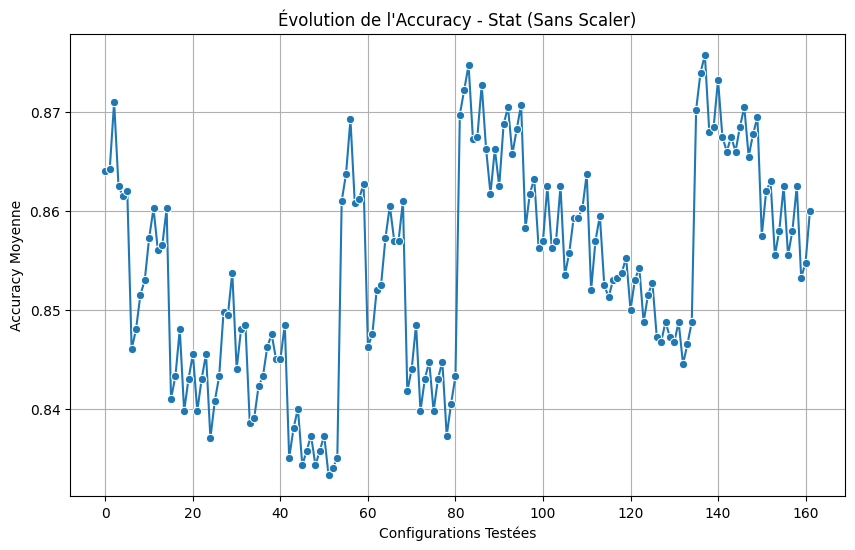

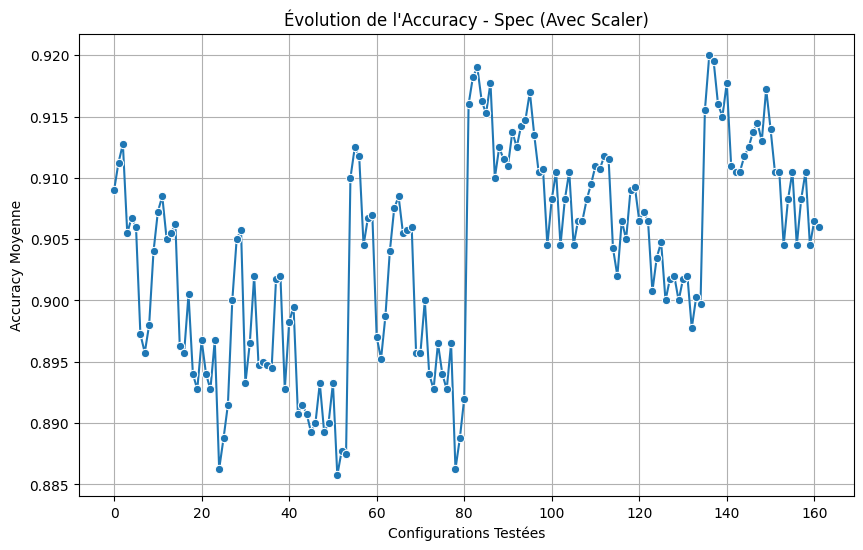

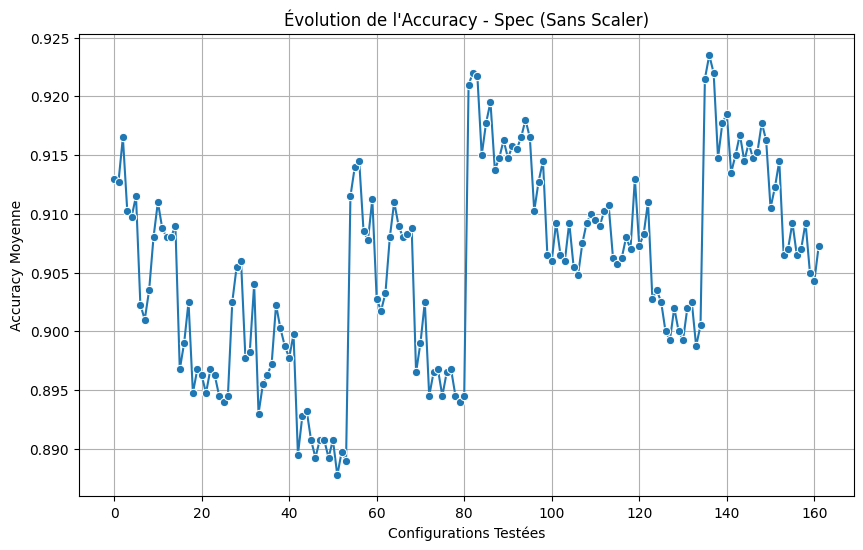

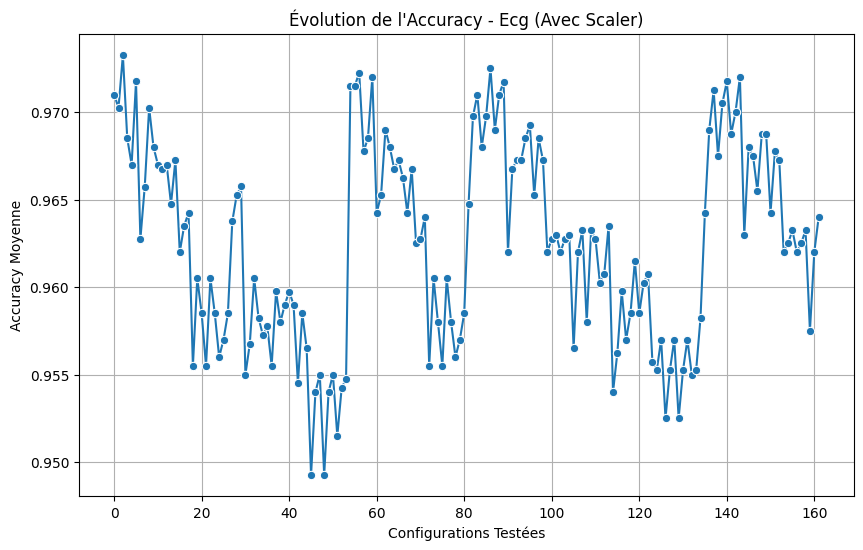

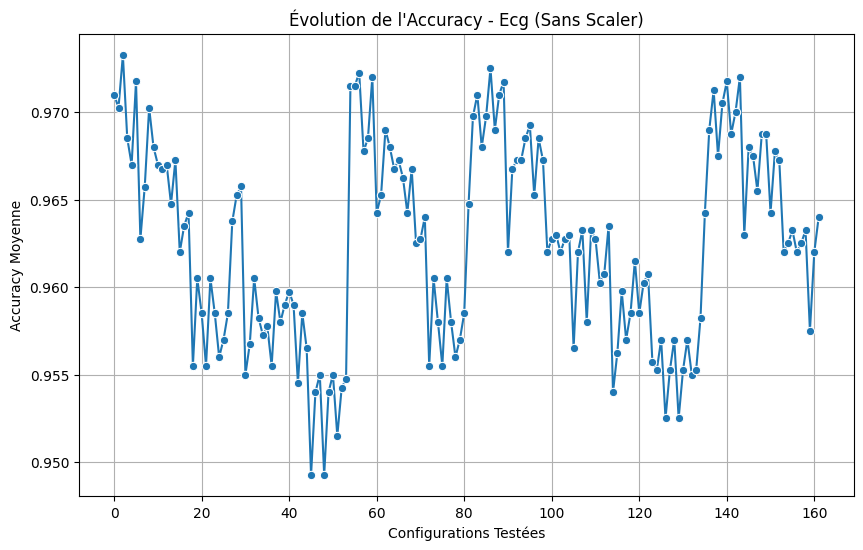

In [21]:
# Liste des types de données
data_types = ["all", "Temp", "Stat", "Spec", "ECG"]

# Générer des graphiques pour chaque type de données
for data_type in data_types:
    # Avec Scaler
    plot_accuracy_evolution(results_df[data_type + "_T"], data_type.capitalize(), "Avec Scaler")
    
    # Sans Scaler
    plot_accuracy_evolution(results_df[data_type + "_F"], data_type.capitalize(), "Sans Scaler")


### Random Forest

In [22]:
# méthode de classification supervisé
# Random Forest
# Initialiser et entraîner le modèle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def rf_model(best_model, X_test, y_test, scaling=True):

    if scaling:
        scalerR = RobustScaler()
        X_test = scalerR.fit_transform(X_test)

    # Prédictions sur les données de test
    y_pred = best_model.predict(X_test)

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f" Accuracy du modèle RandomForest : {accuracy}")
    return y_pred, accuracy



In [23]:
# Modèles avec toutes les données différentes

# Les modèles sont enregistré dans best_model

# Quand c'est False on a pas de scaling

# All features
print("\n All features : ")
y_pred_rf_all_T, accuracy_rf_all_T = rf_model(best_models["all_T"], DataFeatureTest, LabelF_test)
y_pred_rf_all_F, accuracy_rf_all_F = rf_model(best_models["all_F"], DataFeatureTest, LabelF_test, False)

# Temporel features
print("\n Temporel features : ")
y_pred_rf_Temp_T, accuracy_rf_Temp_T = rf_model(best_models["Temp_T"], DataFeatureTestTemp, LabelF_test)
y_pred_rf_Temp_F, accuracy_rf_Temp_F = rf_model(best_models["Temp_F"], DataFeatureTestTemp, LabelF_test, False)

# Statistic features
print("\n Statistic features : ")
y_pred_rf_Stat_T, accuracy_rf_Stat_T = rf_model(best_models["Stat_T"], DataFeatureTestStat, LabelF_test)
y_pred_rf_Stat_F, accuracy_rf_Stat_F = rf_model(best_models["Stat_F"], DataFeatureTestStat, LabelF_test, False)

# Spectral features
print("\n Spectral features : ")
y_pred_rf_Spec_T, accuracy_rf_Spec_T = rf_model(best_models["Spec_T"], DataFeatureTestSpec, LabelF_test)
y_pred_rf_Spec_F, accuracy_rf_Spec_F = rf_model(best_models["Spec_F"], DataFeatureTestSpec, LabelF_test, False)

# ECG sans features
print("\n ECG features : ")
y_pred_rf_ECG_T, accuracy_rf_ECG_T = rf_model(best_models["ECG_T"], DataECGTest, LabelF_test)
y_pred_rf_ECG_F, accuracy_rf_ECG_F = rf_model(best_models["ECG_F"], DataECGTest, LabelF_test, False)




 All features : 
 Accuracy du modèle RandomForest : 0.925
 Accuracy du modèle RandomForest : 0.933

 Temporel features : 
 Accuracy du modèle RandomForest : 0.888
 Accuracy du modèle RandomForest : 0.901

 Statistic features : 
 Accuracy du modèle RandomForest : 0.881
 Accuracy du modèle RandomForest : 0.888

 Spectral features : 
 Accuracy du modèle RandomForest : 0.914
 Accuracy du modèle RandomForest : 0.918

 ECG features : 
 Accuracy du modèle RandomForest : 0.807
 Accuracy du modèle RandomForest : 0.977


### Grid search KNN

In [24]:
# Grid search pour trouver les meilleurs paramètres pour notre KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def grid_search_knn(data_features, labels, scaling=True):
    
    if scaling:
        scaler = RobustScaler()
        data_features = scaler.fit_transform(data_features)
        
    # Définition du modèle
    knn = KNeighborsClassifier()
    
    # Définition de la grille de recherche
    param_grid = {
        "n_neighbors": [1, 3, 5, 7, 10, 15, 20],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    }
    
    # Initialisation de GridSearchCV
    grid_search_knn = GridSearchCV(
        knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )
    
    # Exécution de GridSearchCV
    grid_search_knn.fit(data_features, labels)
    
    results_df = pd.DataFrame(grid_search_knn.cv_results_)
    
    print("Meilleurs hyperparamètres :", grid_search_knn.best_params_)
    print("Meilleur score :", grid_search_knn.best_score_)
    
    return grid_search_knn.best_estimator_, grid_search_knn.best_score_, results_df
    


In [25]:
data_dict = {
    "all": DataFeatureApp,
    "Temp": DataFeatureAppTemp,
    "Stat": DataFeatureAppStat,
    "Spec": DataFeatureAppSpec,
    "ECG": DataECGApp
}

best_models_knn = {}
results_df= {}

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models_knn[name+"_T"], acc,results_df[name+"_T"] = grid_search_knn(data, LabelF_train)

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models_knn[name+"_F"], acc ,results_df[name+"_F"] = grid_search_knn(data, LabelF_train, False)


🔍 Entraînement sur all features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.9245000000000001

🔍 Entraînement sur Temp features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.8949999999999999

🔍 Entraînement sur Stat features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Meilleur score : 0.866

🔍 Entraînement sur Spec features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.9189999999999999

🔍 Entraînement sur ECG features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleu

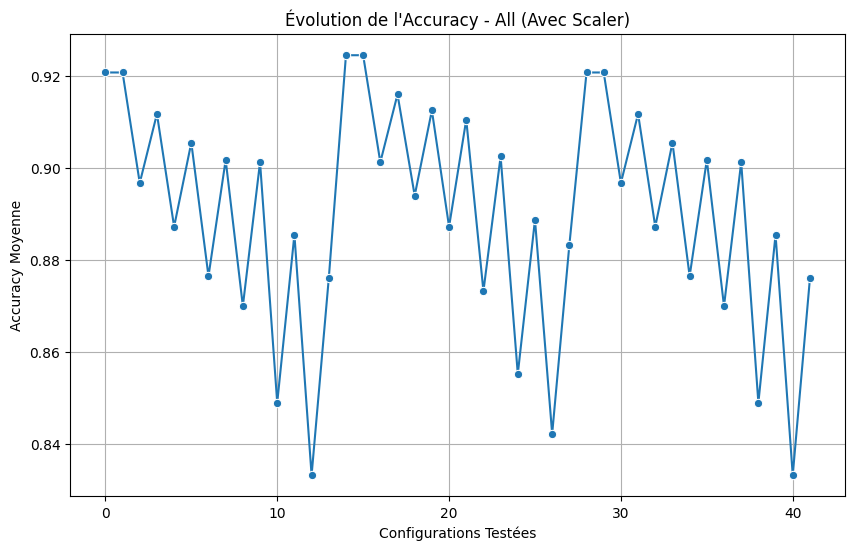

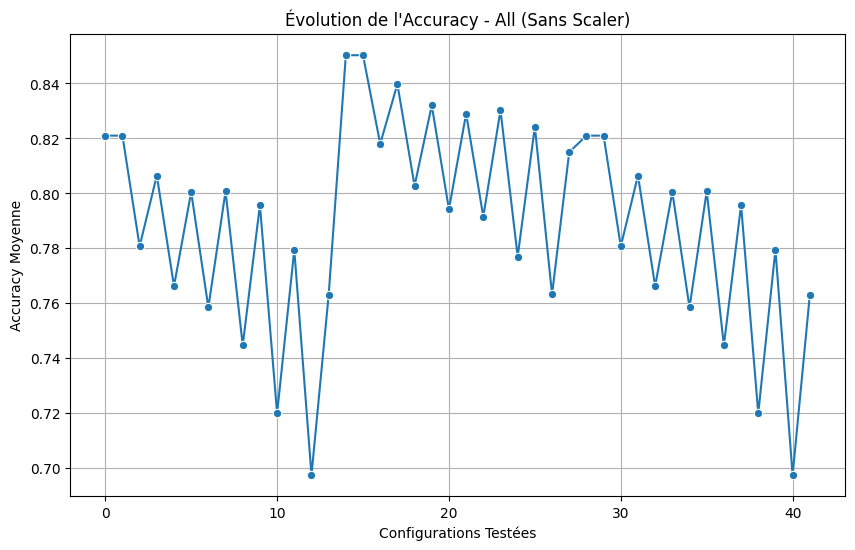

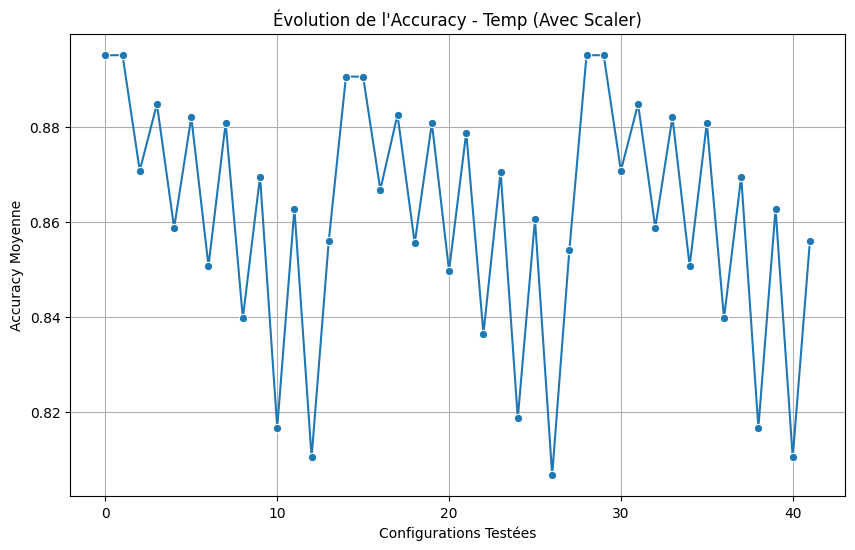

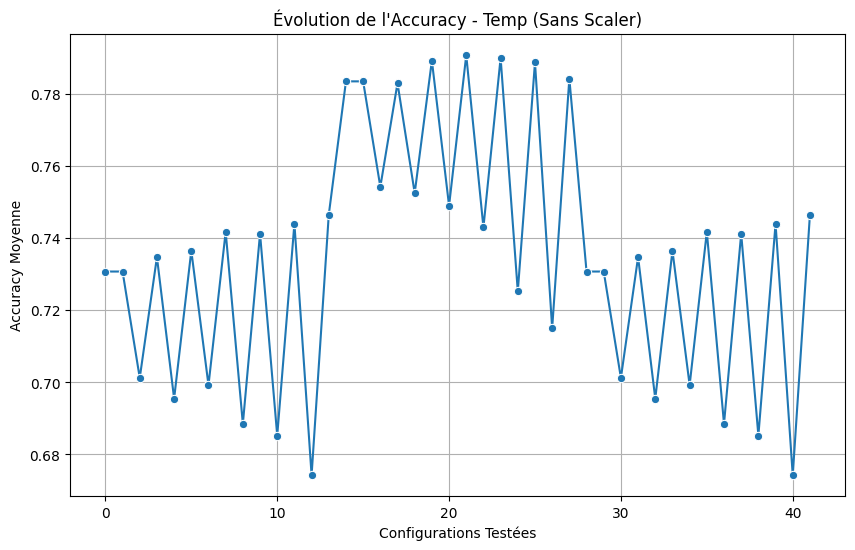

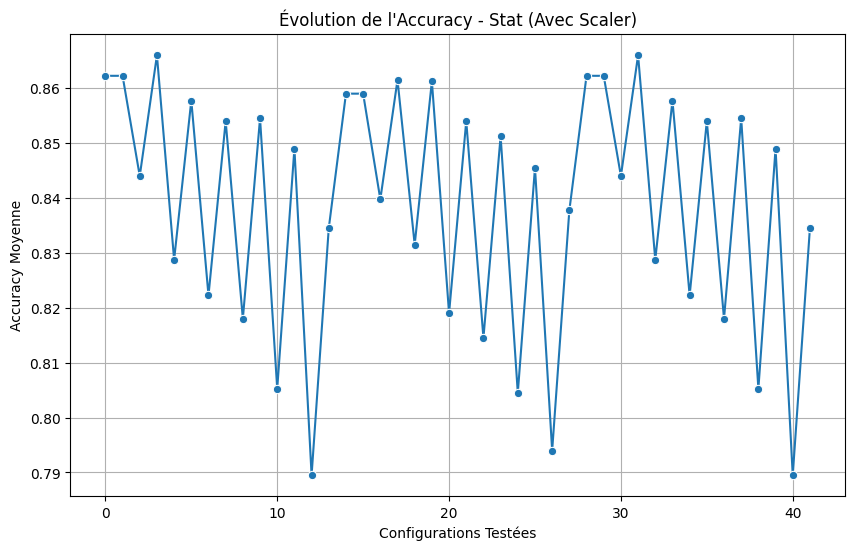

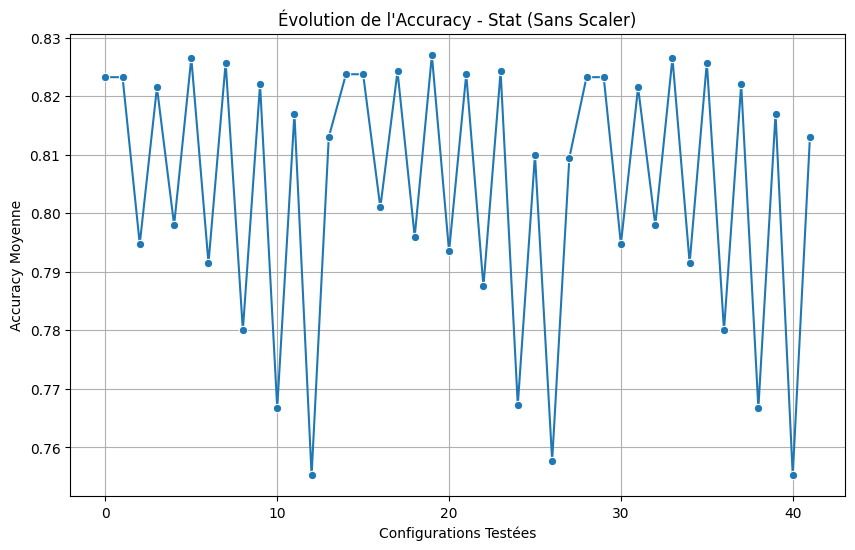

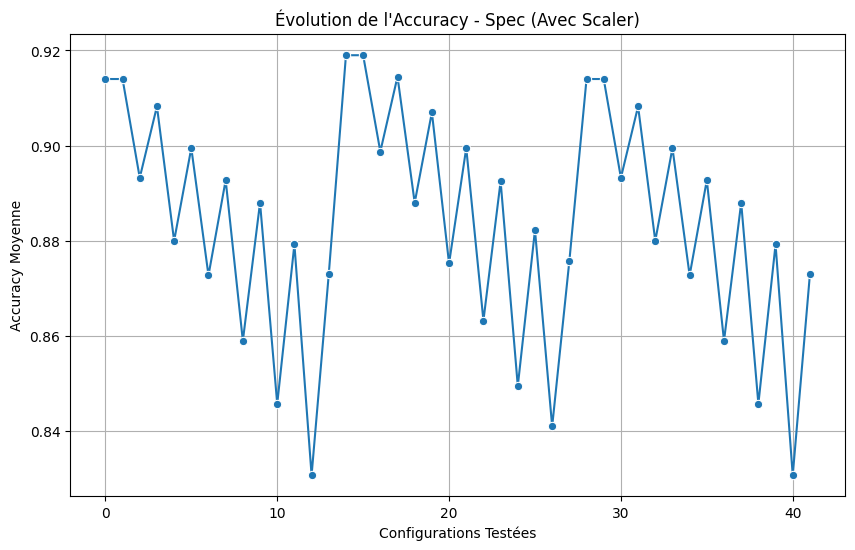

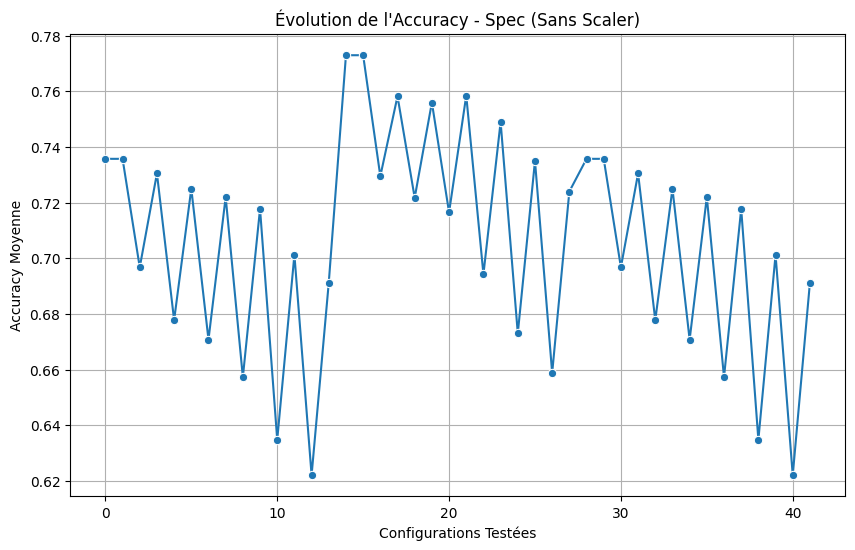

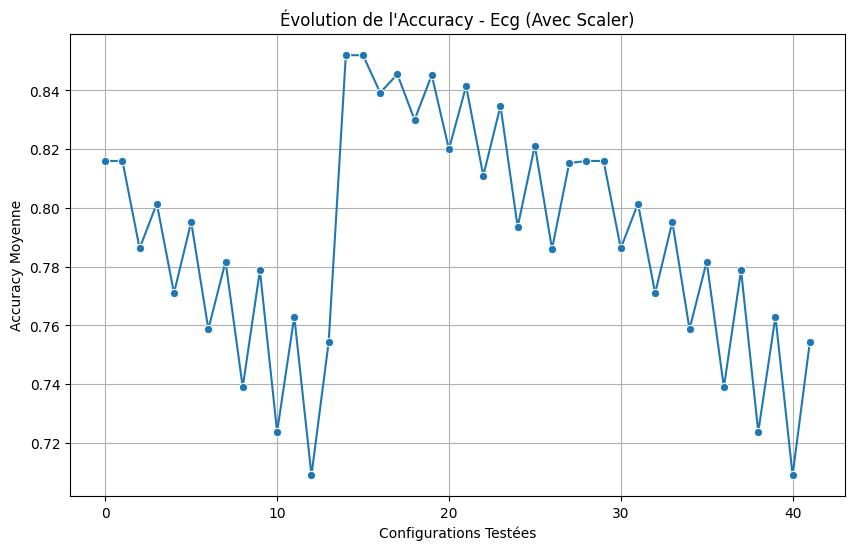

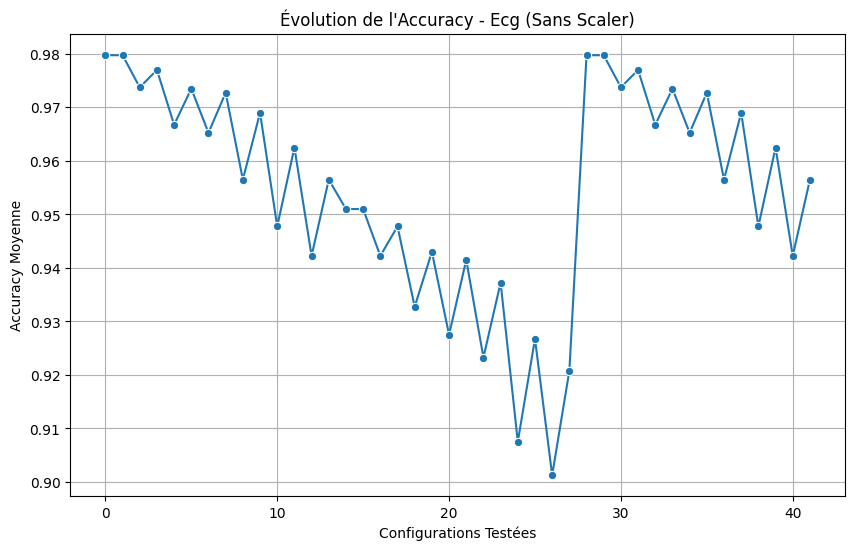

In [26]:
# Liste des types de données
data_types = ["all", "Temp", "Stat", "Spec", "ECG"]

# Générer des graphiques pour chaque type de données
for data_type in data_types:
    # Avec Scaler
    plot_accuracy_evolution(results_df[data_type + "_T"], data_type.capitalize(), "Avec Scaler")
    
    # Sans Scaler
    plot_accuracy_evolution(results_df[data_type + "_F"], data_type.capitalize(), "Sans Scaler")

### KNN

In [27]:
# k-Nearest Neighbors
# méthode de classification supervisé

from sklearn.neighbors import KNeighborsClassifier
def knn_model(model,  X_test, y_test, scaling=True):
    if scaling:
        scalerR = RobustScaler()
        X_test = scaler.fit_transform(X_test)
        
    # Prédictions sur les données de test
    y_pred = model.predict(X_test)

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"🏆 Accuracy du modèle knn : {accuracy}")
    return y_pred, accuracy
    
    

In [28]:
# Les modèles sont enregistrés dans best_model

# All features
y_pred_knn_all_T, accuracy_knn_all_T = knn_model(best_models_knn["all_T"], DataFeatureTest, LabelF_test)
y_pred_knn_all_F, accuracy_knn_all_F = knn_model(best_models_knn["all_F"], DataFeatureTest, LabelF_test, False)

# Temporel features
y_pred_knn_Temp_T, accuracy_knn_Temp_T = knn_model(best_models_knn["Temp_T"], DataFeatureTestTemp, LabelF_test)
y_pred_knn_Temp_F, accuracy_knn_Temp_F = knn_model(best_models_knn["Temp_F"], DataFeatureTestTemp, LabelF_test, False)

# Statistic features
y_pred_knn_Stat_T, accuracy_knn_Stat_T = knn_model(best_models_knn["Stat_T"], DataFeatureTestStat, LabelF_test)
y_pred_knn_Stat_F, accuracy_knn_Stat_F = knn_model(best_models_knn["Stat_F"], DataFeatureTestStat, LabelF_test, False)

# Spectral features
y_pred_knn_Spec_T, accuracy_knn_Spec_T = knn_model(best_models_knn["Spec_T"], DataFeatureTestSpec, LabelF_test)
y_pred_knn_Spec_F, accuracy_knn_Spec_F = knn_model(best_models_knn["Spec_F"], DataFeatureTestSpec, LabelF_test, False)

# ECG sans features
y_pred_knn_ECG_T, accuracy_knn_ECG_T = knn_model(best_models_knn["ECG_T"], DataECGTest, LabelF_test)
y_pred_knn_ECG_F, accuracy_knn_ECG_F = knn_model(best_models_knn["ECG_F"], DataECGTest, LabelF_test, False)


🏆 Accuracy du modèle knn : 0.885
🏆 Accuracy du modèle knn : 0.858
🏆 Accuracy du modèle knn : 0.809
🏆 Accuracy du modèle knn : 0.802
🏆 Accuracy du modèle knn : 0.821
🏆 Accuracy du modèle knn : 0.849
🏆 Accuracy du modèle knn : 0.873
🏆 Accuracy du modèle knn : 0.775
🏆 Accuracy du modèle knn : 0.764
🏆 Accuracy du modèle knn : 0.987


In [29]:
from sklearn.metrics import confusion_matrix


# Random Forest
conf_matrix_rf_all_T = confusion_matrix(LabelF_test, y_pred_rf_all_T)
conf_matrix_rf_all_F = confusion_matrix(LabelF_test, y_pred_rf_all_F)

conf_matrix_rf_Temp_T = confusion_matrix(LabelF_test, y_pred_rf_Temp_T)
conf_matrix_rf_Temp_F = confusion_matrix(LabelF_test, y_pred_rf_Temp_F)

conf_matrix_rf_Spec_T = confusion_matrix(LabelF_test, y_pred_rf_Spec_T)
conf_matrix_rf_Spec_F = confusion_matrix(LabelF_test, y_pred_rf_Spec_F)

conf_matrix_rf_Stat_T = confusion_matrix(LabelF_test, y_pred_rf_Stat_T)
conf_matrix_rf_Stat_F = confusion_matrix(LabelF_test, y_pred_rf_Stat_F)

conf_matrix_rf_ECG_T = confusion_matrix(LabelF_test, y_pred_rf_ECG_T)
conf_matrix_rf_ECG_F = confusion_matrix(LabelF_test, y_pred_rf_ECG_F)



# KNN

conf_matrix_knn_all_T = confusion_matrix(LabelF_test, y_pred_knn_all_T)
conf_matrix_knn_all_F = confusion_matrix(LabelF_test, y_pred_knn_all_F)

conf_matrix_knn_Temp_T = confusion_matrix(LabelF_test, y_pred_knn_Temp_T)
conf_matrix_knn_Temp_F = confusion_matrix(LabelF_test, y_pred_knn_Temp_F)

conf_matrix_knn_Spec_T = confusion_matrix(LabelF_test, y_pred_knn_Spec_T)
conf_matrix_knn_Spec_F = confusion_matrix(LabelF_test, y_pred_knn_Spec_F)

conf_matrix_knn_Stat_T = confusion_matrix(LabelF_test, y_pred_knn_Stat_T)
conf_matrix_knn_Stat_F = confusion_matrix(LabelF_test, y_pred_knn_Stat_F)

conf_matrix_knn_ECG_T = confusion_matrix(LabelF_test, y_pred_knn_ECG_T)
conf_matrix_knn_ECG_F = confusion_matrix(LabelF_test, y_pred_knn_ECG_F)



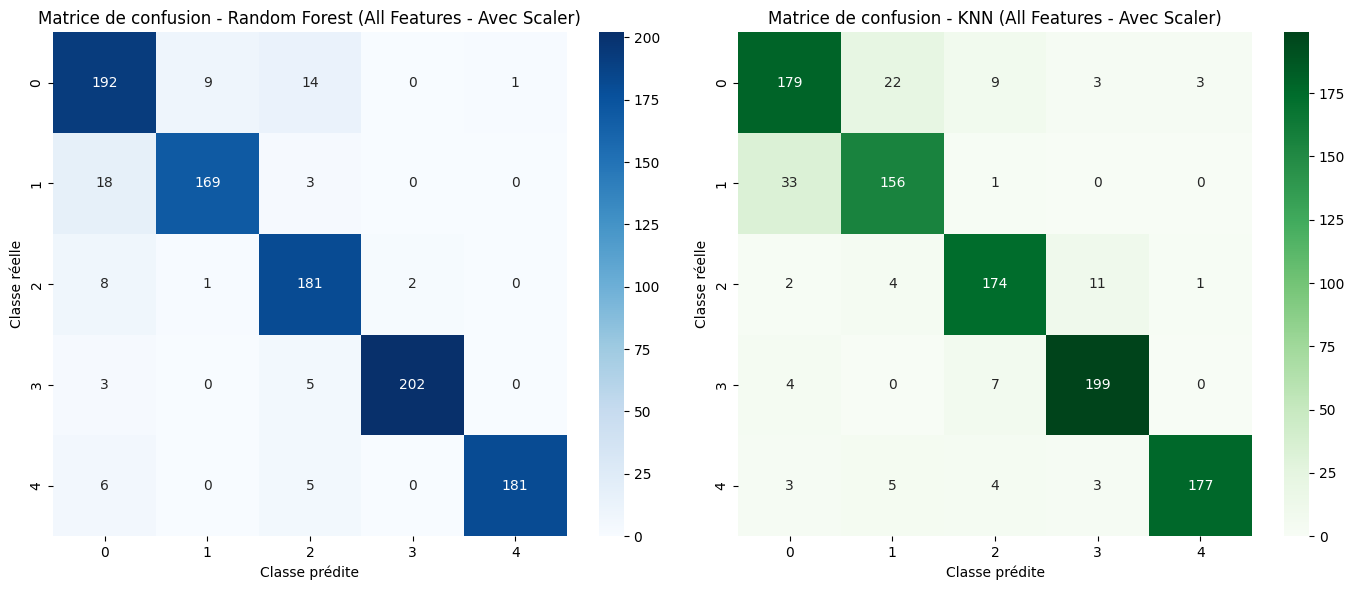

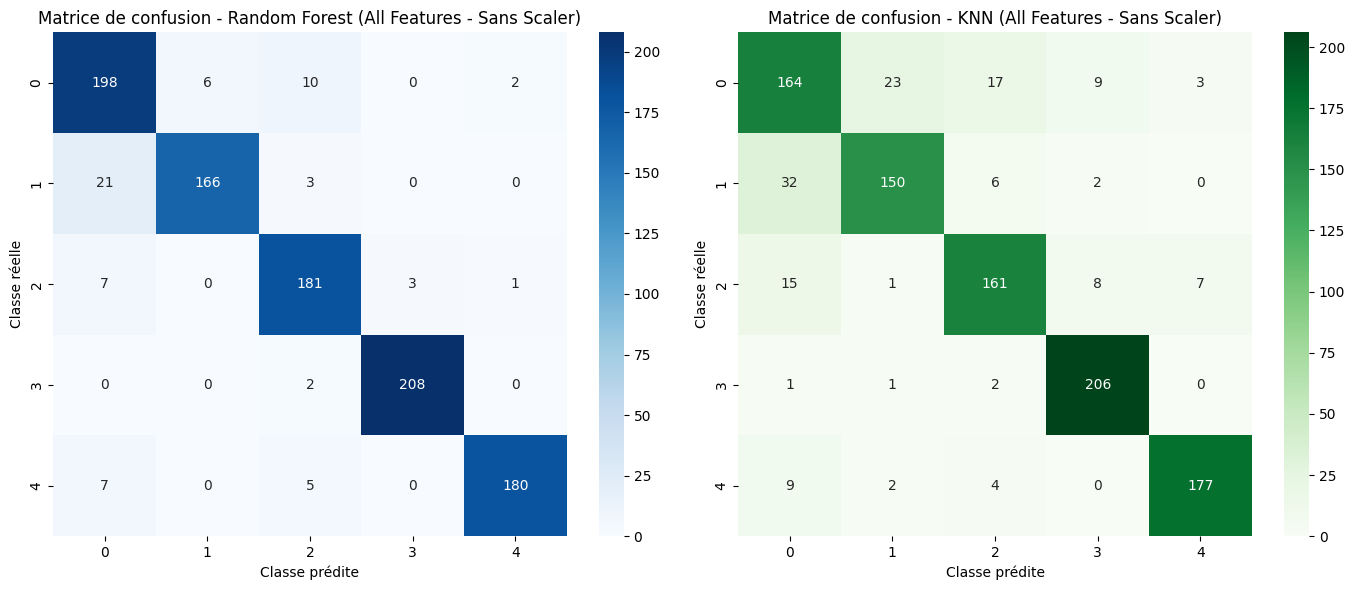

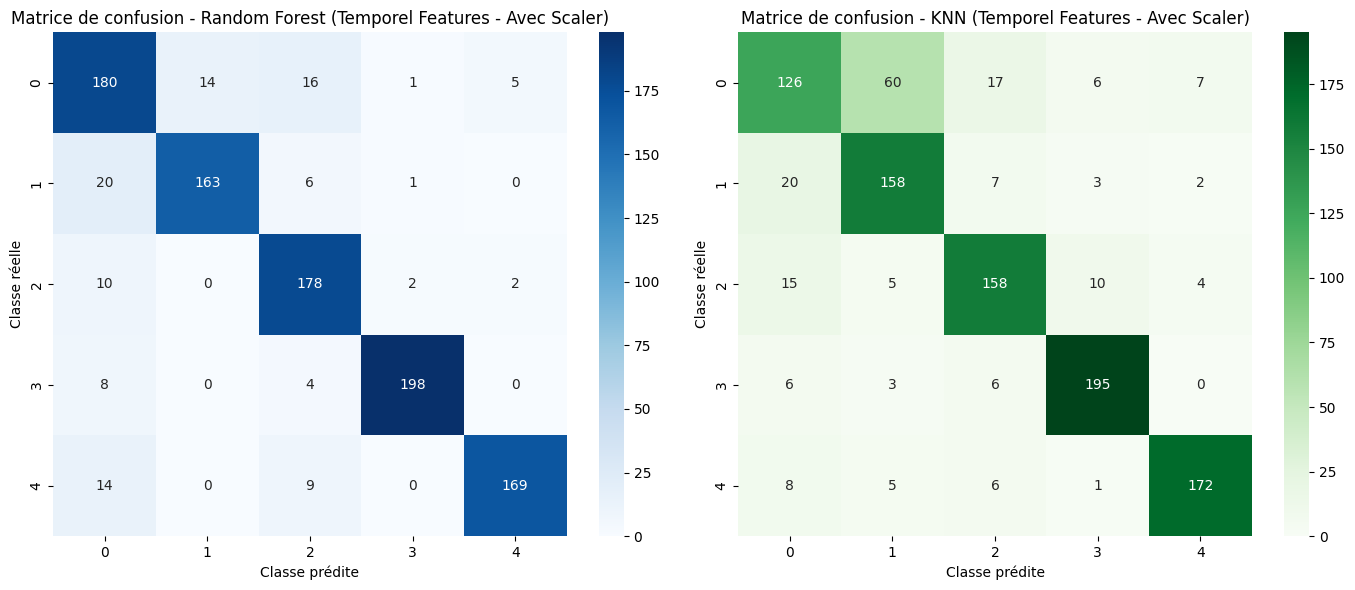

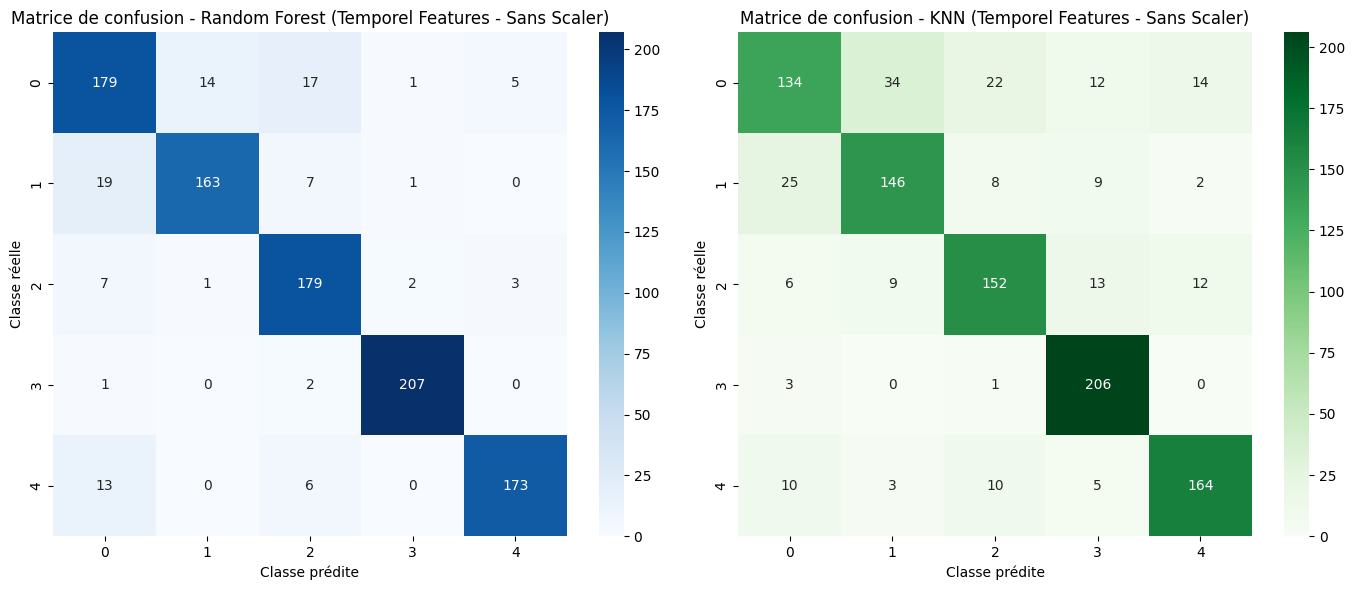

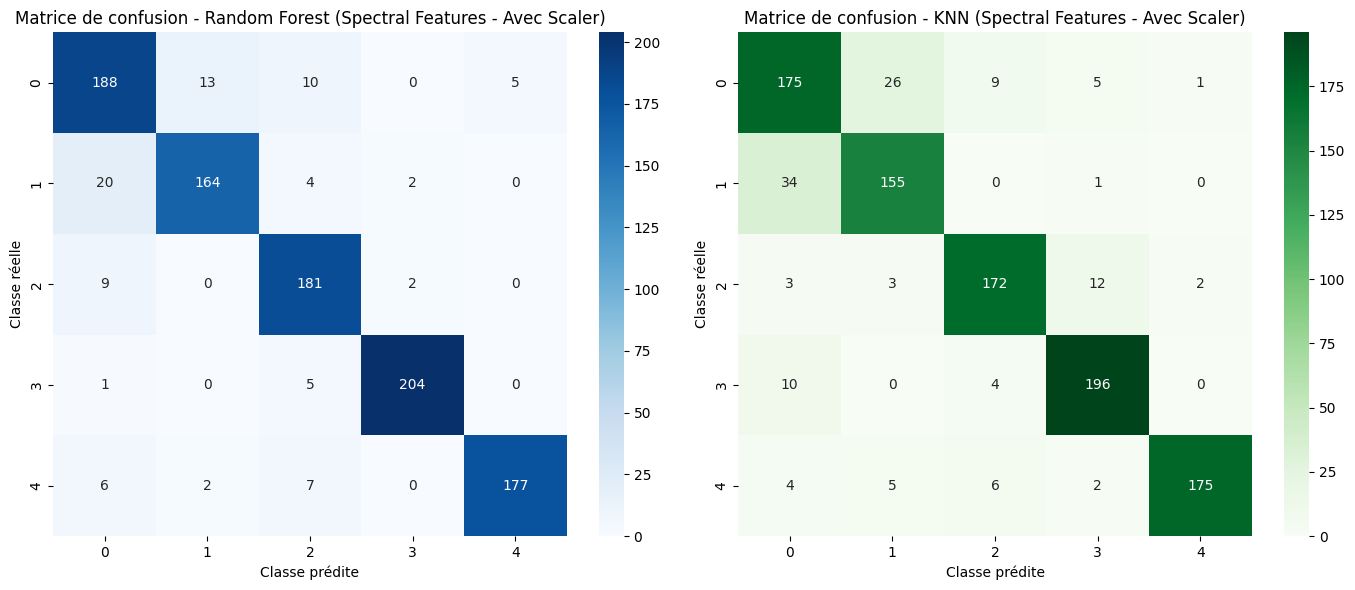

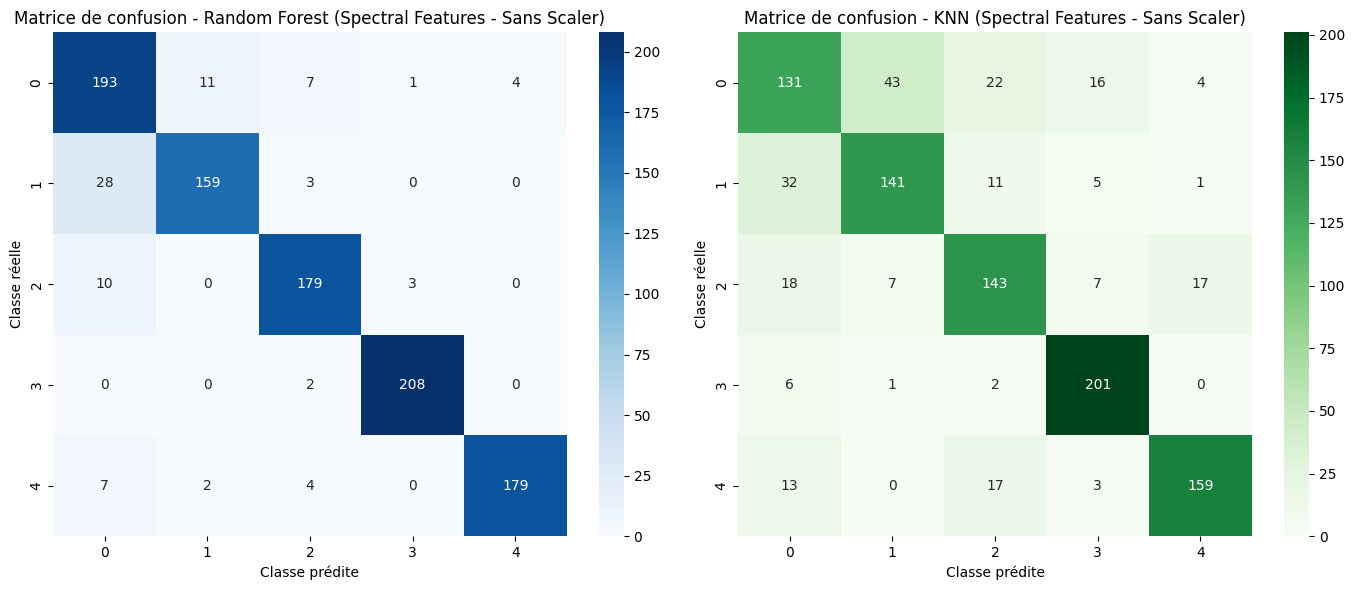

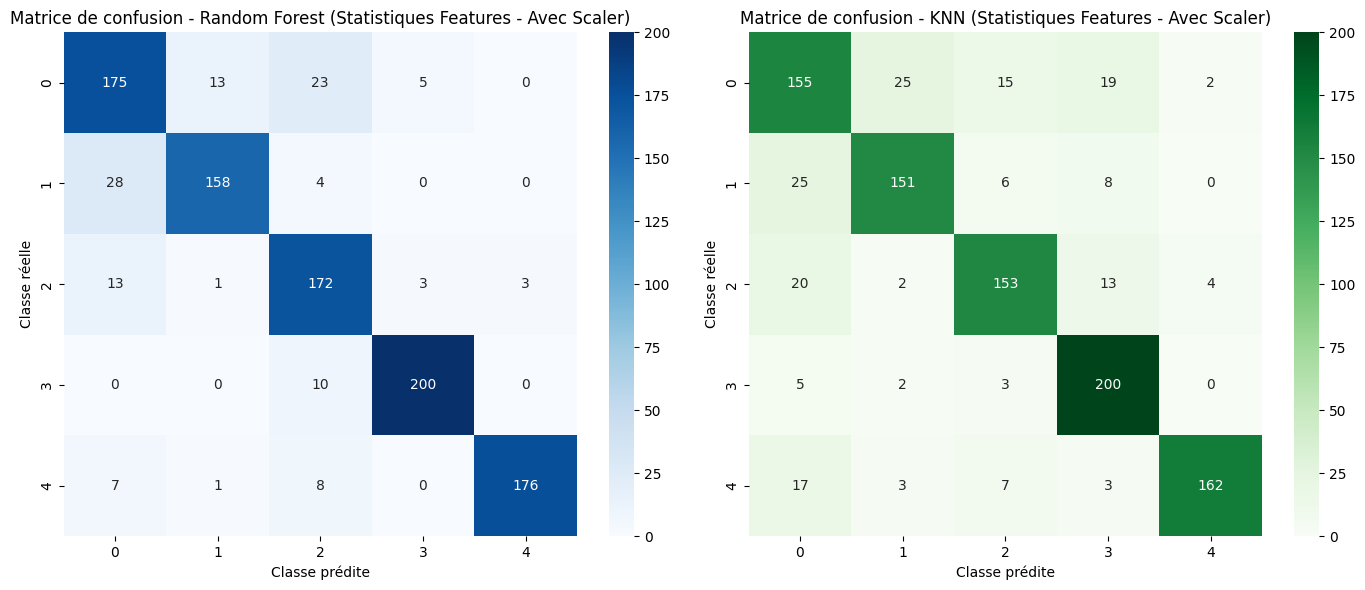

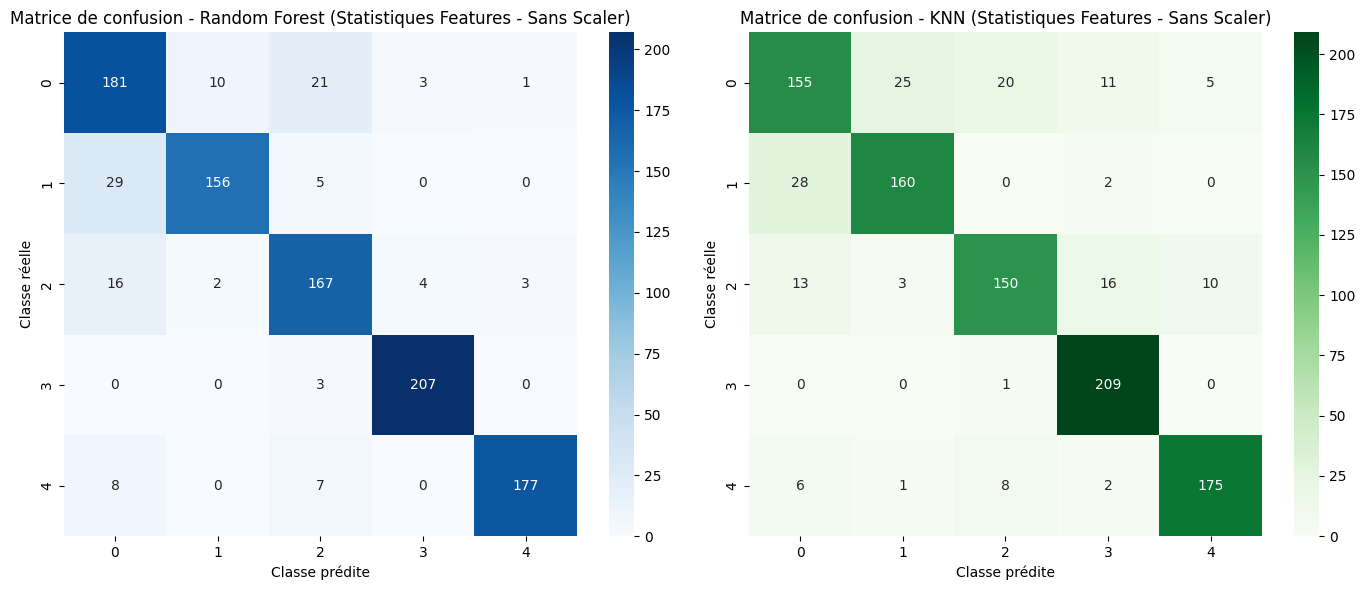

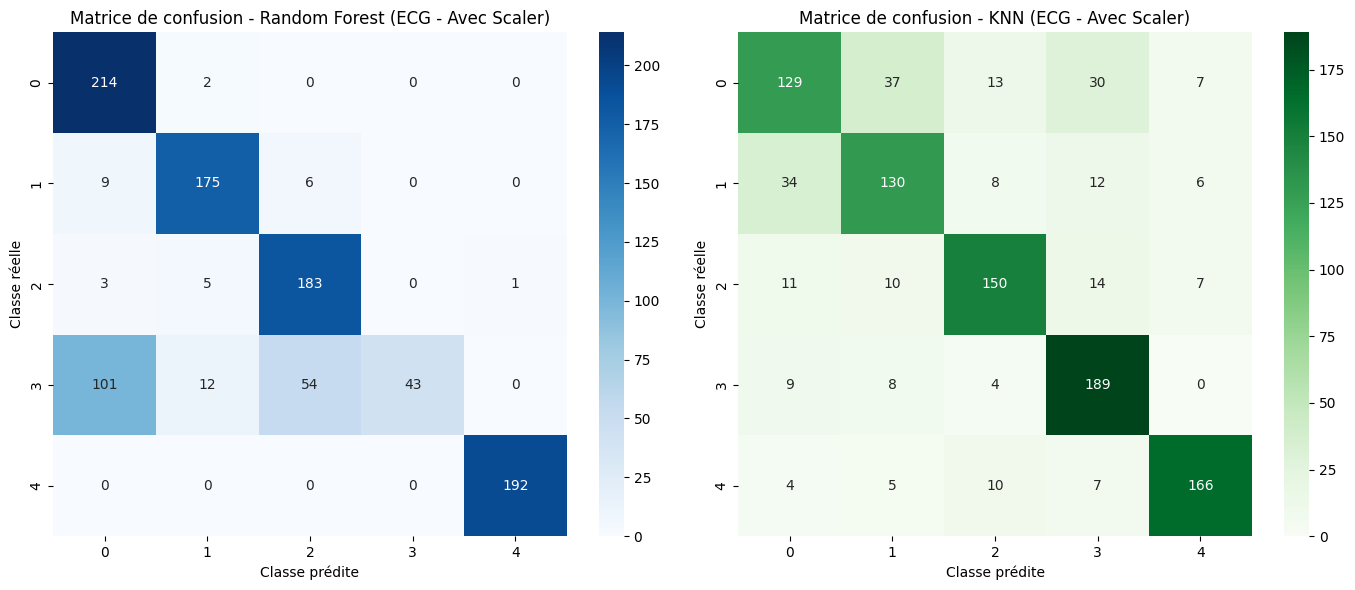

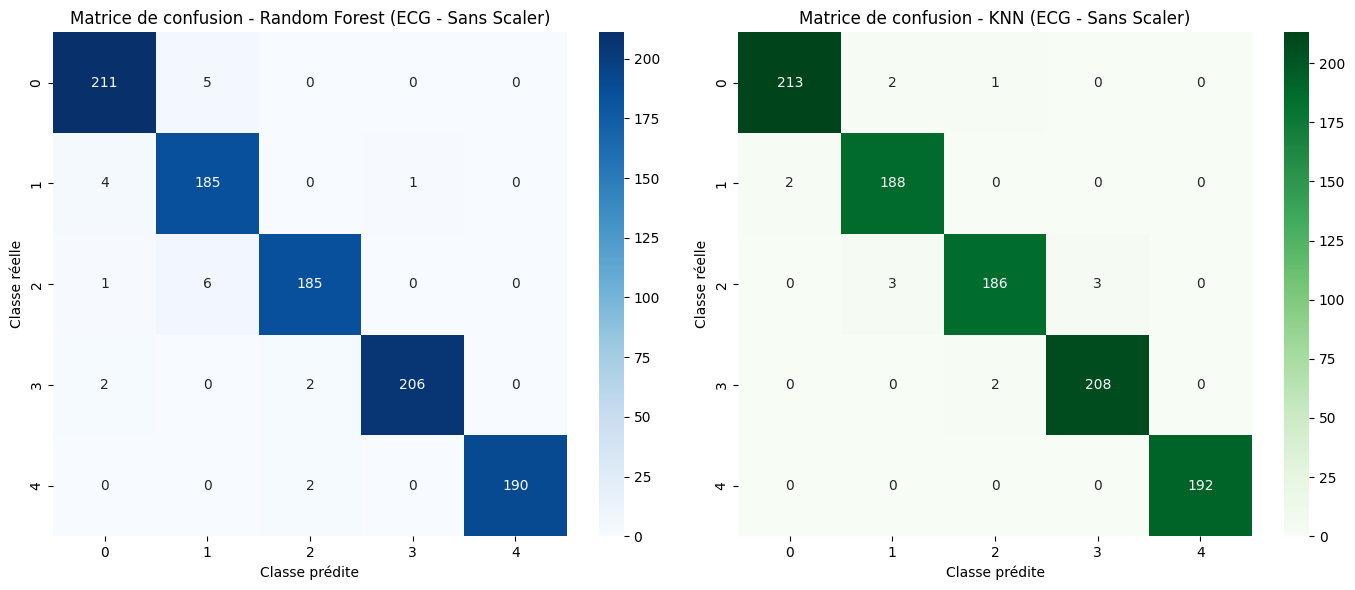

In [30]:
# Display matrice de confusion

def display_matrix_s(m1, m2, title):
    plt.figure(figsize=(14, 6))
    
    # Matrice Random Forest
    plt.subplot(1, 2, 1)
    sns.heatmap(m1, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - Random Forest ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    # Matrice KNN
    plt.subplot(1, 2, 2)
    sns.heatmap(m2, annot=True, fmt="d", cmap="Greens")
    plt.title(f"Matrice de confusion - KNN ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    plt.tight_layout()
    plt.show()


# Appels de la fonction avec les bonnes matrices et titres
display_matrix_s(conf_matrix_rf_all_T, conf_matrix_knn_all_T, "All Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_all_F, conf_matrix_knn_all_F, "All Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Temp_T, conf_matrix_knn_Temp_T, "Temporel Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Temp_F, conf_matrix_knn_Temp_F, "Temporel Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Spec_T, conf_matrix_knn_Spec_T, "Spectral Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Spec_F, conf_matrix_knn_Spec_F, "Spectral Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Stat_T, conf_matrix_knn_Stat_T, "Statistiques Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Stat_F, conf_matrix_knn_Stat_F, "Statistiques Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_ECG_T, conf_matrix_knn_ECG_T, "ECG - Avec Scaler")
display_matrix_s(conf_matrix_rf_ECG_F, conf_matrix_knn_ECG_F, "ECG - Sans Scaler")


## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.  
 <b>Kmeans</b> et <b>Clustering Hierarchique</b>

### Score matrice de confusion

In [31]:
def conf_matrix_score(LabelF_train,y_pred):
    """
    Calcule le score d'une matrice de confusion.
    Le score est défini comme la somme des bonnes classifications par ligne divisées par le total de la ligne.
    fonction de score assez basique mais utile pour le réglage des hyper paramètres à partir
    des matrices de confusion
    """
    LabelF_train1 = LabelF_train.astype(int)

    # Conversion des clusters en labels réels
    #y_pred_labels_temp = correspondance(y_pred, LabelF_train1) #fonction de la prof
    y_pred_labels_temp = true_labels(y_pred, LabelF_train1)
    
    conf_matrix = confusion_matrix(LabelF_train, y_pred_labels_temp)
    
    score = 0
    for i in range(conf_matrix.shape[0]):
        total_in_row = np.sum(conf_matrix[i, :])
        if total_in_row > 0:
            score += conf_matrix[i, i] / total_in_row
    
    return (score / conf_matrix.shape[0])

In [32]:
import matplotlib.pyplot as plt

def plot_accuracy(scores, title="Évolution du Score d'Accuracy", xlabel="Itérations", ylabel="Accuracy"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.show()


### Kmeans recherche des meilleurs hyperparamètres

In [33]:
# Recherche des meilleurs hyperparametres
# Cette cellule doit être skip car longue à s'executer et pas necessaire pour la suite 
# car les modèles sont définit en dur dans les cellules suivantes

#%%skip

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def hyper_search_kmeans(data_features):
    # Normalisation Min-Max (valeurs entre 0 et 1)
    scalerM = MinMaxScaler()
    DataFeatureApp_scaledM = scalerM.fit_transform(data_features)
    
    # Normalisation robuste (élimine l'effet des outliers)
    scalerR = RobustScaler()
    DataFeatureApp_scaledR = scalerR.fit_transform(data_features)
    
    # Normalisation Standard
    scalerS = StandardScaler()
    DataFeatureApp_scaledS = scalerS.fit_transform(data_features) 
    
    # Hyperparamètres
    param_grid = {
        "init": ["k-means++", "random"],
        "n_init": [10, 20, 30],
        "max_iter": [300, 500, 1000],
        "algorithm": ["lloyd", "elkan"],
        "tol": [1e-3, 1e-4, 1e-5],
        "data": {
           "RobustScaler": DataFeatureApp_scaledR,
            "StandardScaler" : DataFeatureApp_scaledS, 
            "MinMaxScaler" : DataFeatureApp_scaledM,
            "dataWithoutScale":data_features
        }
        
    }
    
    # Initialisation des meilleures valeurs
    best_confmatrix = 0
    best_params = {}
    score_l = []
    
    # Teste des hyperparamètres
    for init in param_grid["init"]:
        for n_init in param_grid["n_init"]:
            for max_iter in param_grid["max_iter"]:
                for algorithm in param_grid["algorithm"]:
                    for tol in param_grid["tol"]: 
                        for scaler_name, data in param_grid["data"].items():
                            
                            # Création et entraînement du modèle K-Means
                            kmeans = KMeans(
                                n_clusters=5, init=init, n_init=n_init, 
                                max_iter=max_iter, algorithm=algorithm, 
                                tol=tol, random_state=42
                            )
    
                            
                            y_pred_km = kmeans.fit_predict(data)
                                
    
                            score_matrix = conf_matrix_score(LabelF_train, y_pred_km )
                            score_l.append(score_matrix)
    
                            # Mise à jour paramètres
                            if score_matrix > best_confmatrix:
                                best_confmatrix = score_matrix
                                best_params = {
                                    "init": init,
                                    "n_init": n_init,
                                    "max_iter": max_iter,
                                    "algorithm": algorithm,
                                    "tol": tol,
                                    "data":scaler_name
                                }
    
    # Affichage best paramètres
    print(f"\n Meilleurs paramètres trouvés : {best_params} \n et meilleur score : {best_confmatrix}")
    return score_l


🔍 Entraînement sur All features

 Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.0001, 'data': 'MinMaxScaler'} 
 et meilleur score : 0.4829192978570512
🔍 Entraînement sur Temporel features

 Meilleurs paramètres trouvés : {'init': 'random', 'n_init': 20, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'RobustScaler'} 
 et meilleur score : 0.5181943920661476
🔍 Entraînement sur Statistic features

 Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.0001, 'data': 'MinMaxScaler'} 
 et meilleur score : 0.5422766076300503
🔍 Entraînement sur Spectral features

 Meilleurs paramètres trouvés : {'init': 'random', 'n_init': 20, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'RobustScaler'} 
 et meilleur score : 0.505802296804496
🔍 Entraînement sur ECG

 Meilleurs paramètres trouvés : {'init': 'random', 'n_init': 30, 'max_iter': 300, 'algori

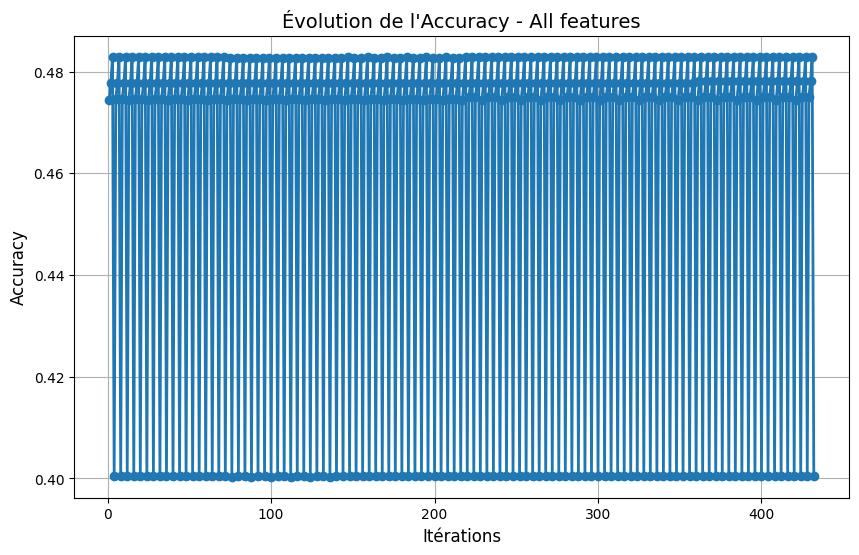

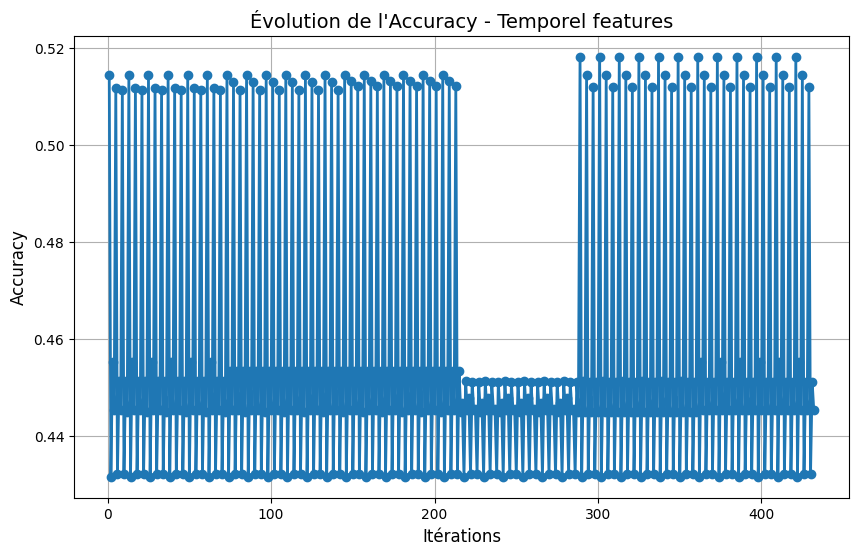

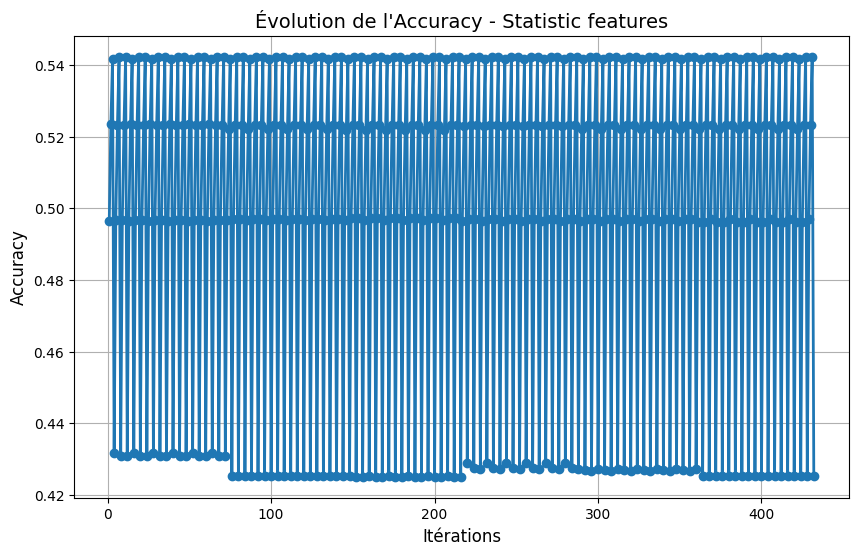

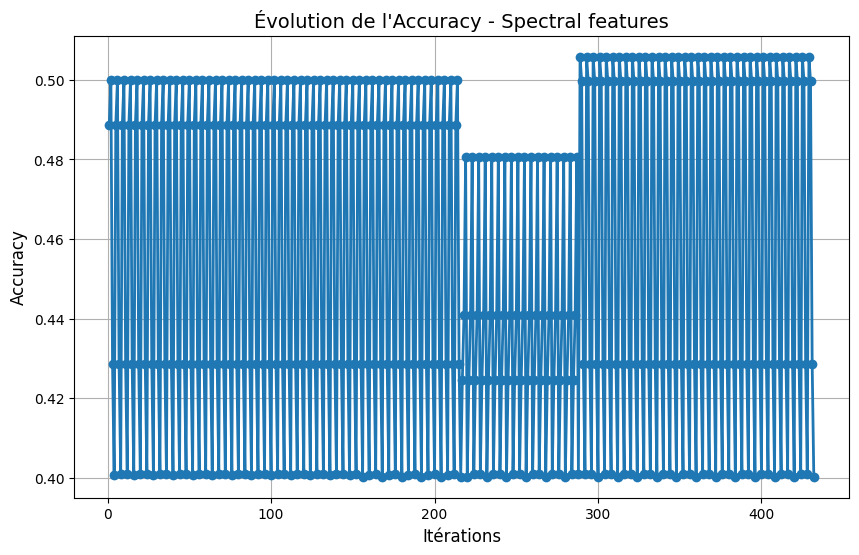

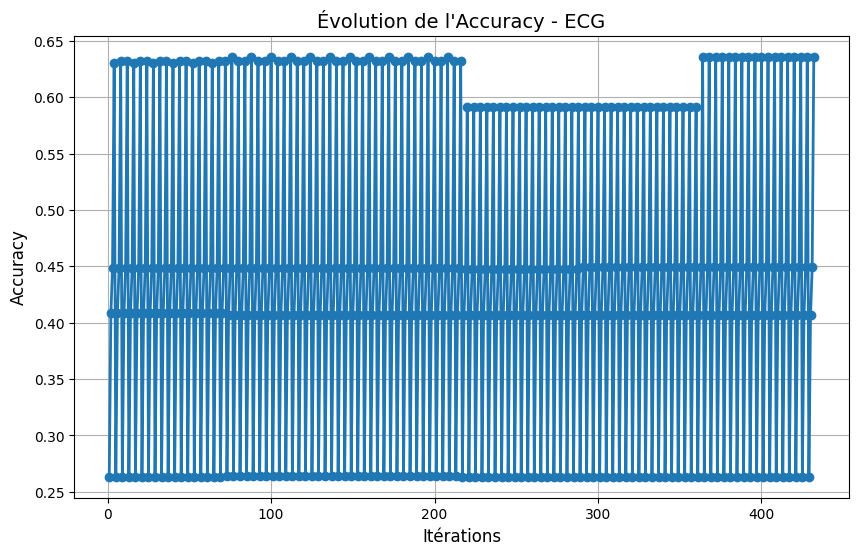

In [34]:
#%%skip
# Obtenir les meilleurs hyperparametres pour chaque type de données

score_list_km = {}
dataList = {
           "All features": DataFeatureApp,
            "Temporel features" : DataFeatureAppTemp, 
            "Statistic features" : DataFeatureAppStat,
            "Spectral features":DataFeatureAppSpec,
            "ECG": DataECGApp
        }
for scaler_name, data in dataList.items():
    print(f"🔍 Entraînement sur {scaler_name}")
    score_list_km[scaler_name] = hyper_search_kmeans(data)

# Générer des graphiques pour chaque type de données
for data_type in dataList:
    plot_accuracy(score_list_km[data_type], title=f"Évolution de l'Accuracy - {data_type}")

### Kmeans

In [35]:
# méthode non supervisé
# kmeans

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def kmeans_model(data_features, params,scaling= True):
    if scaling:
        # Normalisation robuste (élimine l'effet des outliers)
        scaler = RobustScaler()
        data_features = scaler.fit_transform(data_features)
    
    kmeans = KMeans(**params)
    kmeans.fit(data_features)
    
    # Prédictions des clusters
    y_pred_km = kmeans.predict(data_features)
    
    LabelF_test1 = LabelF_test.astype(int)
    
    # Conversion des clusters en labels réels
    #y_pred_labels_km = correspondance(y_pred_km, LabelF_test1) #fontion de la prof
    y_pred_labels_km = true_labels(y_pred_km, LabelF_test1)
    
    # Calcul de l'accuracy
    accuracy_km = accuracy_score(LabelF_test, y_pred_labels_km)
    
    # Calcul matrix score
    score_matrix_km = conf_matrix_score(LabelF_test, y_pred_km)
    
    #print(f"accuracy score de kmean : {accuracy_km}")
    return y_pred_km, accuracy_km, y_pred_labels_km, score_matrix_km

In [36]:
# Test des différentes caractéristiques

# hperparamètres définit après recherche pour chaque type de données
model_grid = {
    "all":{"n_clusters": 5, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 1e-05, "random_state": 42},
    "Temp":{"n_clusters": 5, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "Stat":{"n_clusters": 5, 'init': 'random', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "Spec":{"n_clusters": 5,'init':'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "ECG": {"n_clusters": 5, 'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42}
}

# All features
y_pred_km_all_T, accuracy_km_all_T, y_pred_labels_km_all_T, score_matrix_km_all_T = kmeans_model(DataFeatureTest, model_grid["all"] )
print(f"Accuracy et matrix score de all features avec robust scaler : {accuracy_km_all_T} ; {score_matrix_km_all_T}")
y_pred_km_all_F, accuracy_km_all_F, y_pred_labels_km_all_F, score_matrix_km_all_F = kmeans_model(DataFeatureTest,model_grid["all"], False)
print(f"Accuracy et matrix score de all features sans robust scaler : {accuracy_km_all_F } ; {score_matrix_km_all_F}")


# Temporel features
y_pred_km_Temp_T, accuracy_km_Temp_T, y_pred_labels_km_Temp_T, score_matrix_km_Temp_T = kmeans_model(DataFeatureTestTemp, model_grid["Temp"] )
print(f"Accuracy et matrix score de Temp features avec robust scaler : {accuracy_km_Temp_T} ; {score_matrix_km_Temp_T}")
y_pred_km_Temp_F, accuracy_km_Temp_F, y_pred_labels_km_Temp_F, score_matrix_km_Temp_F = kmeans_model(DataFeatureTestTemp, model_grid["Temp"],False)
print(f"Accuracy et matrix score de Temp features sans robust scaler : {accuracy_km_Temp_F } ; {score_matrix_km_Temp_F}")

# Statistiques features
y_pred_km_Stat_T, accuracy_km_Stat_T, y_pred_labels_km_Stat_T, score_matrix_km_Stat_T = kmeans_model(DataFeatureTestStat,  model_grid["Stat"] )
print(f"Accuracy et matrix score de Stat features avec robust scaler : {accuracy_km_Stat_T} ; {score_matrix_km_Stat_T}")
y_pred_km_Stat_F, accuracy_km_Stat_F, y_pred_labels_km_Stat_F, score_matrix_km_Stat_F = kmeans_model(DataFeatureTestStat,model_grid["Stat"], False)
print(f"Accuracy et matrix score de Stat features sans robust scaler : {accuracy_km_Stat_F } ; {score_matrix_km_Stat_F}")

# Spectral features
y_pred_km_Spec_T, accuracy_km_Spec_T, y_pred_labels_km_Spec_T, score_matrix_km_Spec_T = kmeans_model(DataFeatureTestSpec,  model_grid["Spec"] )
print(f"Accuracy et matrix score de Spec features avec robust scaler : {accuracy_km_Spec_T} ; {score_matrix_km_Spec_T}")
y_pred_km_Spec_F, accuracy_km_Spec_F, y_pred_labels_km_Spec_F, score_matrix_km_Spec_F = kmeans_model(DataFeatureTestSpec,model_grid["Spec"], False)
print(f"Accuracy et matrix score de Spec features sans robust scaler : {accuracy_km_Spec_F } ; {score_matrix_km_Spec_F}")

# ECG sans features
y_pred_km_ECG_T, accuracy_km_ECG_T, y_pred_labels_km_ECG_T, score_matrix_km_ECG_T = kmeans_model(DataECGTest, model_grid["ECG"])
print(f"Accuracy et matrix score de ECG features avec robust scaler : {accuracy_km_ECG_T} ; {score_matrix_km_ECG_T}")
y_pred_km_ECG_F, accuracy_km_ECG_F, y_pred_labels_km_ECG_F, score_matrix_km_ECG_F = kmeans_model(DataECGTest, model_grid["ECG"], False)
print(f"Accuracy et matrix score de ECG features sans robust scaler : {accuracy_km_ECG_F } ; {score_matrix_km_ECG_F}")



Accuracy et matrix score de all features avec robust scaler : 0.514 ; 0.519333402951824
Accuracy et matrix score de all features sans robust scaler : 0.408 ; 0.4086681982734614
Accuracy et matrix score de Temp features avec robust scaler : 0.528 ; 0.5237832428292954
Accuracy et matrix score de Temp features sans robust scaler : 0.462 ; 0.45915222082985246
Accuracy et matrix score de Stat features avec robust scaler : 0.45 ; 0.4556267404622668
Accuracy et matrix score de Stat features sans robust scaler : 0.433 ; 0.43725581314397105
Accuracy et matrix score de Spec features avec robust scaler : 0.502 ; 0.506990566694514
Accuracy et matrix score de Spec features sans robust scaler : 0.409 ; 0.4097098649401281
Accuracy et matrix score de ECG features avec robust scaler : 0.405 ; 0.399500835421888
Accuracy et matrix score de ECG features sans robust scaler : 0.628 ; 0.615448343079922


### Clustering hierarchique recherche des meilleurs paramètres

In [37]:
# Recherche des meilleurs hyperparametres
# Cette cellule doit être skip car longue à s'executer et pas necessaire pour la suite 
# car les modèles sont définit en dur dans les cellules suivantes
%%skip

from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import RobustScaler
import numpy as np

def CH_search(data_features):
   
    # Normalisation robuste (élimine l'effet des outliers)
    scaler = RobustScaler()
    data_features = scaler.fit_transform(data_features)
    
    # Définition des hyperparamètres pour Agglomerative Clustering
    param_grid = [
        {"linkage": ["ward"], "metric": ["euclidean"]},  # Ward impose euclidean
        {"linkage": ["complete", "average", "single"], "metric": ["euclidean", "l1", "l2", "manhattan", "cosine"]}
    ]
    
    # Initialisation des meilleurs paramètres
    best_score = -1
    best_params = None
    scores_list = []
    
    # Test des hyperparamètres
    for params in ParameterGrid(param_grid):
        try:
            # Création du modèle 
            agglo = AgglomerativeClustering(n_clusters=5, linkage=params["linkage"], metric=params["metric"])
            
            # Prédictions des clusters
            y_pred_ch = agglo.fit_predict(data_features)
           
            score = conf_matrix_score(LabelF_train, y_pred_ch)  
            scores_list.append(score) 
            
    
            # Mise à jour du meilleur modèle
            if score > best_score:
                best_score = score
                best_params = params
        
        except ValueError as e:
            print(f"Ignoré : {params} --> Erreur : {e}")
    return scores_list
    
    # Affichage des meilleurs paramètres
    print("\n Meilleurs paramètres trouvés :", best_params)
    print(f" Meilleur score : {best_score} \n")


UsageError: Line magic function `%%skip` not found.


🔍 Entraînement sur All features
🔍 Entraînement sur Temporel features
🔍 Entraînement sur Statistic features
🔍 Entraînement sur Spectral features
🔍 Entraînement sur ECG


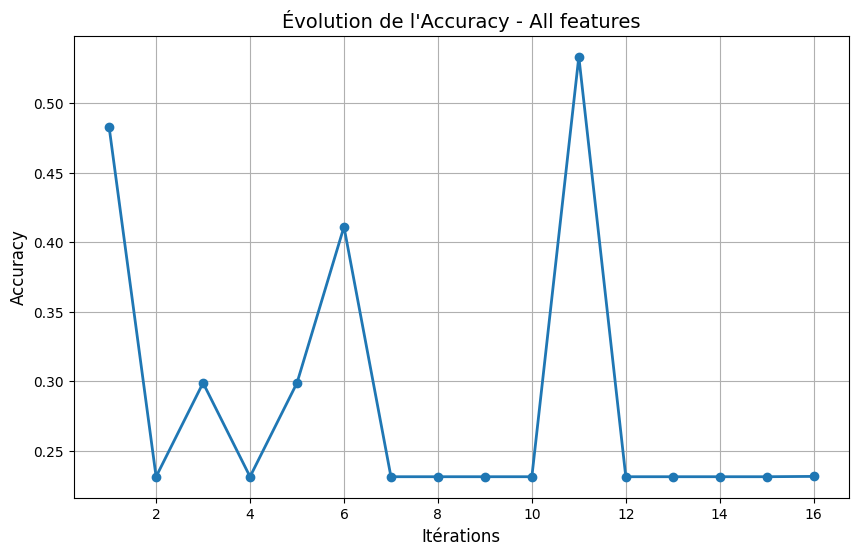

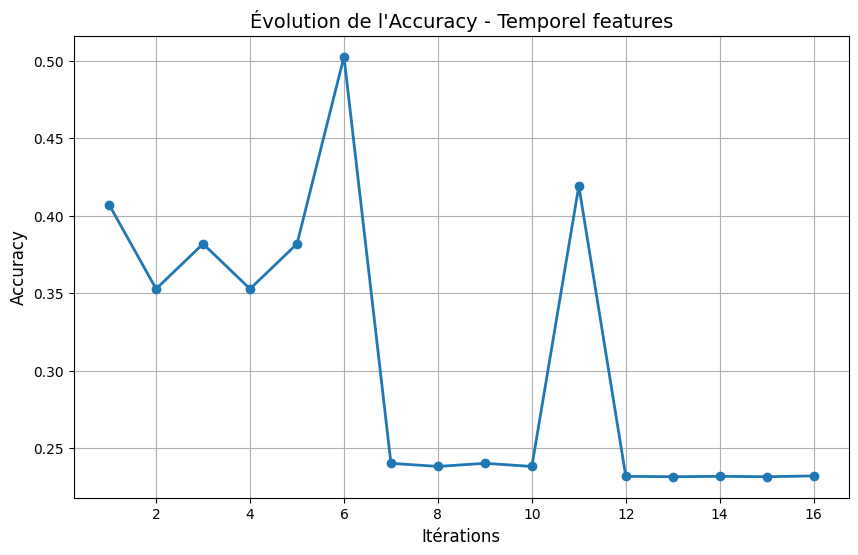

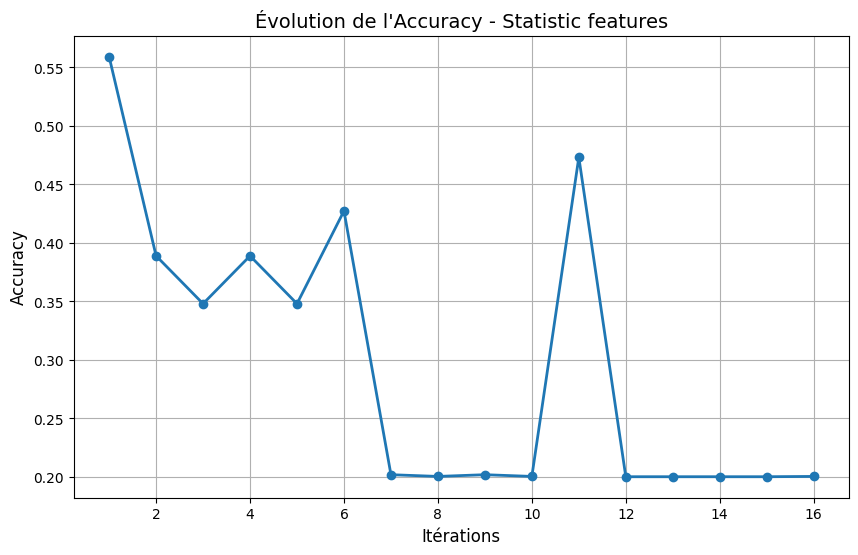

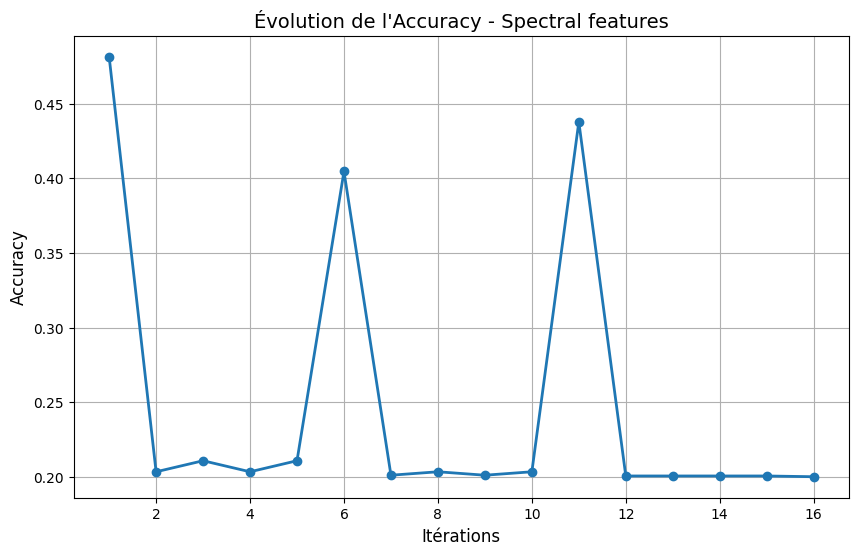

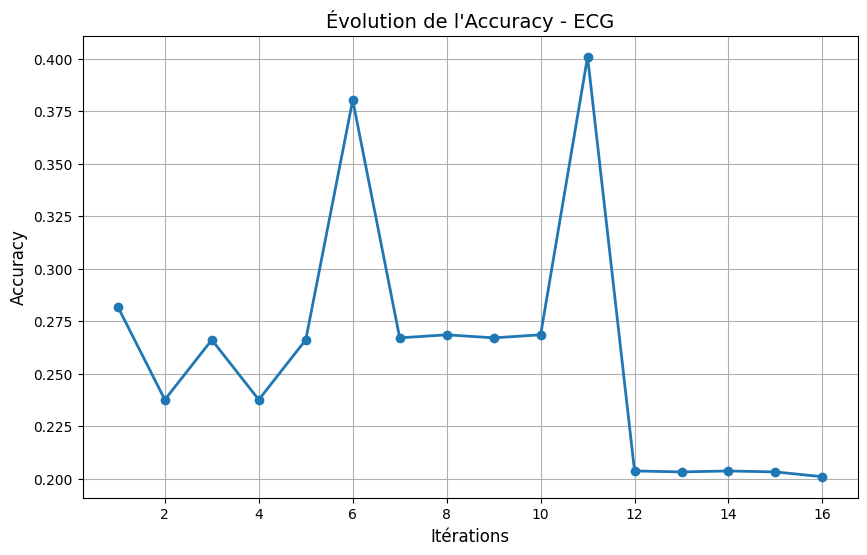

In [71]:
%%skip

# Obtenir les meilleurs hyperparametres pour chaque type de données
dataList = {
           "All features": DataFeatureApp,
            "Temporel features" : DataFeatureAppTemp, 
            "Statistic features" : DataFeatureAppStat,
            "Spectral features":DataFeatureAppSpec,
            "ECG": DataECGApp
        }
score_list = {}

for scaler_name, data in dataList.items():
    print(f"🔍 Entraînement sur {scaler_name}")
    score_list[scaler_name] = CH_search(data)

# Générer des graphiques pour chaque type de données
for data_type in dataList:
    plot_accuracy(score_list[data_type], title=f"Évolution de l'Accuracy - {data_type}")

### Clustering Hierarchique

In [29]:
from sklearn.cluster import AgglomerativeClustering


def CH_model(data_features, params,scaling= True):
    if scaling:
        scaler = RobustScaler()
        data_features = scaler.fit_transform(data_features)
    
    # model
    agglo = AgglomerativeClustering(n_clusters=5, **params)  # Peut tester aussi 'complete', 'average'
    
    # classification
    y_pred_ch = agglo.fit_predict(data_features)
    
    # Convertir en Int
    LabelF_test1 = LabelF_test.astype(int)
        
    # Conversion des clusters en labels réels
    #y_pred_labels_ch = correspondance(y_pred_ch, LabelF_test1) #fonction de la prof
    y_pred_labels_ch = true_labels(y_pred_ch, LabelF_test1)
    
    # Calcul matrix score
    score_matrix_ch = conf_matrix_score(LabelF_test, y_pred_ch)
    
    # Calcul de l'accuracy
    accuracy_ch = accuracy_score(LabelF_test, y_pred_labels_ch)
    
    #print(f"accuracy score de CH : {accuracy_ch}")
    return y_pred_ch, accuracy_ch, y_pred_labels_ch, score_matrix_ch


In [30]:
# Test des différentes caractéristiques

# hperparamètres définit après recherche pour chaque type de données
model_grid = {
    "all":{'linkage': 'average', 'metric': 'cosine'},
    "Temp":{'linkage': 'complete', 'metric': 'cosine'},
    "Stat":{'linkage': 'ward', 'metric': 'euclidean'},
    "Spec":{'linkage': 'ward', 'metric': 'euclidean'},
    "ECG":{'linkage': 'average', 'metric': 'cosine'}
}

# All features
y_pred_ch_all_T, accuracy_ch_all_T, y_pred_labels_ch_all_T, score_matrix_ch_all_T = CH_model(DataFeatureTest, model_grid["all"] )
print(f"Accuracy et matrix score de all features avec robust scaler : {accuracy_ch_all_T} ; {score_matrix_ch_all_T}")
y_pred_ch_all_F, accuracy_ch_all_F, y_pred_labels_ch_all_F, score_matrix_ch_all_F = CH_model(DataFeatureTest,model_grid["all"], False)
print(f"Accuracy et matrix score de all features sans robust scaler : {accuracy_ch_all_F } ; {score_matrix_ch_all_F}")

# Temporel features
y_pred_ch_Temp_T, accuracy_ch_Temp_T, y_pred_labels_ch_Temp_T, score_matrix_ch_Temp_T = CH_model(DataFeatureTestTemp, model_grid["Temp"] )
print(f"Accuracy et matrix score de Temp features avec robust scaler : {accuracy_ch_Temp_T} ; {score_matrix_ch_Temp_T}")
y_pred_ch_Temp_F, accuracy_ch_Temp_F, y_pred_labels_ch_Temp_F, score_matrix_ch_Temp_F = CH_model(DataFeatureTestTemp, model_grid["Temp"],False)
print(f"Accuracy et matrix score de Temp features sans robust scaler : {accuracy_ch_Temp_F } ; {score_matrix_ch_Temp_F}")

# Statistiques features
y_pred_ch_Stat_T, accuracy_ch_Stat_T, y_pred_labels_ch_Stat_T, score_matrix_ch_Stat_T = CH_model(DataFeatureTestStat,  model_grid["Stat"] )
print(f"Accuracy et matrix score de Stat features avec robust scaler : {accuracy_ch_Stat_T} ; {score_matrix_ch_Stat_T}")
y_pred_ch_Stat_F, accuracy_ch_Stat_F, y_pred_labels_ch_Stat_F, score_matrix_ch_Stat_F = CH_model(DataFeatureTestStat,model_grid["Stat"], False)
print(f"Accuracy et matrix score de Stat features sans robust scaler : {accuracy_ch_Stat_F } ; {score_matrix_ch_Stat_F}")

# Spectral features
y_pred_ch_Spec_T, accuracy_ch_Spec_T, y_pred_labels_ch_Spec_T, score_matrix_ch_Spec_T = CH_model(DataFeatureTestSpec,  model_grid["Spec"] )
print(f"Accuracy et matrix score de Spec features avec robust scaler : {accuracy_ch_Spec_T} ; {score_matrix_ch_Spec_T}")
y_pred_ch_Spec_F, accuracy_ch_Spec_F, y_pred_labels_ch_Spec_F, score_matrix_ch_Spec_F = CH_model(DataFeatureTestSpec,model_grid["Spec"], False)
print(f"Accuracy et matrix score de Spec features sans robust scaler : {accuracy_ch_Spec_F } ; {score_matrix_ch_Spec_F}")

# ECG sans features
y_pred_ch_ECG_T, accuracy_ch_ECG_T, y_pred_labels_ch_ECG_T, score_matrix_ch_ECG_T = CH_model(DataECGTest,  model_grid["ECG"] )
print(f"Accuracy et matrix score de ECG features avec robust scaler : {accuracy_ch_ECG_T} ; {score_matrix_ch_ECG_T}")
y_pred_ch_ECG_F, accuracy_ch_ECG_F, y_pred_labels_ch_ECG_F, score_matrix_ch_ECG_F = CH_model(DataECGTest, model_grid["ECG"], False)
print(f"Accuracy et matrix score de ECG features sans robust scaler : {accuracy_ch_ECG_F } ; {score_matrix_ch_ECG_F}")




Accuracy et matrix score de all features avec robust scaler : 0.522 ; 0.5275515176830966
Accuracy et matrix score de all features sans robust scaler : 0.229 ; 0.21811281676413255
Accuracy et matrix score de Temp features avec robust scaler : 0.522 ; 0.519826127819549
Accuracy et matrix score de Temp features sans robust scaler : 0.338 ; 0.33521825396825394
Accuracy et matrix score de Stat features avec robust scaler : 0.463 ; 0.46790744221665276
Accuracy et matrix score de Stat features sans robust scaler : 0.423 ; 0.42571150097465893
Accuracy et matrix score de Spec features avec robust scaler : 0.406 ; 0.4162496519075467
Accuracy et matrix score de Spec features sans robust scaler : 0.387 ; 0.3899550960735171
Accuracy et matrix score de ECG features avec robust scaler : 0.384 ; 0.38146929824561404
Accuracy et matrix score de ECG features sans robust scaler : 0.291 ; 0.276140350877193


### Matrice de confusion

In [31]:

# KMEANS
conf_matrix_km_all_T = confusion_matrix(LabelF_test, y_pred_labels_km_all_T)
conf_matrix_km_all_F = confusion_matrix(LabelF_test, y_pred_labels_km_all_F)

conf_matrix_km_Temp_T = confusion_matrix(LabelF_test, y_pred_labels_km_Temp_T)
conf_matrix_km_Temp_F = confusion_matrix(LabelF_test, y_pred_labels_km_Temp_F)

conf_matrix_km_Spec_T = confusion_matrix(LabelF_test, y_pred_labels_km_Spec_T)
conf_matrix_km_Spec_F = confusion_matrix(LabelF_test, y_pred_labels_km_Spec_F)

conf_matrix_km_Stat_T = confusion_matrix(LabelF_test, y_pred_labels_km_Stat_T)
conf_matrix_km_Stat_F = confusion_matrix(LabelF_test, y_pred_labels_km_Stat_F)

conf_matrix_km_ECG_T = confusion_matrix(LabelF_test, y_pred_labels_km_ECG_T)
conf_matrix_km_ECG_F = confusion_matrix(LabelF_test, y_pred_labels_km_ECG_F)


# Clustering hierarchique

conf_matrix_ch_all_T = confusion_matrix(LabelF_test, y_pred_labels_ch_all_T)
conf_matrix_ch_all_F = confusion_matrix(LabelF_test, y_pred_labels_ch_all_F)

conf_matrix_ch_Temp_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Temp_T)
conf_matrix_ch_Temp_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Temp_F)

conf_matrix_ch_Spec_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Spec_T)
conf_matrix_ch_Spec_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Spec_F)

conf_matrix_ch_Stat_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Stat_T)
conf_matrix_ch_Stat_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Stat_F)

conf_matrix_ch_ECG_T = confusion_matrix(LabelF_test, y_pred_labels_ch_ECG_T)
conf_matrix_ch_ECG_F = confusion_matrix(LabelF_test, y_pred_labels_ch_ECG_F)



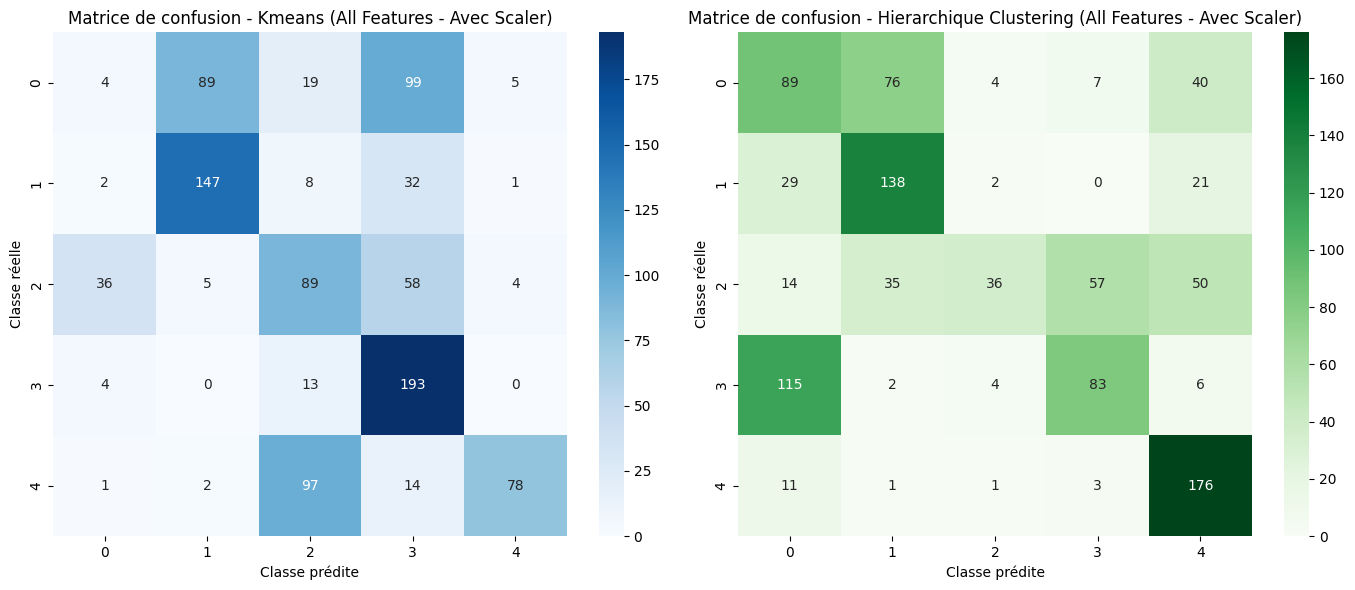

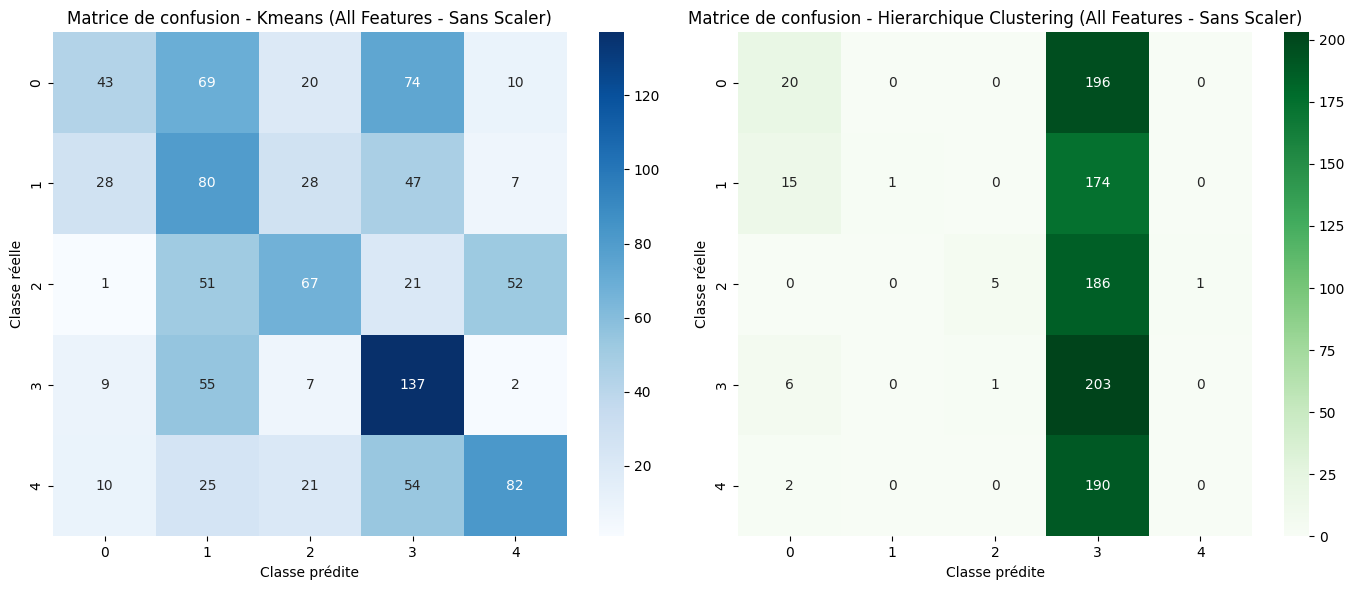

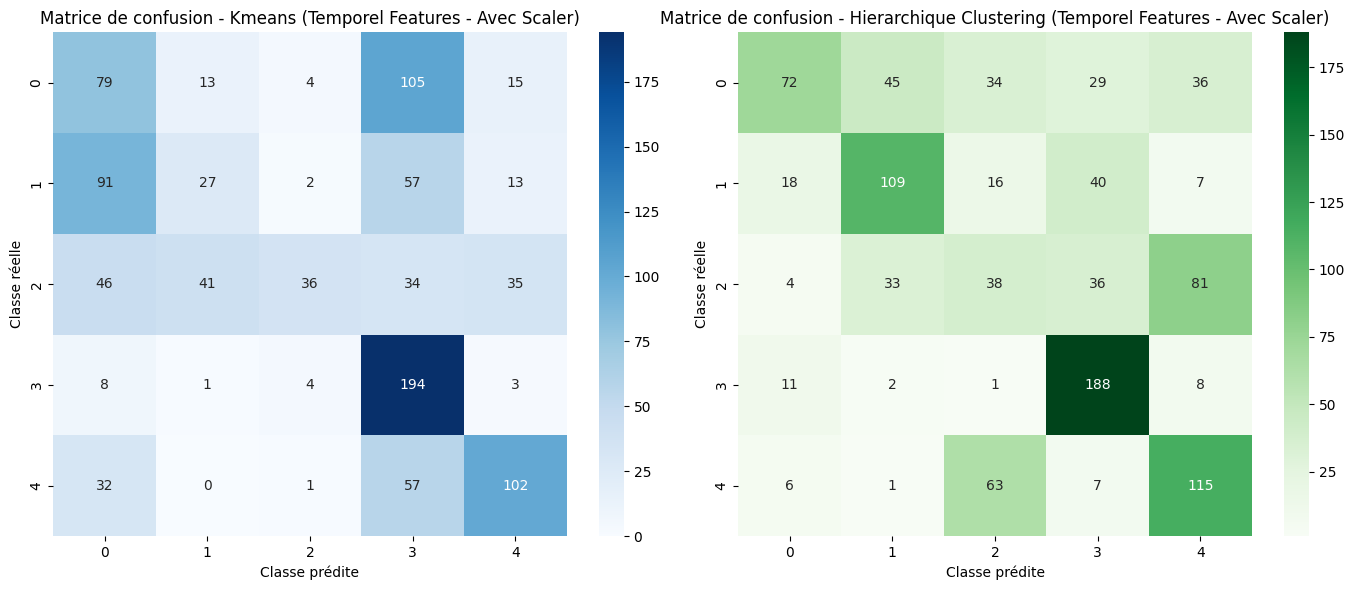

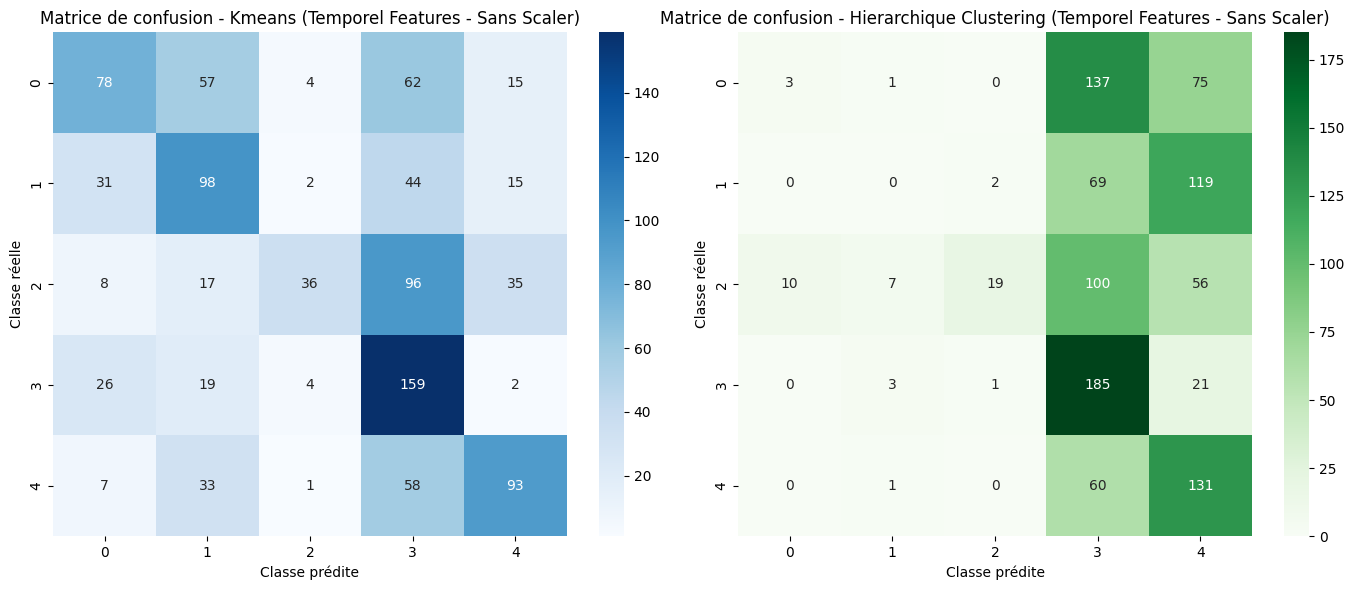

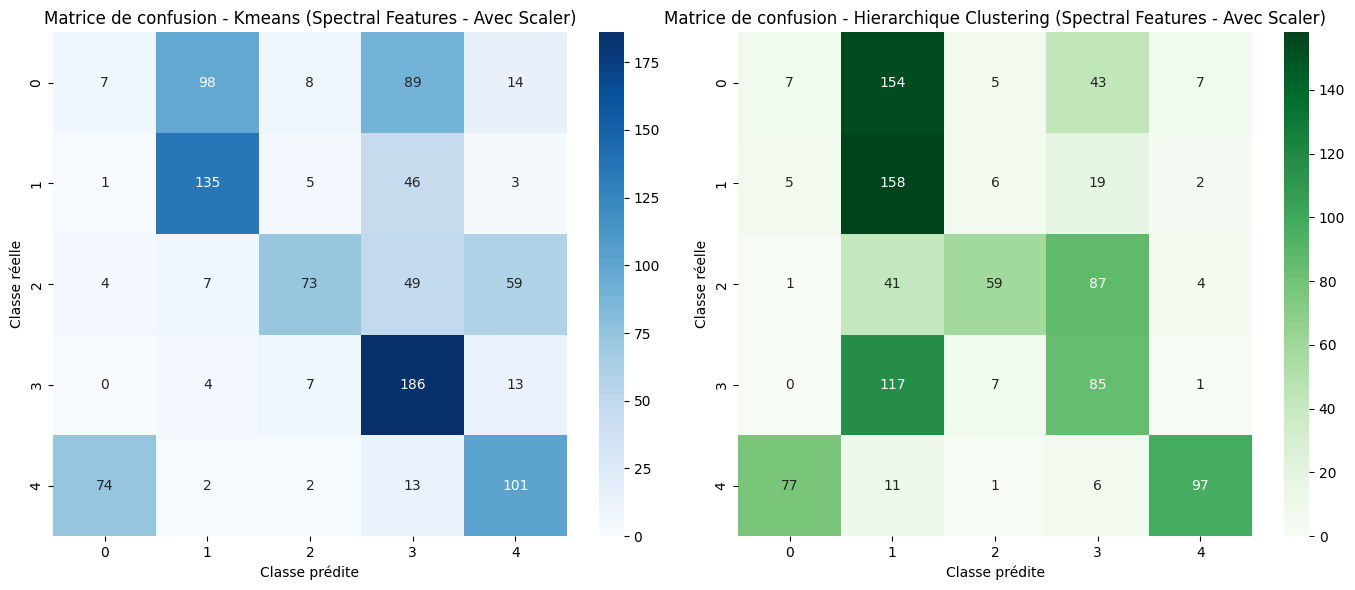

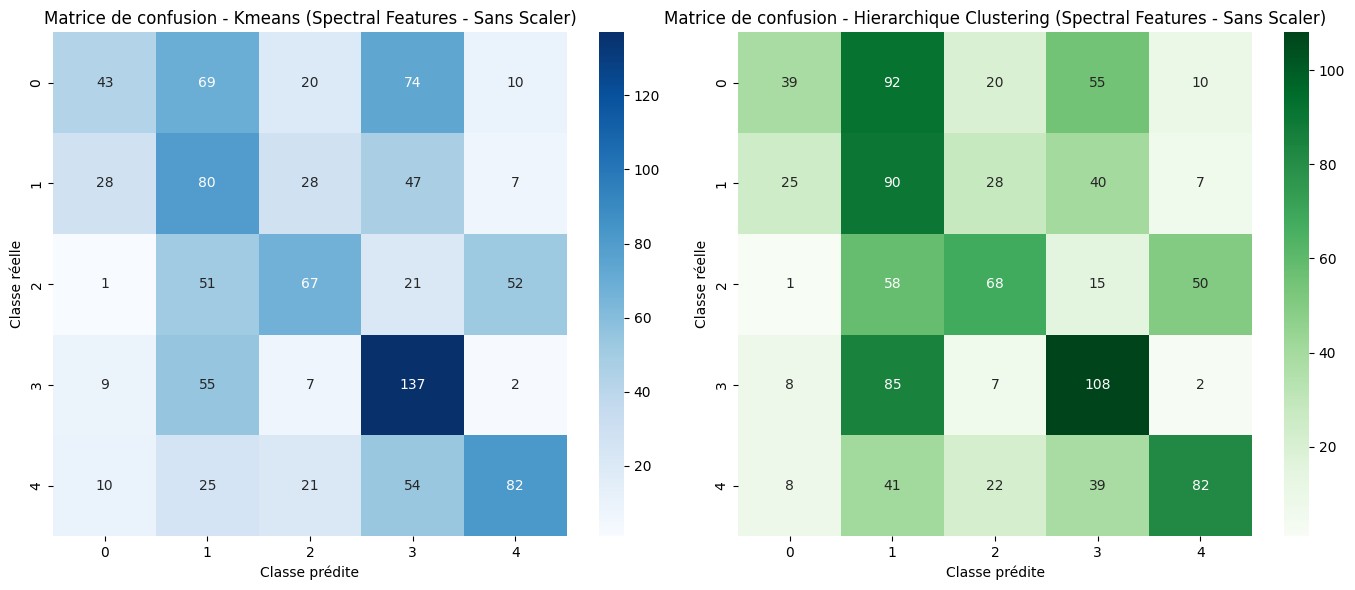

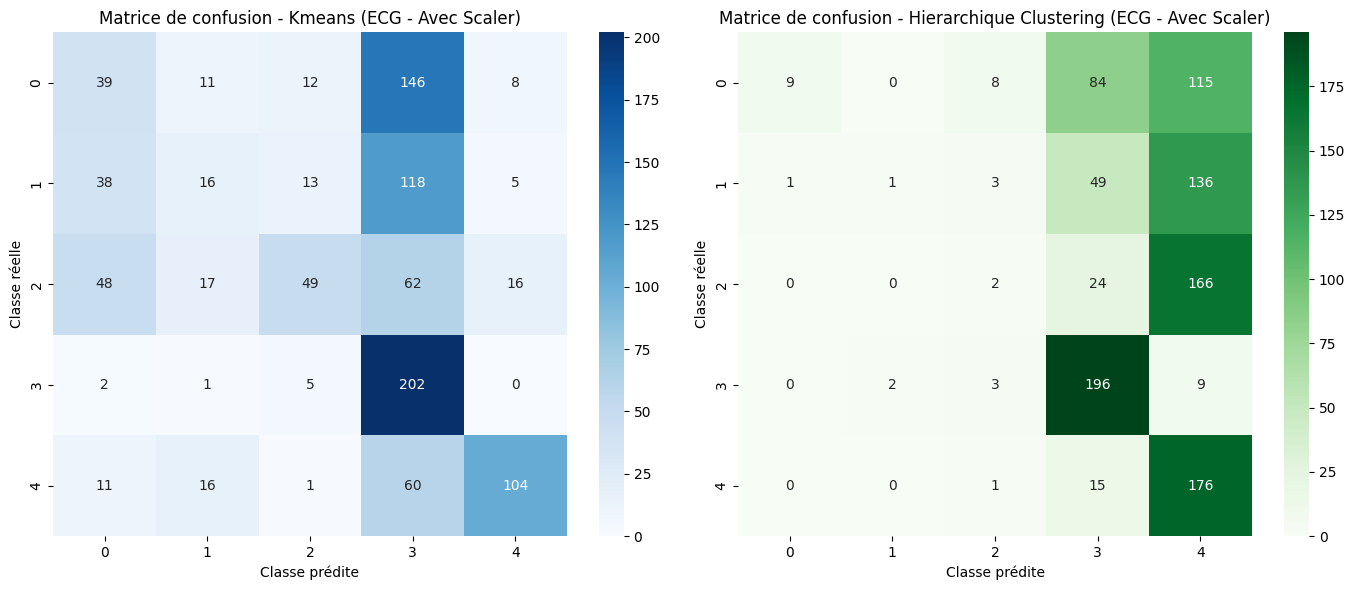

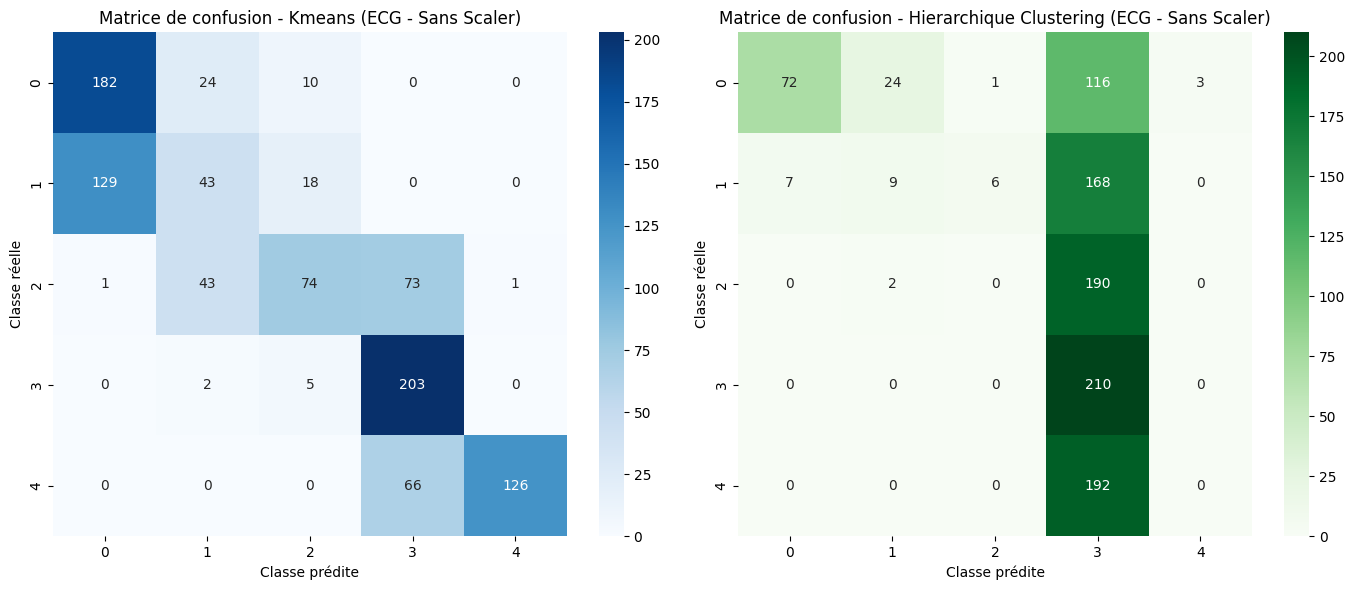

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display matrice de confusion

def display_matrix_ns(m1, m2, title):
    plt.figure(figsize=(14, 6))
    
    # Matrice Random Forest
    plt.subplot(1, 2, 1)
    sns.heatmap(m1, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - Kmeans ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    # Matrice KNN
    plt.subplot(1, 2, 2)
    sns.heatmap(m2, annot=True, fmt="d", cmap="Greens")
    plt.title(f"Matrice de confusion - Hierarchique Clustering ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    plt.tight_layout()
    plt.show()


# Affichage des matrices de confusion
display_matrix_ns(conf_matrix_km_all_T, conf_matrix_ch_all_T, 
                 "All Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_all_F, conf_matrix_ch_all_F, 
                 "All Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_Temp_T, conf_matrix_ch_Temp_T, 
                 "Temporel Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_Temp_F, conf_matrix_ch_Temp_F, 
                 "Temporel Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_Spec_T, conf_matrix_ch_Spec_T, 
                 "Spectral Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_Spec_F, conf_matrix_ch_Spec_F, 
                "Spectral Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_ECG_T, conf_matrix_ch_ECG_T, 
                "ECG - Avec Scaler")

display_matrix_ns(conf_matrix_km_ECG_F, conf_matrix_ch_ECG_F, 
                 "ECG - Sans Scaler")



# Partie III : classification des battements cardiaques sur les features avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [50]:
from sklearn.decomposition import PCA

Nombre de composantes pour all avec 90% de variance : 23
Nombre de composantes pour Temp avec 90% de variance : 7
Nombre de composantes pour Stat avec 90% de variance : 6
Nombre de composantes pour Spec avec 90% de variance : 20
Nombre de composantes pour ECG avec 90% de variance : 20

🔍 Recherche des meilleurs hyperparamètres pour all...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.908750051080986

Résultats pour all avec PCA90 :
Accuracy du modèle RandomForest : 0.9100

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       216
         1.0       0.95      0.85      0.89       190
         2.0       0.87      0.93      0.90       192
         3.0       0.97      0.98      0.98       210
         4.0       0.96      0.91      0.94      

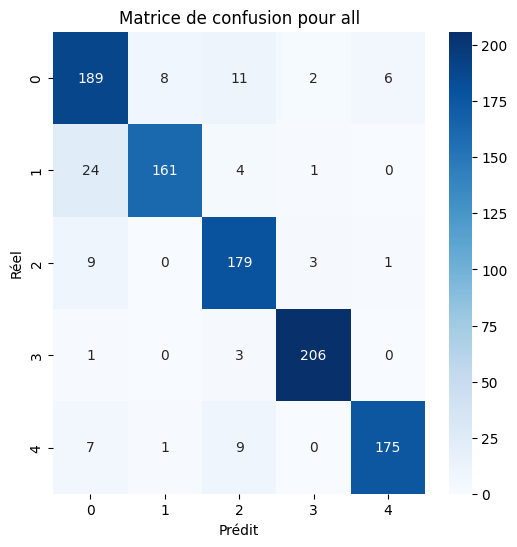


🔍 Recherche des meilleurs hyperparamètres pour Temp...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
🎯 Meilleur score : 0.8592509821608326

Résultats pour Temp avec PCA90 :
Accuracy du modèle RandomForest : 0.8780

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       216
         1.0       0.88      0.85      0.87       190
         2.0       0.82      0.91      0.86       192
         3.0       0.95      0.97      0.96       210
         4.0       0.94      0.89      0.91       192

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



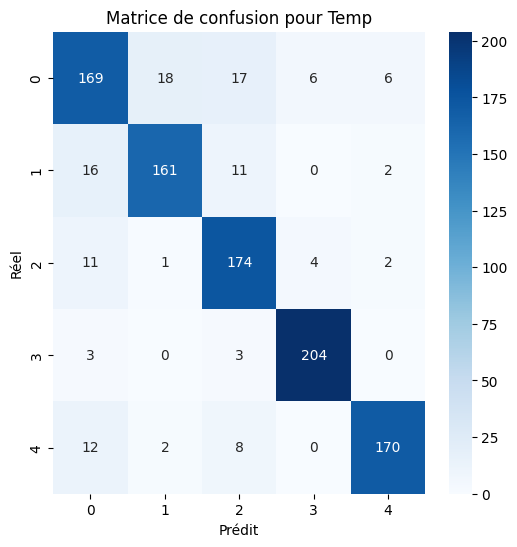


🔍 Recherche des meilleurs hyperparamètres pour Stat...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
🎯 Meilleur score : 0.8467471065667467

Résultats pour Stat avec PCA90 :
Accuracy du modèle RandomForest : 0.8520

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76       216
         1.0       0.83      0.79      0.81       190
         2.0       0.79      0.87      0.83       192
         3.0       0.94      0.98      0.96       210
         4.0       0.96      0.86      0.91       192

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



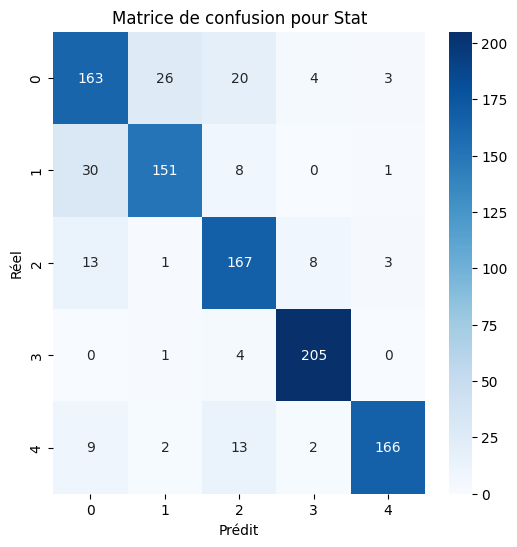


🔍 Recherche des meilleurs hyperparamètres pour Spec...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🎯 Meilleur score : 0.9052493633153417

Résultats pour Spec avec PCA90 :
Accuracy du modèle RandomForest : 0.9010

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82       216
         1.0       0.91      0.79      0.85       190
         2.0       0.89      0.93      0.91       192
         3.0       0.98      0.99      0.98       210
         4.0       0.98      0.92      0.95       192

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



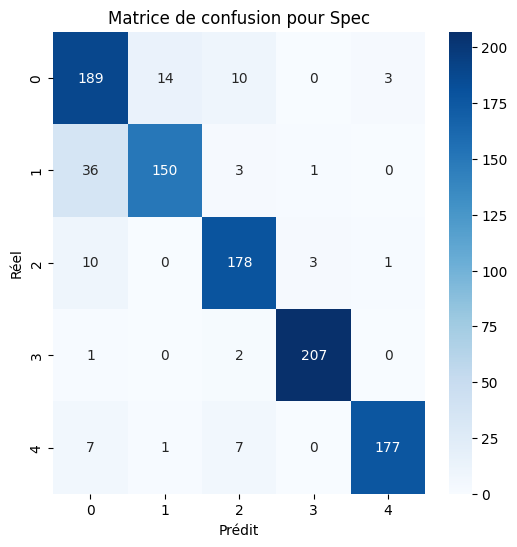


🔍 Recherche des meilleurs hyperparamètres pour ECG...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.8787498598787629

Résultats pour ECG avec PCA90 :
Accuracy du modèle RandomForest : 0.9070

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       216
         1.0       0.89      0.87      0.88       190
         2.0       0.91      0.88      0.89       192
         3.0       0.94      0.97      0.95       210
         4.0       0.95      0.94      0.94       192

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



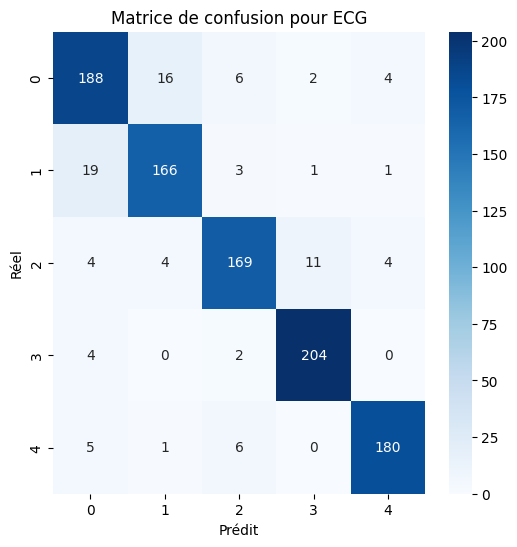

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fonction pour effectuer une recherche d'hyperparamètres avec GridSearchCV
def grid_search_rf(data_features, labels, scaling=True):
    if scaling:
        scaler = StandardScaler()
        data_features = scaler.fit_transform(data_features)
    
    # Définition des hyperparamètres à tester
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    # Initialisation du modèle
    rf_clf = RandomForestClassifier(random_state=42)

    # GridSearchCV avec validation croisée
    grid_search = GridSearchCV(
        rf_clf,
        param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    # Exécution de la recherche
    grid_search.fit(data_features, labels)
    
    # Récupération des résultats sous forme de DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)

    print(f"✅ Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f"🎯 Meilleur score : {grid_search.best_score_}")

    return grid_search.best_estimator_, grid_search.best_score_, results_df

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(conf_matrix, key):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion pour {key}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

# Initialisation des normaliseurs et des ensembles de données
scalers = {"all": StandardScaler(), "Temp": StandardScaler(), "Stat": StandardScaler(), "Spec": StandardScaler(), "ECG": StandardScaler()}
data_sets = {
    "all": (DataFeatureApp, DataFeatureTest),
    "Temp": (DataFeatureAppTemp, DataFeatureTestTemp),
    "Stat": (DataFeatureAppStat, DataFeatureTestStat),
    "Spec": (DataFeatureAppSpec, DataFeatureTestSpec),
    "ECG": (DataECGApp, DataECGTest)
}

# Dictionnaires pour stocker les données normalisées et transformées par PCA
normalized_data = {}
pca_transformed_data = {}
best_models = {}

# Normalisation des données et application de PCA
for key, (train, test) in data_sets.items():
    # Normalisation des données
    scaler = scalers[key]
    normalized_data[f"{key}_train"] = scaler.fit_transform(train)
    normalized_data[f"{key}_test"] = scaler.transform(test)
    
    # Application de PCA avec 90% de variance expliquée
    pca = PCA(n_components=0.90)
    pca_transformed_data[f"{key}_train_PCA"] = pca.fit_transform(normalized_data[f"{key}_train"])
    pca_transformed_data[f"{key}_test_PCA"] = pca.transform(normalized_data[f"{key}_test"])
    print(f"Nombre de composantes pour {key} avec 90% de variance : {pca_transformed_data[f'{key}_train_PCA'].shape[1]}")

# Entraînement et évaluation des modèles Random Forest avec GridSearchCV
for key in data_sets.keys():
    # Recherche des meilleurs hyperparamètres
    print(f"\n🔍 Recherche des meilleurs hyperparamètres pour {key}...")
    best_model, best_score, _ = grid_search_rf(pca_transformed_data[f"{key}_train_PCA"], LabelF_train, scaling=False)
    
    # Enregistrement du meilleur modèle
    best_models[key] = best_model
    
    # Prédiction sur les données de test
    X_test = pca_transformed_data[f"{key}_test_PCA"]
    y_pred = best_models[key].predict(X_test)
    
    # Calcul des métriques d'évaluation
    accuracy = accuracy_score(LabelF_test, y_pred)
    conf_matrix = confusion_matrix(LabelF_test, y_pred)
    class_report = classification_report(LabelF_test, y_pred)
    
    # Affichage des résultats avec une mise en forme améliorée
    print("\n" + "=" * 60)
    print(f"Résultats pour {key} avec PCA90 :")
    print("=" * 60)
    print(f"Accuracy du modèle RandomForest : {accuracy:.4f}")
    print("\nRapport de classification :")
    print(class_report)
    
    # Affichage de la matrice de confusion avec matplotlib
    plot_confusion_matrix(conf_matrix, key)

In [40]:
# Importations nécessaires
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour visualiser l'évolution de l'accuracy
def plot_accuracy_evolution(results_df, dataset_name, scaler_status):
    """
    Visualise l'évolution de l'accuracy moyenne pour les configurations testées.

    :param results_df: DataFrame contenant les résultats de GridSearchCV.
    :param dataset_name: Nom du dataset (par exemple, 'all', 'Temp', etc.).
    :param scaler_status: Statut de la normalisation (par exemple, 'Avec Normalisation' ou 'Sans Normalisation').
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(results_df)), y=results_df['mean_test_score'], marker='o', color='b', label='Accuracy Moyenne')

    plt.title(f"Évolution de l'Accuracy - {dataset_name} ({scaler_status})", fontsize=14)
    plt.xlabel("Configurations Testées", fontsize=12)
    plt.ylabel("Accuracy Moyenne", fontsize=12)
    plt.xticks(range(len(results_df)), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


🔍 Recherche des meilleurs hyperparamètres pour all...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.908750051080986


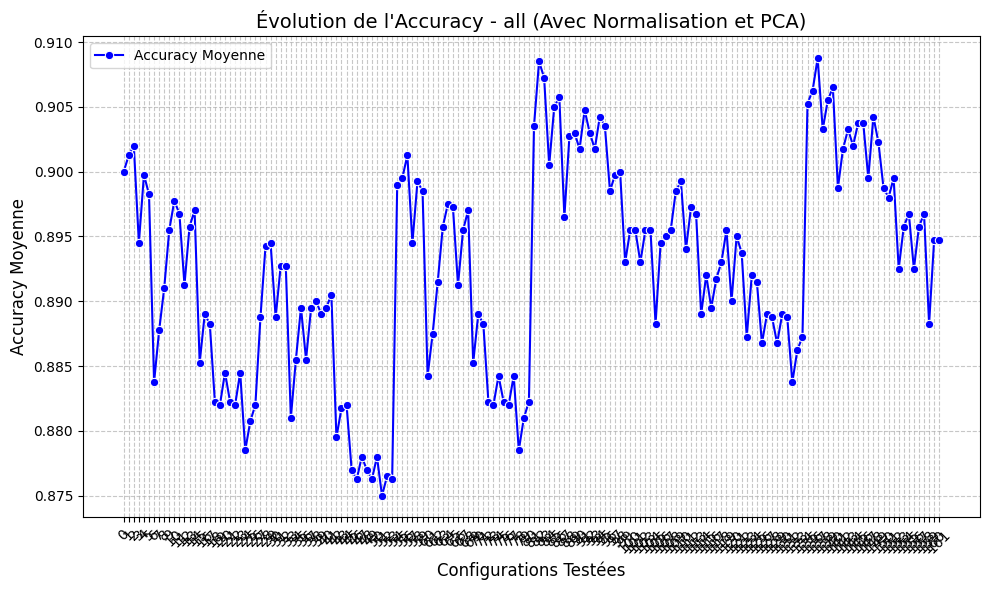


Résultats pour all avec PCA90 :
Accuracy du modèle RandomForest : 0.9100

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       216
         1.0       0.95      0.85      0.89       190
         2.0       0.87      0.93      0.90       192
         3.0       0.97      0.98      0.98       210
         4.0       0.96      0.91      0.94       192

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



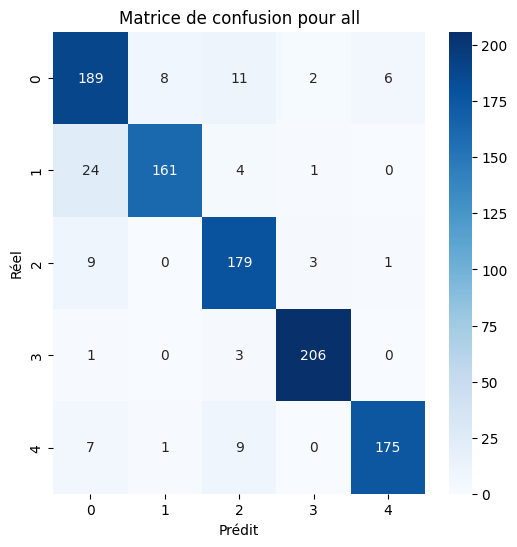


🔍 Recherche des meilleurs hyperparamètres pour Temp...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
🎯 Meilleur score : 0.8592509821608326


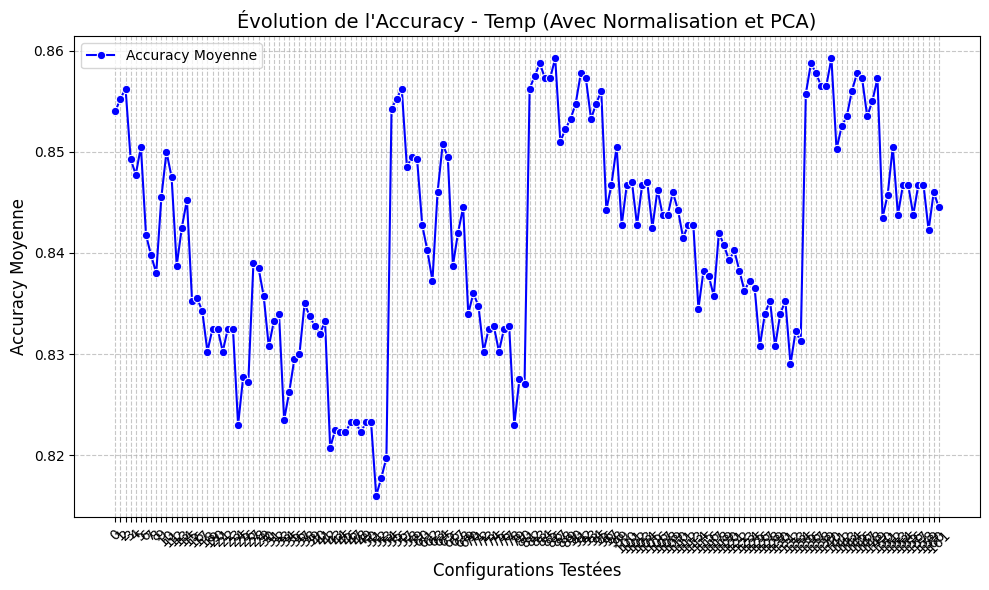


Résultats pour Temp avec PCA90 :
Accuracy du modèle RandomForest : 0.8780

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       216
         1.0       0.88      0.85      0.87       190
         2.0       0.82      0.91      0.86       192
         3.0       0.95      0.97      0.96       210
         4.0       0.94      0.89      0.91       192

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



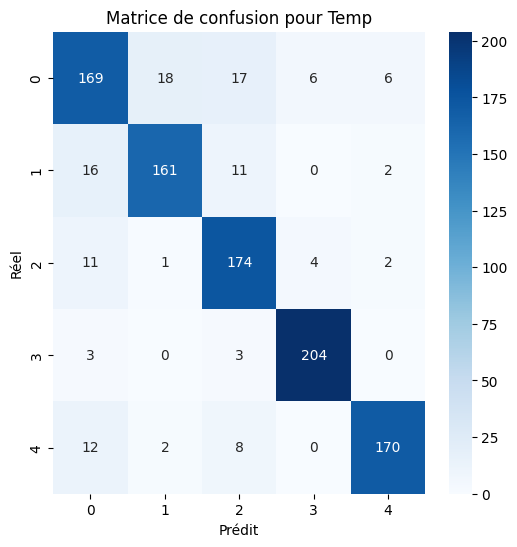


🔍 Recherche des meilleurs hyperparamètres pour Stat...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
🎯 Meilleur score : 0.8467471065667467


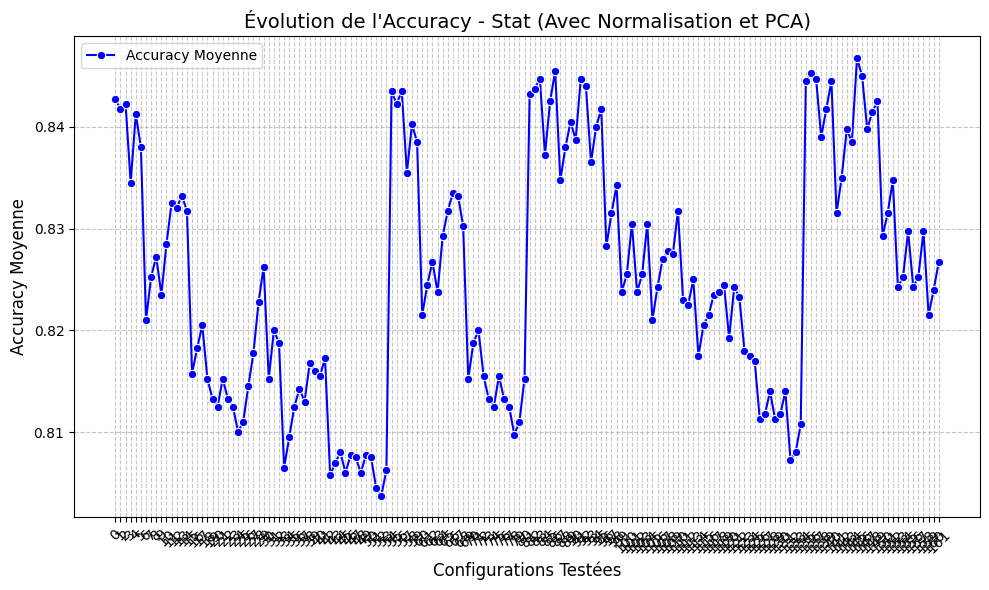


Résultats pour Stat avec PCA90 :
Accuracy du modèle RandomForest : 0.8520

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76       216
         1.0       0.83      0.79      0.81       190
         2.0       0.79      0.87      0.83       192
         3.0       0.94      0.98      0.96       210
         4.0       0.96      0.86      0.91       192

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



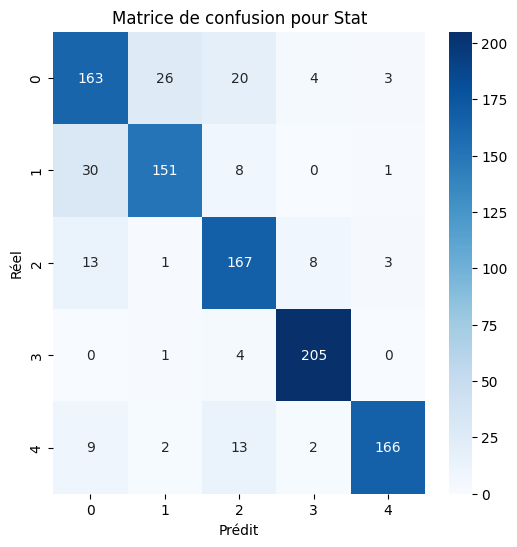


🔍 Recherche des meilleurs hyperparamètres pour Spec...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🎯 Meilleur score : 0.9052493633153417


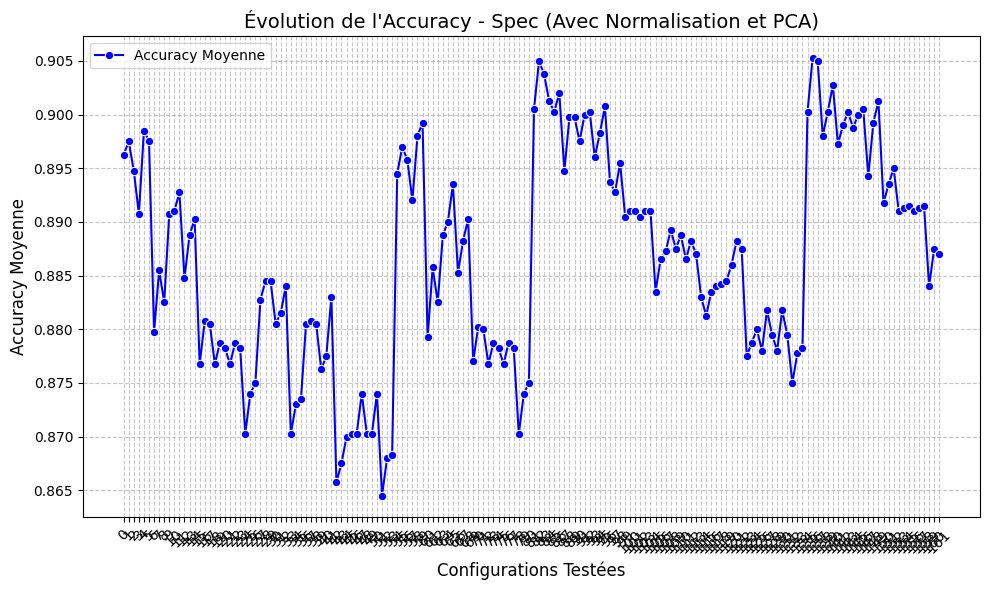


Résultats pour Spec avec PCA90 :
Accuracy du modèle RandomForest : 0.9010

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82       216
         1.0       0.91      0.79      0.85       190
         2.0       0.89      0.93      0.91       192
         3.0       0.98      0.99      0.98       210
         4.0       0.98      0.92      0.95       192

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



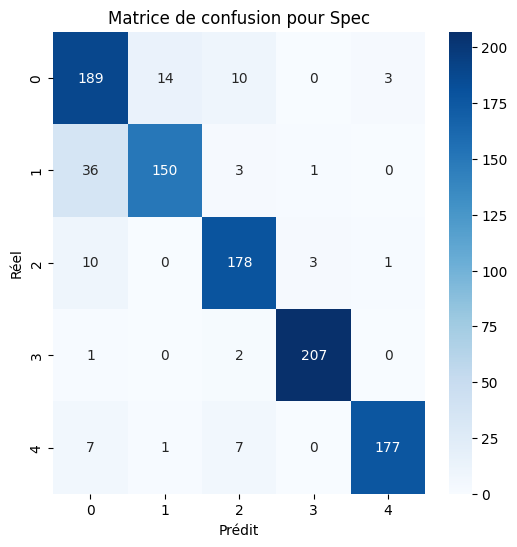


🔍 Recherche des meilleurs hyperparamètres pour ECG...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.8787498598787629


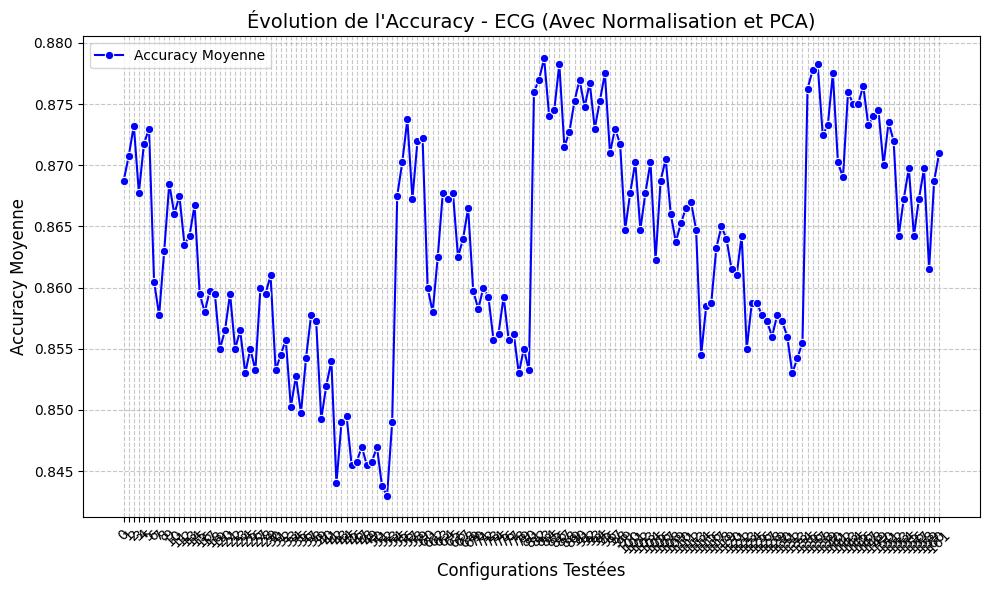


Résultats pour ECG avec PCA90 :
Accuracy du modèle RandomForest : 0.9070

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       216
         1.0       0.89      0.87      0.88       190
         2.0       0.91      0.88      0.89       192
         3.0       0.94      0.97      0.95       210
         4.0       0.95      0.94      0.94       192

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



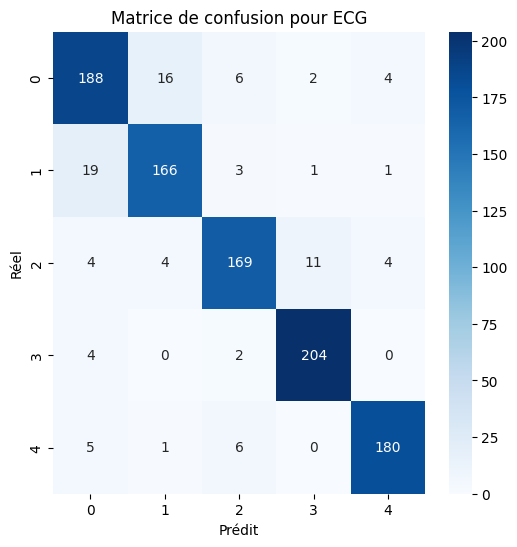

In [41]:
# Entraînement et évaluation des modèles Random Forest avec GridSearchCV
for key in data_sets.keys():
    # Recherche des meilleurs hyperparamètres
    print(f"\n🔍 Recherche des meilleurs hyperparamètres pour {key}...")
    best_model, best_score, results_df = grid_search_rf(pca_transformed_data[f"{key}_train_PCA"], LabelF_train, scaling=False)
    
    # Enregistrement du meilleur modèle
    best_models[key] = best_model
    
    # Visualisation de l'évolution de l'accuracy
    plot_accuracy_evolution(results_df, dataset_name=key, scaler_status="Avec Normalisation et PCA")
    
    # Prédiction sur les données de test
    X_test = pca_transformed_data[f"{key}_test_PCA"]
    y_pred = best_models[key].predict(X_test)
    
    # Calcul des métriques d'évaluation
    accuracy = accuracy_score(LabelF_test, y_pred)
    conf_matrix = confusion_matrix(LabelF_test, y_pred)
    class_report = classification_report(LabelF_test, y_pred)
    
    # Affichage des résultats avec une mise en forme améliorée
    print("\n" + "=" * 60)
    print(f"Résultats pour {key} avec PCA90 :")
    print("=" * 60)
    print(f"Accuracy du modèle RandomForest : {accuracy:.4f}")
    print("\nRapport de classification :")
    print(class_report)
    
    # Affichage de la matrice de confusion avec matplotlib
    plot_confusion_matrix(conf_matrix, key)

### KNN


Nombre de composantes pour all avec 90% de variance : 23
Nombre de composantes pour Temp avec 90% de variance : 7
Nombre de composantes pour Stat avec 90% de variance : 6
Nombre de composantes pour Spec avec 90% de variance : 20
Nombre de composantes pour ECG avec 90% de variance : 20

🔍 Recherche des meilleurs hyperparamètres pour all...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
🎯 Meilleur score : 0.91875

Résultats pour all avec PCA90 :
Accuracy du modèle KNN : 0.9080

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       216
         1.0       0.87      0.87      0.87       190
         2.0       0.91      0.93      0.92       192
         3.0       0.93      0.99      0.96       210
         4.0       0.97      0.94      0.95       192

    accuracy                           0.91      1000
  

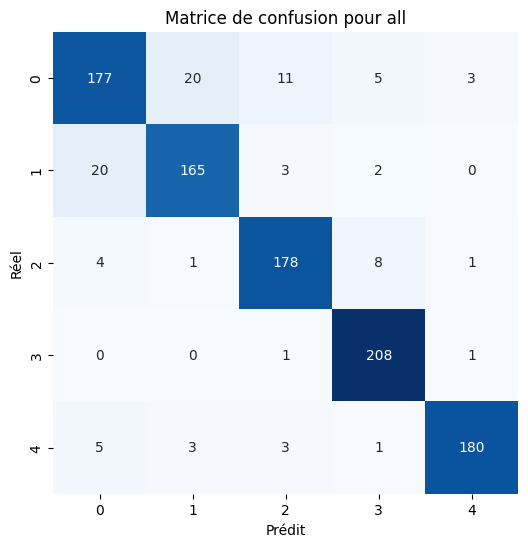


🔍 Recherche des meilleurs hyperparamètres pour Temp...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
🎯 Meilleur score : 0.8557499999999999

Résultats pour Temp avec PCA90 :
Accuracy du modèle KNN : 0.8700

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       216
         1.0       0.87      0.86      0.87       190
         2.0       0.83      0.85      0.84       192
         3.0       0.89      0.99      0.94       210
         4.0       0.94      0.92      0.93       192

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



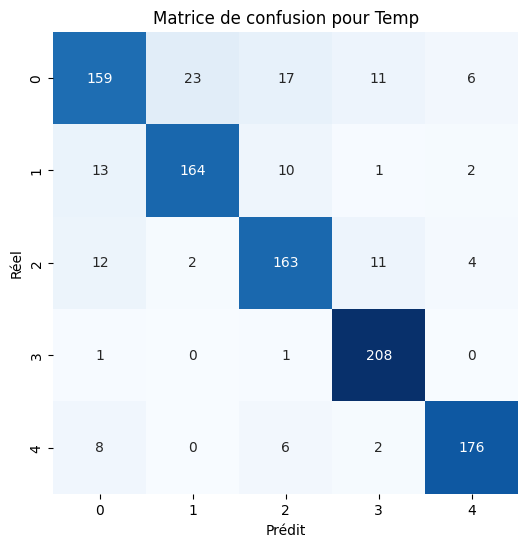


🔍 Recherche des meilleurs hyperparamètres pour Stat...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
🎯 Meilleur score : 0.84825

Résultats pour Stat avec PCA90 :
Accuracy du modèle KNN : 0.8590

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       216
         1.0       0.85      0.83      0.84       190
         2.0       0.86      0.79      0.82       192
         3.0       0.86      0.99      0.92       210
         4.0       0.93      0.92      0.93       192

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



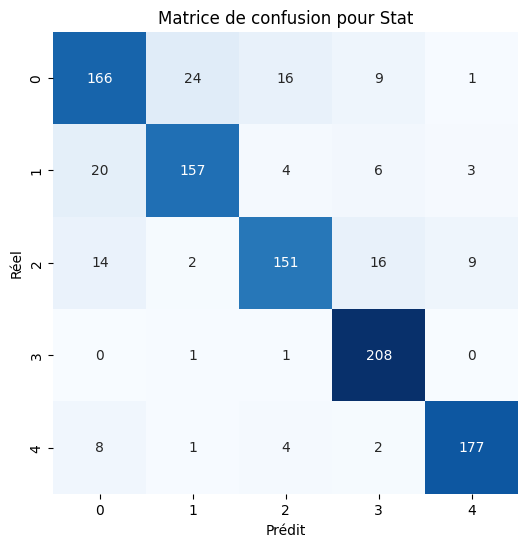


🔍 Recherche des meilleurs hyperparamètres pour Spec...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
🎯 Meilleur score : 0.91625

Résultats pour Spec avec PCA90 :
Accuracy du modèle KNN : 0.9100

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       216
         1.0       0.90      0.83      0.86       190
         2.0       0.93      0.91      0.92       192
         3.0       0.93      0.99      0.96       210
         4.0       0.96      0.93      0.95       192

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



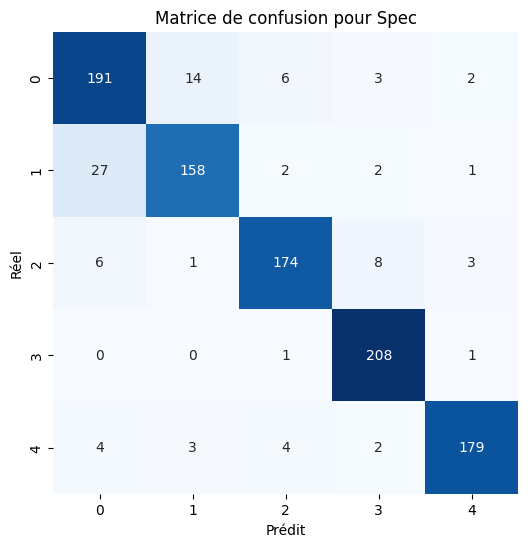


🔍 Recherche des meilleurs hyperparamètres pour ECG...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
🎯 Meilleur score : 0.88125

Résultats pour ECG avec PCA90 :
Accuracy du modèle KNN : 0.9000

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85       216
         1.0       0.83      0.87      0.85       190
         2.0       0.93      0.86      0.90       192
         3.0       0.91      0.98      0.94       210
         4.0       0.95      0.97      0.96       192

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



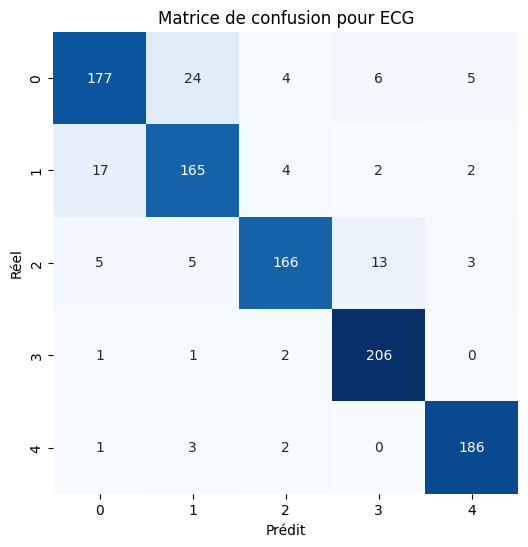

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fonction pour effectuer une recherche d'hyperparamètres avec GridSearchCV pour KNN
def grid_search_knn(data_features, labels, scaling=True):
    if scaling:
        scaler = StandardScaler()
        data_features = scaler.fit_transform(data_features)
    
    # Définition du modèle KNN
    knn = KNeighborsClassifier()
    
    # Définition de la grille de recherche
    param_grid = {
        "n_neighbors": [1, 3, 5, 7, 10, 15, 20],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    }
    
    # Initialisation de GridSearchCV
    grid_search_knn = GridSearchCV(
        knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )
    
    # Exécution de GridSearchCV
    grid_search_knn.fit(data_features, labels)
    
    # Récupération des résultats sous forme de DataFrame
    results_df = pd.DataFrame(grid_search_knn.cv_results_)

    print(f"✅ Meilleurs hyperparamètres : {grid_search_knn.best_params_}")
    print(f"🎯 Meilleur score : {grid_search_knn.best_score_}")

    return grid_search_knn.best_estimator_, grid_search_knn.best_score_, results_df

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(conf_matrix, key):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matrice de confusion pour {key}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

# Initialisation des normaliseurs et des ensembles de données
scalers = {"all": StandardScaler(), "Temp": StandardScaler(), "Stat": StandardScaler(), "Spec": StandardScaler(), "ECG": StandardScaler()}
data_sets = {
    "all": (DataFeatureApp, DataFeatureTest),
    "Temp": (DataFeatureAppTemp, DataFeatureTestTemp),
    "Stat": (DataFeatureAppStat, DataFeatureTestStat),
    "Spec": (DataFeatureAppSpec, DataFeatureTestSpec),
    "ECG": (DataECGApp, DataECGTest)
}

# Dictionnaires pour stocker les données normalisées et transformées par PCA
normalized_data = {}
pca_transformed_data = {}
best_models = {}

# Normalisation des données et application de PCA
for key, (train, test) in data_sets.items():
    # Normalisation des données
    scaler = scalers[key]
    normalized_data[f"{key}_train"] = scaler.fit_transform(train)
    normalized_data[f"{key}_test"] = scaler.transform(test)
    
    # Application de PCA avec 90% de variance expliquée
    pca = PCA(n_components=0.90)
    pca_transformed_data[f"{key}_train_PCA"] = pca.fit_transform(normalized_data[f"{key}_train"])
    pca_transformed_data[f"{key}_test_PCA"] = pca.transform(normalized_data[f"{key}_test"])
    print(f"Nombre de composantes pour {key} avec 90% de variance : {pca_transformed_data[f'{key}_train_PCA'].shape[1]}")

# Entraînement et évaluation des modèles KNN avec GridSearchCV
for key in data_sets.keys():
    # Recherche des meilleurs hyperparamètres
    print(f"\n🔍 Recherche des meilleurs hyperparamètres pour {key}...")
    best_model, best_score, _ = grid_search_knn(pca_transformed_data[f"{key}_train_PCA"], LabelF_train, scaling=False)
    
    # Enregistrement du meilleur modèle
    best_models[key] = best_model
    
    # Prédiction sur les données de test
    X_test = pca_transformed_data[f"{key}_test_PCA"]
    y_pred = best_models[key].predict(X_test)
    
    # Calcul des métriques d'évaluation
    accuracy = accuracy_score(LabelF_test, y_pred)
    conf_matrix = confusion_matrix(LabelF_test, y_pred)
    class_report = classification_report(LabelF_test, y_pred)
    
    # Affichage des résultats avec une mise en forme améliorée
    print("\n" + "=" * 60)
    print(f"Résultats pour {key} avec PCA90 :")
    print("=" * 60)
    print(f"Accuracy du modèle KNN : {accuracy:.4f}")
    print("\nRapport de classification :")
    print(class_report)
    
    # Affichage de la matrice de confusion avec matplotlib
    plot_confusion_matrix(conf_matrix, key)

Nombre de composantes pour all avec 90% de variance : 23
Nombre de composantes pour Temp avec 90% de variance : 7
Nombre de composantes pour Stat avec 90% de variance : 6
Nombre de composantes pour Spec avec 90% de variance : 20
Nombre de composantes pour ECG avec 90% de variance : 20

🔍 Recherche des meilleurs hyperparamètres pour all...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
🎯 Meilleur score : 0.91875


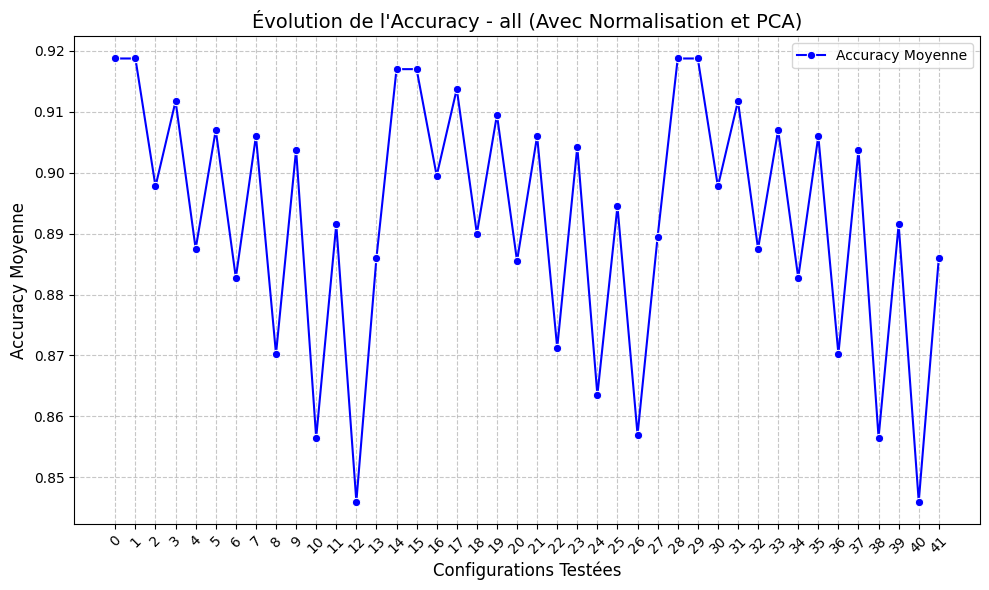


Résultats pour all avec PCA90 :
Accuracy du modèle KNN : 0.9080

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       216
         1.0       0.87      0.87      0.87       190
         2.0       0.91      0.93      0.92       192
         3.0       0.93      0.99      0.96       210
         4.0       0.97      0.94      0.95       192

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



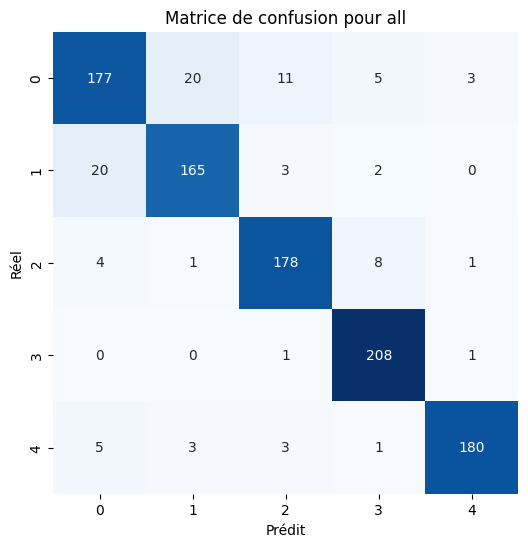


🔍 Recherche des meilleurs hyperparamètres pour Temp...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
🎯 Meilleur score : 0.8557499999999999


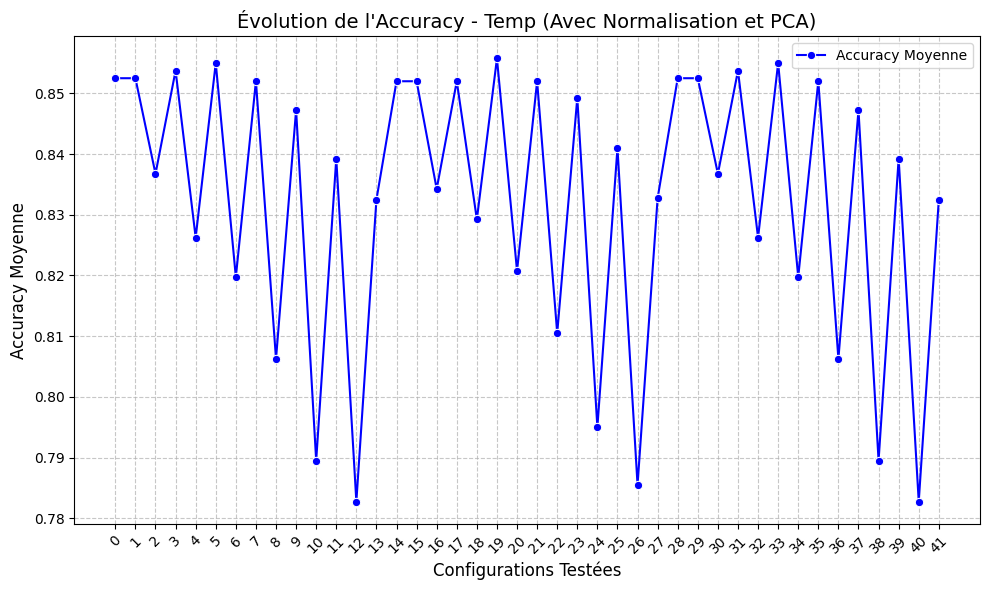


Résultats pour Temp avec PCA90 :
Accuracy du modèle KNN : 0.8700

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       216
         1.0       0.87      0.86      0.87       190
         2.0       0.83      0.85      0.84       192
         3.0       0.89      0.99      0.94       210
         4.0       0.94      0.92      0.93       192

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



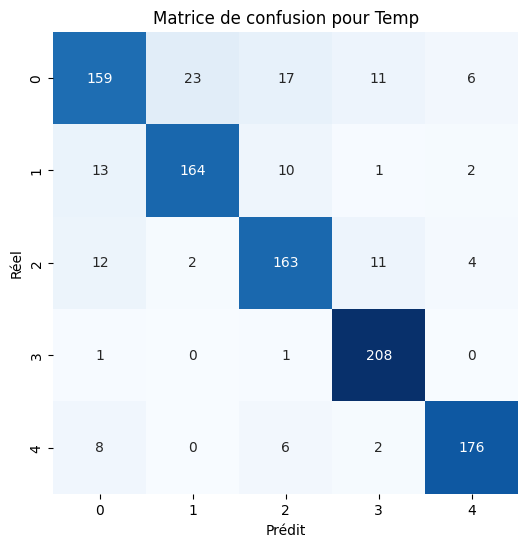


🔍 Recherche des meilleurs hyperparamètres pour Stat...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
🎯 Meilleur score : 0.84825


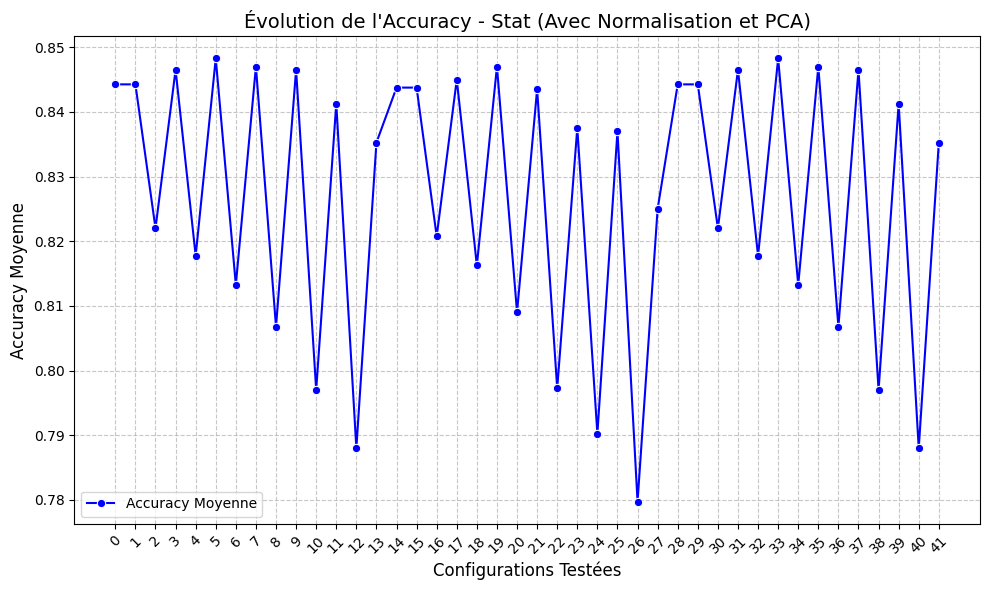


Résultats pour Stat avec PCA90 :
Accuracy du modèle KNN : 0.8590

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       216
         1.0       0.85      0.83      0.84       190
         2.0       0.86      0.79      0.82       192
         3.0       0.86      0.99      0.92       210
         4.0       0.93      0.92      0.93       192

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



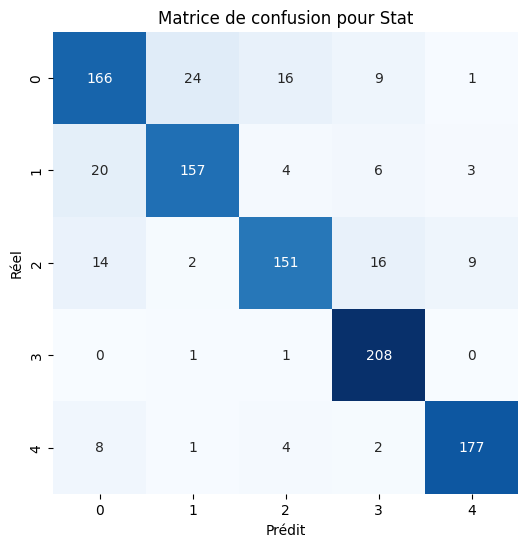


🔍 Recherche des meilleurs hyperparamètres pour Spec...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
🎯 Meilleur score : 0.91625


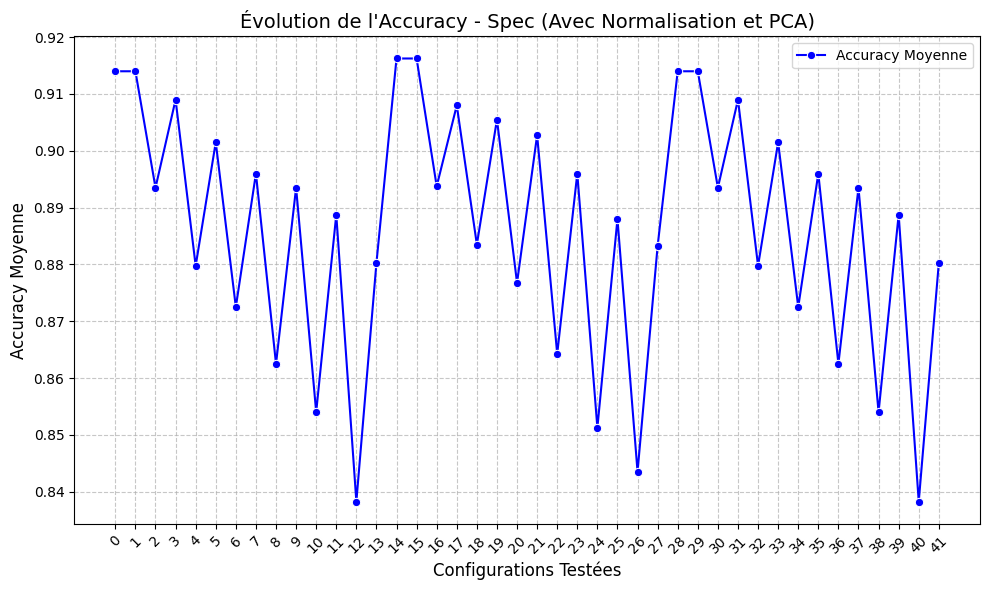


Résultats pour Spec avec PCA90 :
Accuracy du modèle KNN : 0.9100

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       216
         1.0       0.90      0.83      0.86       190
         2.0       0.93      0.91      0.92       192
         3.0       0.93      0.99      0.96       210
         4.0       0.96      0.93      0.95       192

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



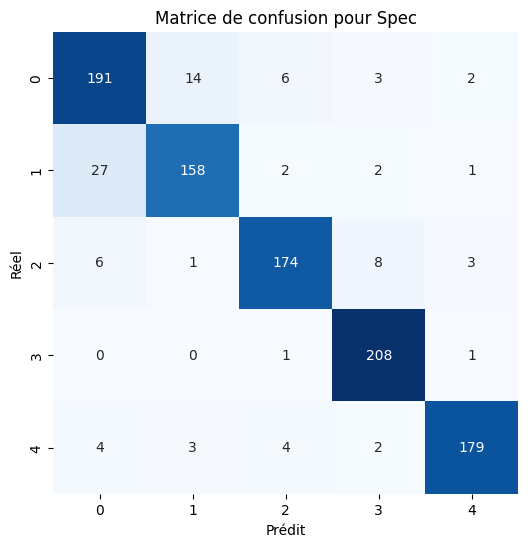


🔍 Recherche des meilleurs hyperparamètres pour ECG...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
✅ Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
🎯 Meilleur score : 0.88125


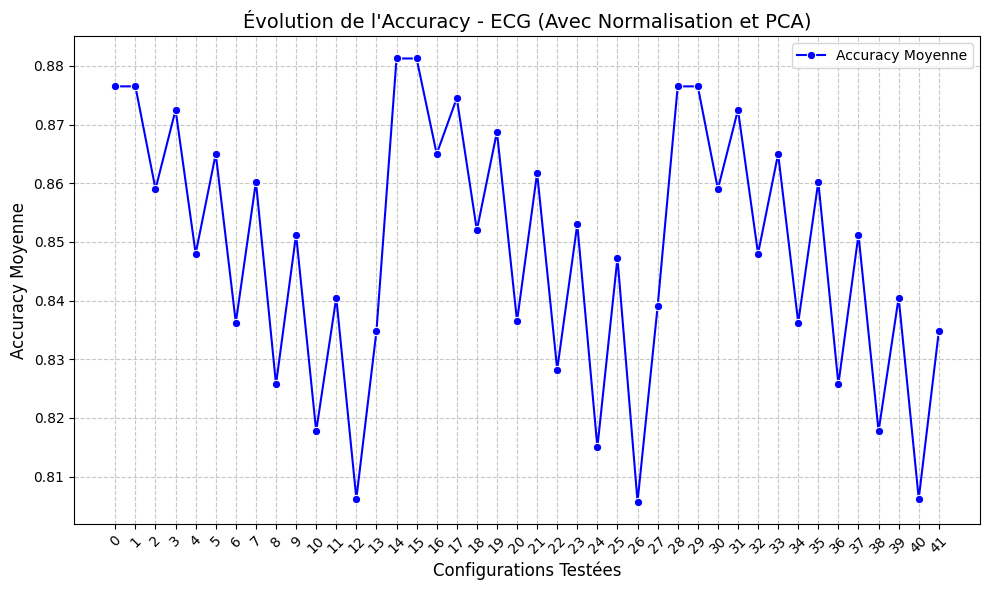


Résultats pour ECG avec PCA90 :
Accuracy du modèle KNN : 0.9000

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85       216
         1.0       0.83      0.87      0.85       190
         2.0       0.93      0.86      0.90       192
         3.0       0.91      0.98      0.94       210
         4.0       0.95      0.97      0.96       192

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



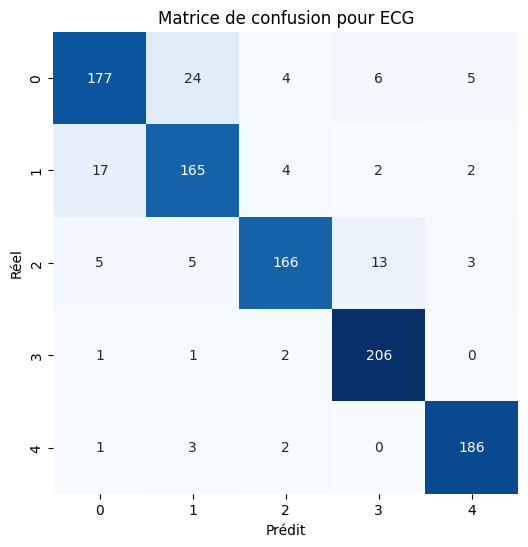

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fonction pour effectuer une recherche d'hyperparamètres avec GridSearchCV pour KNN
def grid_search_knn(data_features, labels, scaling=True):
    if scaling:
        scaler = StandardScaler()
        data_features = scaler.fit_transform(data_features)
    
    # Définition du modèle KNN
    knn = KNeighborsClassifier()
    
    # Définition de la grille de recherche
    param_grid = {
        "n_neighbors": [1, 3, 5, 7, 10, 15, 20],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    }
    
    # Initialisation de GridSearchCV
    grid_search_knn = GridSearchCV(
        knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )
    
    # Exécution de GridSearchCV
    grid_search_knn.fit(data_features, labels)
    
    # Récupération des résultats sous forme de DataFrame
    results_df = pd.DataFrame(grid_search_knn.cv_results_)

    print(f"✅ Meilleurs hyperparamètres : {grid_search_knn.best_params_}")
    print(f"🎯 Meilleur score : {grid_search_knn.best_score_}")

    return grid_search_knn.best_estimator_, grid_search_knn.best_score_, results_df

# Fonction pour visualiser l'évolution de l'accuracy
def plot_accuracy_evolution(results_df, dataset_name, scaler_status):
    """
    Visualise l'évolution de l'accuracy moyenne pour les configurations testées.

    :param results_df: DataFrame contenant les résultats de GridSearchCV.
    :param dataset_name: Nom du dataset (par exemple, 'all', 'Temp', etc.).
    :param scaler_status: Statut de la normalisation (par exemple, 'Avec Normalisation' ou 'Sans Normalisation').
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(results_df)), y=results_df['mean_test_score'], marker='o', color='b', label='Accuracy Moyenne')

    plt.title(f"Évolution de l'Accuracy - {dataset_name} ({scaler_status})", fontsize=14)
    plt.xlabel("Configurations Testées", fontsize=12)
    plt.ylabel("Accuracy Moyenne", fontsize=12)
    plt.xticks(range(len(results_df)), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(conf_matrix, key):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matrice de confusion pour {key}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

# Initialisation des normaliseurs et des ensembles de données
scalers = {"all": StandardScaler(), "Temp": StandardScaler(), "Stat": StandardScaler(), "Spec": StandardScaler(), "ECG": StandardScaler()}
data_sets = {
    "all": (DataFeatureApp, DataFeatureTest),
    "Temp": (DataFeatureAppTemp, DataFeatureTestTemp),
    "Stat": (DataFeatureAppStat, DataFeatureTestStat),
    "Spec": (DataFeatureAppSpec, DataFeatureTestSpec),
    "ECG": (DataECGApp, DataECGTest)
}

# Dictionnaires pour stocker les données normalisées et transformées par PCA
normalized_data = {}
pca_transformed_data = {}
best_models = {}

# Normalisation des données et application de PCA
for key, (train, test) in data_sets.items():
    # Normalisation des données
    scaler = scalers[key]
    normalized_data[f"{key}_train"] = scaler.fit_transform(train)
    normalized_data[f"{key}_test"] = scaler.transform(test)
    
    # Application de PCA avec 90% de variance expliquée
    pca = PCA(n_components=0.90)
    pca_transformed_data[f"{key}_train_PCA"] = pca.fit_transform(normalized_data[f"{key}_train"])
    pca_transformed_data[f"{key}_test_PCA"] = pca.transform(normalized_data[f"{key}_test"])
    print(f"Nombre de composantes pour {key} avec 90% de variance : {pca_transformed_data[f'{key}_train_PCA'].shape[1]}")

# Entraînement et évaluation des modèles KNN avec GridSearchCV
for key in data_sets.keys():
    # Recherche des meilleurs hyperparamètres
    print(f"\n🔍 Recherche des meilleurs hyperparamètres pour {key}...")
    best_model, best_score, results_df = grid_search_knn(pca_transformed_data[f"{key}_train_PCA"], LabelF_train, scaling=False)
    
    # Enregistrement du meilleur modèle
    best_models[key] = best_model
    
    # Visualisation de l'évolution de l'accuracy
    plot_accuracy_evolution(results_df, dataset_name=key, scaler_status="Avec Normalisation et PCA")
    
    # Prédiction sur les données de test
    X_test = pca_transformed_data[f"{key}_test_PCA"]
    y_pred = best_models[key].predict(X_test)
    
    # Calcul des métriques d'évaluation
    accuracy = accuracy_score(LabelF_test, y_pred)
    conf_matrix = confusion_matrix(LabelF_test, y_pred)
    class_report = classification_report(LabelF_test, y_pred)
    
    # Affichage des résultats avec une mise en forme améliorée
    print("\n" + "=" * 60)
    print(f"Résultats pour {key} avec PCA90 :")
    print("=" * 60)
    print(f"Accuracy du modèle KNN : {accuracy:.4f}")
    print("\nRapport de classification :")
    print(class_report)
    
    # Affichage de la matrice de confusion avec matplotlib
    plot_confusion_matrix(conf_matrix, key)

## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)


=== Traitement de l'ensemble de données : all ===

🔍 Recherche des meilleurs hyperparamètres pour K-Means...

Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'dataWithoutScale'} 
Meilleur score : 0.35940821256038646


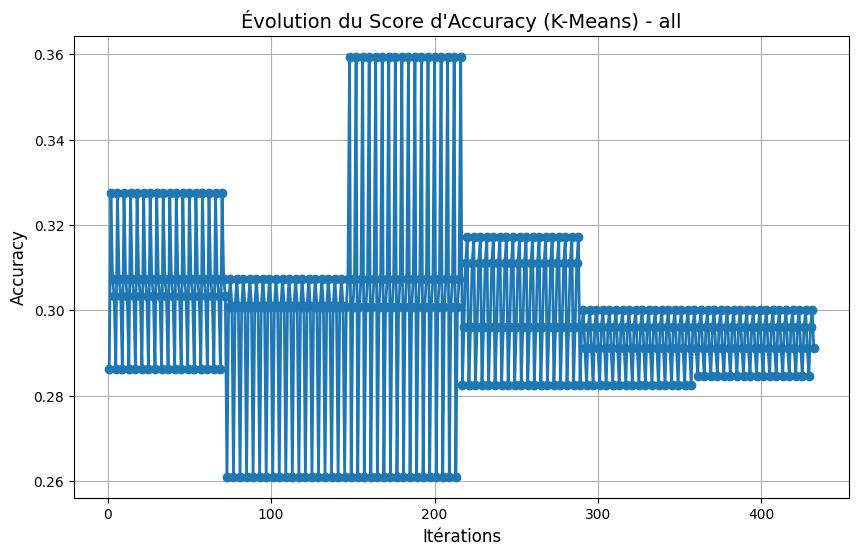


🔍 Recherche des meilleurs hyperparamètres pour Clustering Hiérarchique...

Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'} 
Meilleur score : 0.32237922705314015


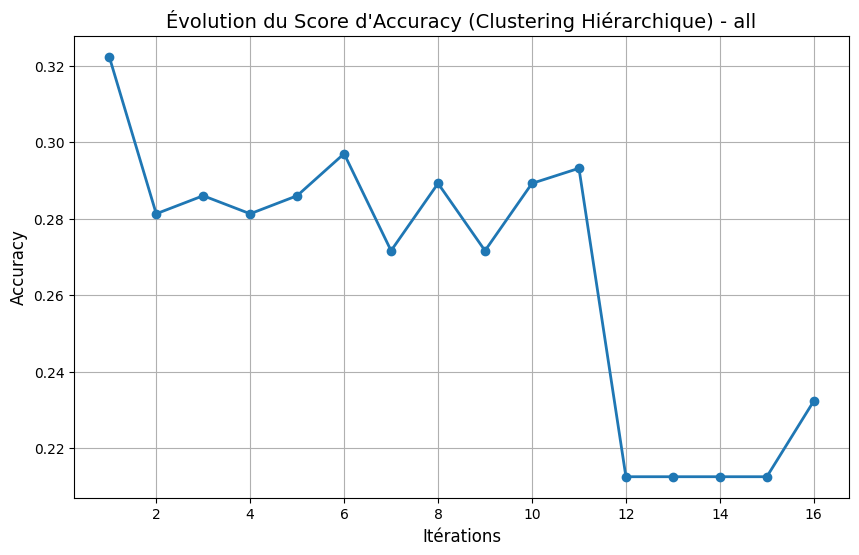


=== Traitement de l'ensemble de données : Temp ===

🔍 Recherche des meilleurs hyperparamètres pour K-Means...

Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'dataWithoutScale'} 
Meilleur score : 0.35940821256038646


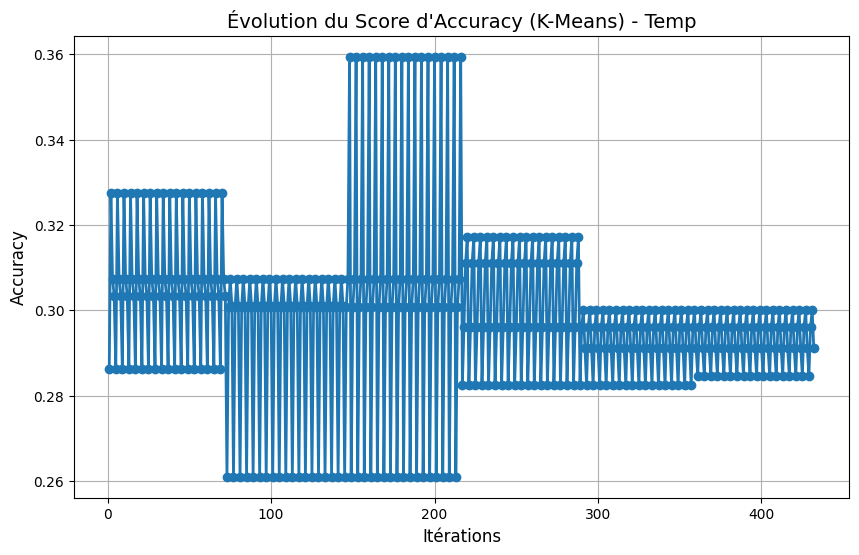


🔍 Recherche des meilleurs hyperparamètres pour Clustering Hiérarchique...

Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'} 
Meilleur score : 0.32237922705314015


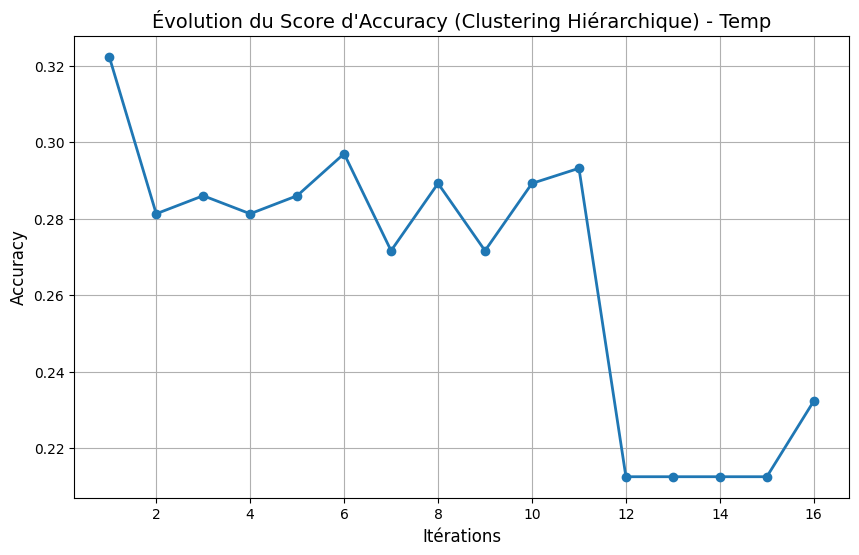


=== Traitement de l'ensemble de données : Stat ===

🔍 Recherche des meilleurs hyperparamètres pour K-Means...

Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'dataWithoutScale'} 
Meilleur score : 0.35940821256038646


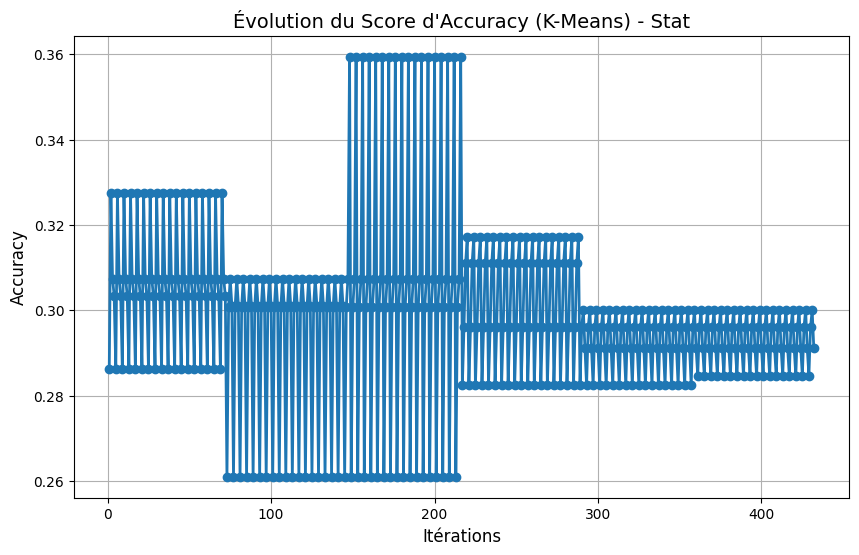


🔍 Recherche des meilleurs hyperparamètres pour Clustering Hiérarchique...

Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'} 
Meilleur score : 0.32237922705314015


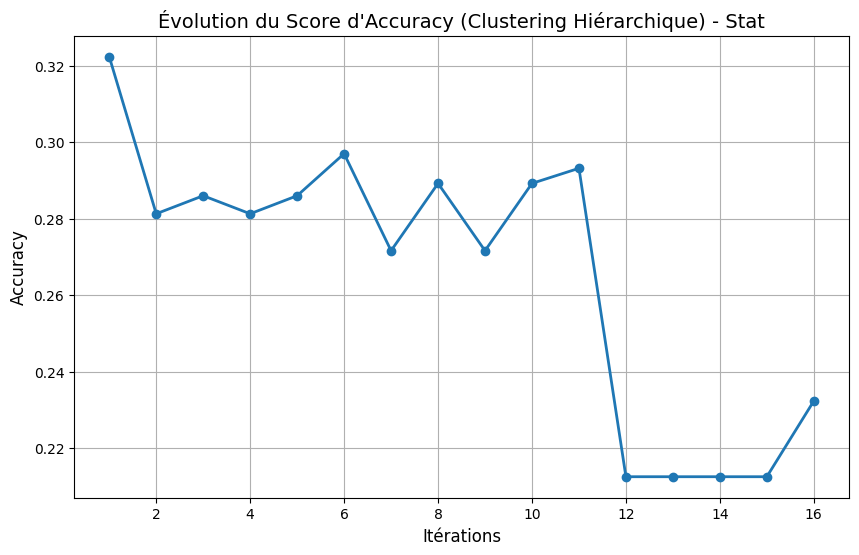


=== Traitement de l'ensemble de données : Spec ===

🔍 Recherche des meilleurs hyperparamètres pour K-Means...

Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'dataWithoutScale'} 
Meilleur score : 0.35940821256038646


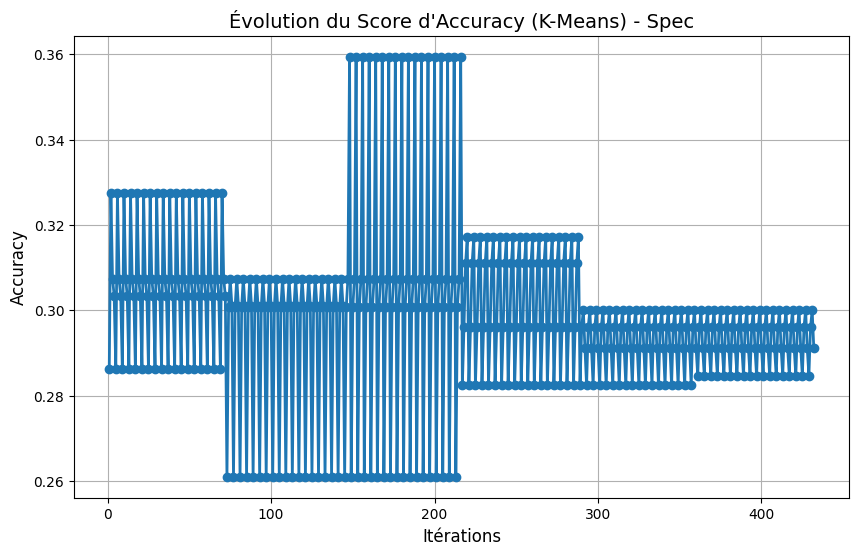


🔍 Recherche des meilleurs hyperparamètres pour Clustering Hiérarchique...

Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'} 
Meilleur score : 0.32237922705314015


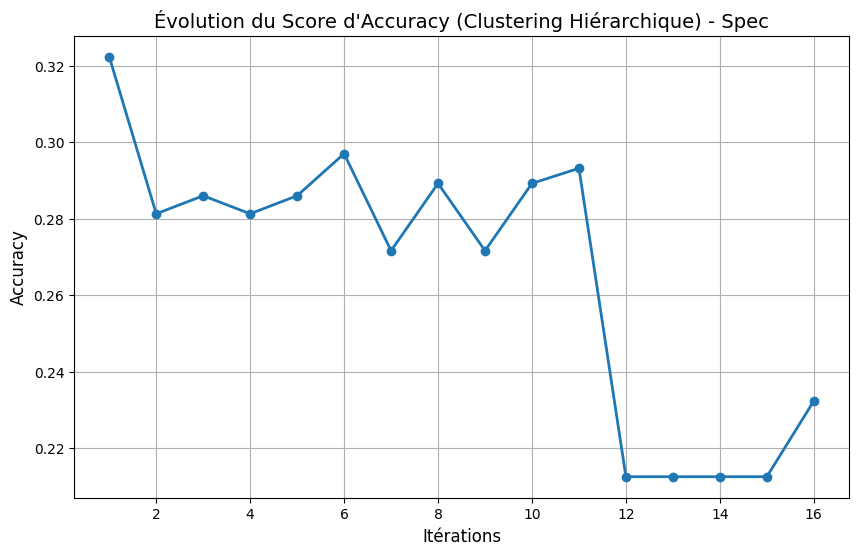


=== Traitement de l'ensemble de données : ECG ===

🔍 Recherche des meilleurs hyperparamètres pour K-Means...

Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'dataWithoutScale'} 
Meilleur score : 0.35940821256038646


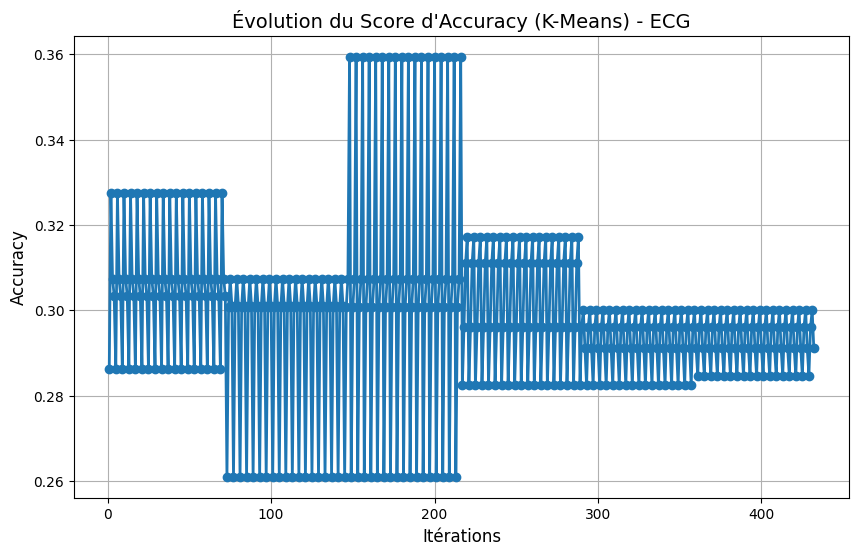


🔍 Recherche des meilleurs hyperparamètres pour Clustering Hiérarchique...

Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'} 
Meilleur score : 0.32237922705314015


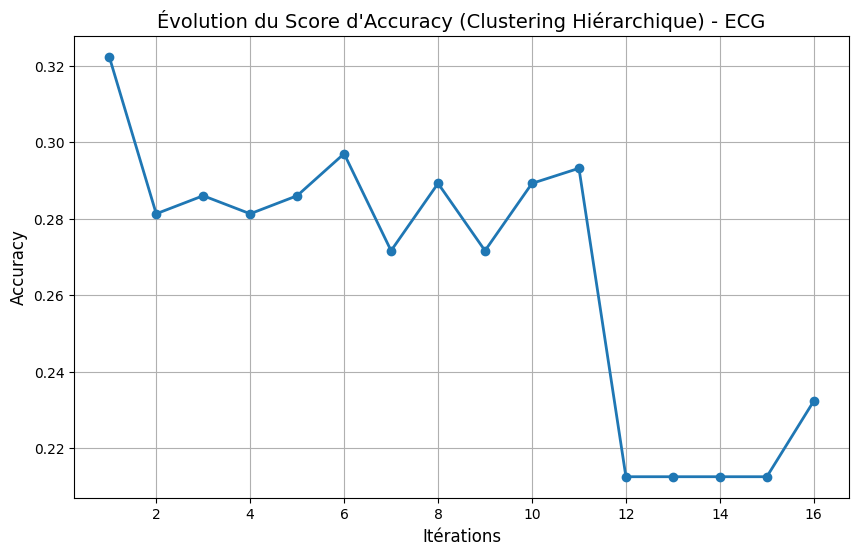

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix

# Fonction pour calculer le score de la matrice de confusion
def conf_matrix_score(LabelF_train, y_pred):
    """
    Calcule le score d'une matrice de confusion.
    Le score est défini comme la somme des bonnes classifications par ligne divisées par le total de la ligne.
    """
    LabelF_train1 = LabelF_train.astype(int)

    # Conversion des clusters en labels réels
    y_pred_labels_temp = true_labels(y_pred, LabelF_train1)  # Remplacez par votre fonction de correspondance
    
    conf_matrix = confusion_matrix(LabelF_train, y_pred_labels_temp)
    
    score = 0
    for i in range(conf_matrix.shape[0]):
        total_in_row = np.sum(conf_matrix[i, :])
        if total_in_row > 0:
            score += conf_matrix[i, i] / total_in_row
    
    return (score / conf_matrix.shape[0])

# Fonction pour visualiser l'évolution du score d'accuracy
def plot_accuracy(scores, title="Évolution du Score d'Accuracy", xlabel="Itérations", ylabel="Accuracy"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.show()

# Fonction pour rechercher les meilleurs hyperparamètres pour K-Means
def hyper_search_kmeans(data_features, LabelF_train):
    # Hyperparamètres
    param_grid = {
        "init": ["k-means++", "random"],
        "n_init": [10, 20, 30],
        "max_iter": [300, 500, 1000],
        "algorithm": ["lloyd", "elkan"],
        "tol": [1e-3, 1e-4, 1e-5],
        "data": {
            "RobustScaler": RobustScaler().fit_transform(data_features),
            "StandardScaler": StandardScaler().fit_transform(data_features),
            "MinMaxScaler": MinMaxScaler().fit_transform(data_features),
            "dataWithoutScale": data_features
        }
    }
    
    # Initialisation des meilleures valeurs
    best_confmatrix = 0
    best_params = {}
    score_l = []
    
    # Teste des hyperparamètres
    for init in param_grid["init"]:
        for n_init in param_grid["n_init"]:
            for max_iter in param_grid["max_iter"]:
                for algorithm in param_grid["algorithm"]:
                    for tol in param_grid["tol"]: 
                        for scaler_name, data in param_grid["data"].items():
                            
                            # Création et entraînement du modèle K-Means
                            kmeans = KMeans(
                                n_clusters=5, init=init, n_init=n_init, 
                                max_iter=max_iter, algorithm=algorithm, 
                                tol=tol, random_state=42
                            )
                            y_pred_km = kmeans.fit_predict(data)
    
                            # Calcul du score de la matrice de confusion
                            score_matrix = conf_matrix_score(LabelF_train, y_pred_km)
                            score_l.append(score_matrix)
    
                            # Mise à jour des meilleurs paramètres
                            if score_matrix > best_confmatrix:
                                best_confmatrix = score_matrix
                                best_params = {
                                    "init": init,
                                    "n_init": n_init,
                                    "max_iter": max_iter,
                                    "algorithm": algorithm,
                                    "tol": tol,
                                    "data": scaler_name
                                }
    
    # Affichage des meilleurs paramètres
    print(f"\nMeilleurs paramètres trouvés : {best_params} \nMeilleur score : {best_confmatrix}")
    return score_l, best_params

# Fonction pour rechercher les meilleurs hyperparamètres pour Clustering Hiérarchique
def hyper_search_hierarchical(data_features, LabelF_train):
    # Hyperparamètres
    param_grid = [
        {"linkage": ["ward"], "metric": ["euclidean"]},  # Ward impose euclidean
        {"linkage": ["complete", "average", "single"], "metric": ["euclidean", "l1", "l2", "manhattan", "cosine"]}
    ]
    
    # Initialisation des meilleures valeurs
    best_confmatrix = 0
    best_params = {}
    score_l = []
    
    # Teste des hyperparamètres
    for params in param_grid:
        for linkage in params["linkage"]:
            for metric in params["metric"]:
                # Création et entraînement du modèle Clustering Hiérarchique
                model = AgglomerativeClustering(
                    n_clusters=5, linkage=linkage, metric=metric
                )
                y_pred_hc = model.fit_predict(data_features)
    
                # Calcul du score de la matrice de confusion
                score_matrix = conf_matrix_score(LabelF_train, y_pred_hc)
                score_l.append(score_matrix)
    
                # Mise à jour des meilleurs paramètres
                if score_matrix > best_confmatrix:
                    best_confmatrix = score_matrix
                    best_params = {
                        "linkage": linkage,
                        "metric": metric
                    }
    
    # Affichage des meilleurs paramètres
    print(f"\nMeilleurs paramètres trouvés : {best_params} \nMeilleur score : {best_confmatrix}")
    return score_l, best_params

# Normalisation et PCA
def normalize_and_pca(data_features, n_components=0.90):
    """
    Applique la normalisation et la PCA.
    """
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data_features)
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_normalized)
    return data_pca

# Exemple d'utilisation
if __name__ == "__main__":
    # Données d'exemple (remplacez par vos données)
    DataFeatureApp = np.random.rand(100, 10)  # Données d'entraînement
    LabelF_train = np.random.randint(0, 5, 100)  # Labels d'entraînement

    # Initialisation des normaliseurs et des ensembles de données
    scalers = {"all": StandardScaler(), "Temp": StandardScaler(), "Stat": StandardScaler(), "Spec": StandardScaler(), "ECG": StandardScaler()}
    data_sets = {
        "all": (DataFeatureApp, DataFeatureApp),  # Remplacez par vos données
        "Temp": (DataFeatureApp, DataFeatureApp),
        "Stat": (DataFeatureApp, DataFeatureApp),
        "Spec": (DataFeatureApp, DataFeatureApp),
        "ECG": (DataFeatureApp, DataFeatureApp)
    }

    # Boucle sur chaque ensemble de données
    for key, (train, _) in data_sets.items():
        print(f"\n=== Traitement de l'ensemble de données : {key} ===")
        
        # Normalisation et PCA
        data_pca = normalize_and_pca(train)
        
        # Recherche des meilleurs hyperparamètres pour K-Means
        print("\n🔍 Recherche des meilleurs hyperparamètres pour K-Means...")
        scores_kmeans, best_params_kmeans = hyper_search_kmeans(data_pca, LabelF_train)
        plot_accuracy(scores_kmeans, title=f"Évolution du Score d'Accuracy (K-Means) - {key}")
        
        # Recherche des meilleurs hyperparamètres pour Clustering Hiérarchique
        print("\n🔍 Recherche des meilleurs hyperparamètres pour Clustering Hiérarchique...")
        scores_hc, best_params_hc = hyper_search_hierarchical(data_pca, LabelF_train)
        plot_accuracy(scores_hc, title=f"Évolution du Score d'Accuracy (Clustering Hiérarchique) - {key}")


# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP
